In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from irm_helpers import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import sys
import os
import time
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
BATCH_SIZE = 64
torch.cuda.empty_cache()

<font size="6">Load train and validation data</font>

In [ ]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

# train_dataset = SubsampledDataset(train_data, grouper)
# ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
# id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_dataset = torch.load("subsampled_data/train.pt")
ood_val_dataset = torch.load("subsampled_data/ood_val.pt")
id_val_dataset = torch.load("subsampled_data/id_val.pt")


train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)


In [ ]:
# torch.save(train_dataset, "subsampled_data/train.pt")
# torch.save(ood_val_dataset, "subsampled_data/ood_val.pt")
# torch.save(id_val_dataset, "subsampled_data/id_val.pt")
# train_dataset = torch.load("subsampled_data/train.pt")
# train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)

# for x, y, metadata in train_loader:
# 	print(x.shape)
# 	break
# print(len(id_val_loader))

In [ ]:
NUM_CLASSES = 10
model = Classifier(NUM_CLASSES, use_pretrained=True, freeze_encoder=True)
model.to(device)

<font size="6">Train and accumulate evaluation per epoch</font>

In [6]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
MODEL_PATH = "models"
MOMENTUM = 0.9


model_name = f"IRM_{NUM_CLASSES}_{NUM_EPOCHS}_SGD_{LEARNING_RATE}_{MOMENTUM}_CrossEntropy_unet_frozen.pth"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
	print(f"EPOCH {epoch + 1}:")
	# train
	y_true, y_pred, metadata, loss = train_step(model, train_loader, loss_fn, optimizer, device)
	train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"Train Loss: {loss}")

	# validation
	y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
	val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"OOD Loss: {loss}")

	# save by best ood loss
	if loss < best_loss:
		best_loss = loss
		torch.save(model, save_name)

	# in distribution validation
	y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
	id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"ID Loss: {loss}")



tensor(2.0199, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:15<00:21,  2.25it/s]

tensor(1.8618, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:15<00:21,  2.21it/s]

tensor(1.9682, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:16<00:21,  2.16it/s]

tensor(1.7658, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:17<00:23,  1.99it/s]

tensor(1.8104, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:17<00:22,  2.03it/s]

tensor(1.5493, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:18<00:21,  2.06it/s]

tensor(1.9187, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:18<00:20,  2.09it/s]

tensor(1.6705, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:18<00:19,  2.10it/s]

tensor(1.8911, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:19<00:19,  2.11it/s]

tensor(1.8760, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:19<00:18,  2.14it/s]

tensor(1.7063, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:20<00:18,  2.13it/s]

tensor(1.6991, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:20<00:17,  2.13it/s]

tensor(1.8619, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:21<00:17,  2.14it/s]

tensor(1.5782, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:21<00:16,  2.13it/s]

tensor(1.5701, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:22<00:16,  2.13it/s]

tensor(2.0213, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:22<00:15,  2.13it/s]

tensor(1.8505, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:23<00:15,  2.17it/s]

tensor(1.6956, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:23<00:14,  2.20it/s]

tensor(1.9146, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:24<00:13,  2.23it/s]

tensor(1.7967, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:24<00:13,  2.26it/s]

tensor(1.7927, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:24<00:12,  2.26it/s]

tensor(1.7577, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:25<00:12,  2.28it/s]

tensor(1.8226, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:25<00:11,  2.30it/s]

tensor(1.7634, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:26<00:11,  2.29it/s]

tensor(1.8757, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:26<00:10,  2.29it/s]

tensor(1.9854, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:27<00:10,  2.30it/s]

tensor(1.8556, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:27<00:09,  2.31it/s]

tensor(1.8367, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:27<00:09,  2.32it/s]

tensor(1.9242, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:28<00:09,  2.33it/s]

tensor(1.7735, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:28<00:08,  2.24it/s]

tensor(1.9566, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:29<00:08,  2.22it/s]

tensor(1.9929, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:29<00:08,  2.21it/s]

tensor(1.5492, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:30<00:07,  2.19it/s]

tensor(2.0287, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:30<00:07,  2.17it/s]

tensor(1.9351, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:31<00:06,  2.15it/s]

tensor(1.8676, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:31<00:06,  2.16it/s]

tensor(2.0336, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:32<00:05,  2.17it/s]

tensor(1.7170, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:32<00:05,  2.15it/s]

tensor(1.6947, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:32<00:05,  2.17it/s]

tensor(1.9353, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:33<00:04,  2.17it/s]

tensor(1.7790, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:33<00:04,  2.18it/s]

tensor(1.9034, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:34<00:03,  2.18it/s]

tensor(1.8113, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:34<00:03,  2.20it/s]

tensor(1.9699, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:35<00:02,  2.19it/s]

tensor(1.6854, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:35<00:02,  2.16it/s]

tensor(1.7477, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:36<00:01,  2.19it/s]

tensor(1.7987, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:36<00:01,  2.20it/s]

tensor(1.8960, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:37<00:00,  2.19it/s]

tensor(1.8626, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:37<00:00,  2.19it/s]

tensor(1.8547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9069, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.8034110134926395


100%|██████████| 91/91 [00:38<00:00,  2.34it/s]


OOD Loss: 1.7492814797621508


100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


ID Loss: 1.8546989773804288
EPOCH 20:


  0%|          | 1/345 [00:00<02:39,  2.15it/s]

tensor(1.8182, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:37,  2.18it/s]

tensor(1.7455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:35,  2.20it/s]

tensor(1.7223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:35,  2.19it/s]

tensor(1.6762, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:35,  2.19it/s]

tensor(1.7962, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:33,  2.20it/s]

tensor(2.0729, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:35,  2.17it/s]

tensor(1.8663, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:34,  2.18it/s]

tensor(1.9330, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:34,  2.17it/s]

tensor(1.7045, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:32,  2.20it/s]

tensor(2.1482, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:31,  2.20it/s]

tensor(1.7339, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:30,  2.21it/s]

tensor(1.8758, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:29,  2.22it/s]

tensor(2.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:29,  2.21it/s]

tensor(1.9580, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:29,  2.20it/s]

tensor(1.7134, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:29,  2.20it/s]

tensor(1.6780, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:29,  2.19it/s]

tensor(1.9112, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:28,  2.20it/s]

tensor(1.7909, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:27,  2.21it/s]

tensor(1.6765, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:35,  2.09it/s]

tensor(1.5617, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:33,  2.11it/s]

tensor(1.6508, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:31,  2.13it/s]

tensor(1.8458, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:30,  2.15it/s]

tensor(1.7754, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:31,  2.12it/s]

tensor(1.8473, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:29,  2.13it/s]

tensor(1.8047, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:11<02:29,  2.14it/s]

tensor(1.8102, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:26,  2.17it/s]

tensor(1.5402, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:26,  2.17it/s]

tensor(1.9659, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:25,  2.17it/s]

tensor(1.7035, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:23,  2.19it/s]

tensor(1.8144, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:22,  2.21it/s]

tensor(1.8424, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:21,  2.21it/s]

tensor(1.6137, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:22,  2.19it/s]

tensor(1.7243, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:22,  2.19it/s]

tensor(1.6471, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:22,  2.18it/s]

tensor(1.7123, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:20,  2.20it/s]

tensor(1.7474, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:16<02:20,  2.19it/s]

tensor(1.8119, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:21,  2.16it/s]

tensor(1.9286, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:17<02:20,  2.17it/s]

tensor(1.6198, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:20,  2.17it/s]

tensor(1.8646, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:20,  2.17it/s]

tensor(1.9011, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:22,  2.13it/s]

tensor(1.9309, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:20,  2.14it/s]

tensor(1.7886, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:20<02:20,  2.15it/s]

tensor(1.9137, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:19,  2.16it/s]

tensor(1.6078, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:21<02:18,  2.16it/s]

tensor(2.0387, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:17,  2.16it/s]

tensor(1.9247, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:22<02:17,  2.16it/s]

tensor(1.8829, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:16,  2.16it/s]

tensor(1.7581, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:23<02:15,  2.18it/s]

tensor(1.7614, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:15,  2.17it/s]

tensor(1.7486, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:23<02:13,  2.19it/s]

tensor(1.7486, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:12,  2.20it/s]

tensor(1.8659, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:12,  2.19it/s]

tensor(1.9696, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:25<02:12,  2.20it/s]

tensor(1.6672, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:12,  2.18it/s]

tensor(1.7428, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:26<02:13,  2.15it/s]

tensor(1.7986, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:26<02:12,  2.17it/s]

tensor(1.8024, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:27<02:10,  2.19it/s]

tensor(1.6671, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:11,  2.16it/s]

tensor(2.0808, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<02:11,  2.17it/s]

tensor(1.7319, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:28<02:11,  2.15it/s]

tensor(1.8319, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<02:11,  2.15it/s]

tensor(1.8542, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:29<02:11,  2.14it/s]

tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:29<02:09,  2.16it/s]

tensor(1.8704, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:30<02:09,  2.16it/s]

tensor(1.7443, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:30<02:09,  2.15it/s]

tensor(2.0166, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:31<02:08,  2.16it/s]

tensor(1.7272, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:31<02:08,  2.15it/s]

tensor(1.6173, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:32<02:06,  2.17it/s]

tensor(1.8805, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:32<02:07,  2.16it/s]

tensor(1.7127, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:33<02:06,  2.15it/s]

tensor(1.7006, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:33<02:05,  2.17it/s]

tensor(1.8326, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:34<02:04,  2.17it/s]

tensor(1.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<02:04,  2.17it/s]

tensor(2.0045, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:35<02:05,  2.15it/s]

tensor(1.9869, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<02:04,  2.15it/s]

tensor(1.8468, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:35<02:02,  2.18it/s]

tensor(1.8485, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<02:01,  2.18it/s]

tensor(1.7468, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:36<02:01,  2.17it/s]

tensor(2.0104, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:37<02:00,  2.19it/s]

tensor(1.7139, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:37<02:00,  2.17it/s]

tensor(1.7192, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:38<02:01,  2.16it/s]

tensor(2.1246, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:38<02:01,  2.15it/s]

tensor(1.6910, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:39<02:00,  2.15it/s]

tensor(1.7701, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<02:00,  2.14it/s]

tensor(1.6628, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:40<02:00,  2.14it/s]

tensor(1.6944, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<01:59,  2.15it/s]

tensor(1.8165, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:41<01:57,  2.17it/s]

tensor(1.7036, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:41<01:58,  2.16it/s]

tensor(1.7870, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:41<01:58,  2.15it/s]

tensor(1.9163, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:42<01:57,  2.15it/s]

tensor(2.0400, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:42<01:57,  2.15it/s]

tensor(1.6467, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:43<01:56,  2.16it/s]

tensor(1.7152, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:43<01:55,  2.17it/s]

tensor(1.9344, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:44<01:55,  2.15it/s]

tensor(1.7628, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:44<01:55,  2.15it/s]

tensor(1.8495, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:45<01:53,  2.17it/s]

tensor(1.8951, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:45<01:53,  2.17it/s]

tensor(1.8542, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:46<01:53,  2.17it/s]

tensor(1.8798, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:46<01:53,  2.14it/s]

tensor(1.7932, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:47<01:59,  2.03it/s]

tensor(1.6724, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:47<01:57,  2.06it/s]

tensor(1.7105, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:48<01:52,  2.14it/s]

tensor(1.7744, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:48<01:49,  2.19it/s]

tensor(1.8546, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:49<01:55,  2.08it/s]

tensor(1.6583, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:49<01:55,  2.06it/s]

tensor(1.7508, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:52,  2.10it/s]

tensor(1.5365, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:50<01:53,  2.09it/s]

tensor(1.6839, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:51,  2.11it/s]

tensor(1.7729, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:51<01:48,  2.16it/s]

tensor(1.7295, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:47,  2.17it/s]

tensor(1.6649, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:52<01:46,  2.18it/s]

tensor(1.7922, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:49,  2.11it/s]

tensor(1.7793, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:53<01:53,  2.03it/s]

tensor(1.9602, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:53<01:47,  2.14it/s]

tensor(1.7002, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:54<01:43,  2.21it/s]

tensor(2.0616, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:54<01:40,  2.27it/s]

tensor(1.7345, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:37,  2.31it/s]

tensor(1.7099, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:55<01:35,  2.34it/s]

tensor(1.8266, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:55<01:35,  2.34it/s]

tensor(1.7284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:56<01:36,  2.31it/s]

tensor(1.7335, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:56<01:37,  2.29it/s]

tensor(2.1702, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:57<01:35,  2.31it/s]

tensor(1.7786, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:57<01:35,  2.29it/s]

tensor(1.8298, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:58<01:35,  2.29it/s]

tensor(2.0718, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:58<01:35,  2.27it/s]

tensor(1.8417, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:34,  2.29it/s]

tensor(1.6056, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:59<01:35,  2.27it/s]

tensor(2.2240, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:59<01:35,  2.26it/s]

tensor(1.8848, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [01:00<01:34,  2.27it/s]

tensor(1.6561, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:33,  2.28it/s]

tensor(1.8555, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:01<01:33,  2.26it/s]

tensor(2.0801, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:33,  2.26it/s]

tensor(1.7297, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:32,  2.28it/s]

tensor(1.7766, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:02<01:31,  2.27it/s]

tensor(1.7925, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:31,  2.26it/s]

tensor(1.7689, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:03<01:30,  2.28it/s]

tensor(1.8351, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:29,  2.30it/s]

tensor(1.6999, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:04<01:30,  2.27it/s]

tensor(1.9034, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:29,  2.27it/s]

tensor(1.9177, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:05<01:29,  2.28it/s]

tensor(1.8333, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:28,  2.30it/s]

tensor(1.8177, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:27,  2.29it/s]

tensor(1.6375, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:27,  2.29it/s]

tensor(1.8206, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:06<01:26,  2.29it/s]

tensor(1.8222, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:26,  2.29it/s]

tensor(1.8574, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:26,  2.29it/s]

tensor(1.9652, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:08<01:25,  2.29it/s]

tensor(1.8259, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:24,  2.31it/s]

tensor(1.7932, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:08<01:24,  2.29it/s]

tensor(1.9497, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:23,  2.30it/s]

tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:09<01:23,  2.31it/s]

tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:22,  2.31it/s]

tensor(1.7530, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:10<01:23,  2.28it/s]

tensor(1.5680, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:11<01:23,  2.27it/s]

tensor(1.8539, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:11<01:22,  2.27it/s]

tensor(1.6284, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:12<01:22,  2.28it/s]

tensor(1.8672, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:12<01:21,  2.28it/s]

tensor(1.8824, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:12<01:20,  2.29it/s]

tensor(1.9515, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:13<01:21,  2.27it/s]

tensor(1.8508, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:13<01:20,  2.27it/s]

tensor(1.8809, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:14<01:20,  2.25it/s]

tensor(1.9412, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:14<01:19,  2.27it/s]

tensor(1.5815, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:15<01:19,  2.26it/s]

tensor(1.7361, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:15<01:18,  2.28it/s]

tensor(1.7376, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:16<01:18,  2.27it/s]

tensor(1.7842, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:16<01:17,  2.27it/s]

tensor(1.7804, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:16<01:17,  2.27it/s]

tensor(1.7814, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:17<01:16,  2.28it/s]

tensor(1.6695, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:17<01:16,  2.28it/s]

tensor(1.7034, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:18<01:15,  2.29it/s]

tensor(1.7217, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:18<01:15,  2.29it/s]

tensor(1.7965, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:19<01:14,  2.30it/s]

tensor(1.8123, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:19<01:14,  2.28it/s]

tensor(1.8102, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:19<01:14,  2.28it/s]

tensor(1.9140, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:20<01:13,  2.28it/s]

tensor(1.6530, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:20<01:17,  2.15it/s]

tensor(1.6975, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:21<01:15,  2.21it/s]

tensor(1.8416, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:21<01:13,  2.25it/s]

tensor(1.7245, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:22<01:13,  2.25it/s]

tensor(2.0594, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:22<01:12,  2.24it/s]

tensor(1.8015, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:23<01:11,  2.25it/s]

tensor(1.8769, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:23<01:10,  2.27it/s]

tensor(1.8436, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:23<01:09,  2.29it/s]

tensor(1.6882, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:24<01:08,  2.31it/s]

tensor(1.7331, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:24<01:08,  2.32it/s]

tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:25<01:07,  2.33it/s]

tensor(1.7910, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:25<01:07,  2.33it/s]

tensor(1.6266, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:26<01:05,  2.35it/s]

tensor(1.7225, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:26<01:05,  2.36it/s]

tensor(1.7440, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:26<01:05,  2.35it/s]

tensor(1.7428, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:27<01:04,  2.36it/s]

tensor(1.6748, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:27<01:03,  2.37it/s]

tensor(2.1142, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:28<01:03,  2.37it/s]

tensor(1.7629, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:28<01:03,  2.36it/s]

tensor(1.6125, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:29<01:03,  2.35it/s]

tensor(1.7127, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:29<01:02,  2.35it/s]

tensor(1.7002, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:29<01:01,  2.37it/s]

tensor(1.7927, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:30<01:00,  2.38it/s]

tensor(2.1552, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:30<00:59,  2.40it/s]

tensor(1.7391, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:31<00:59,  2.42it/s]

tensor(1.6294, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:31<00:58,  2.42it/s]

tensor(1.6475, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:31<01:00,  2.34it/s]

tensor(1.6456, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:32<00:59,  2.37it/s]

tensor(1.7869, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:32<00:58,  2.38it/s]

tensor(1.8999, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:33<00:57,  2.39it/s]

tensor(1.7138, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:33<00:57,  2.39it/s]

tensor(1.8662, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:34<00:56,  2.41it/s]

tensor(1.5290, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:34<00:55,  2.41it/s]

tensor(1.6667, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:34<00:55,  2.42it/s]

tensor(1.8382, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:35<00:55,  2.38it/s]

tensor(1.9236, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:35<00:55,  2.38it/s]

tensor(1.8753, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:36<00:54,  2.40it/s]

tensor(1.7348, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:54,  2.40it/s]

tensor(1.7818, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:36<00:53,  2.40it/s]

tensor(1.6683, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:53,  2.40it/s]

tensor(1.9337, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:37<00:53,  2.38it/s]

tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<00:52,  2.38it/s]

tensor(1.8587, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:38<00:52,  2.39it/s]

tensor(1.7844, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:39<00:51,  2.40it/s]

tensor(1.9207, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:39<00:51,  2.41it/s]

tensor(1.6573, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:39<00:50,  2.41it/s]

tensor(1.6408, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:40<00:50,  2.39it/s]

tensor(1.6786, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:40<00:50,  2.37it/s]

tensor(1.6974, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:50,  2.35it/s]

tensor(1.7499, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:41<00:50,  2.35it/s]

tensor(1.7396, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:49,  2.37it/s]

tensor(1.9107, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:42<00:48,  2.37it/s]

tensor(1.8502, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:42<00:48,  2.38it/s]

tensor(1.5646, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:43<00:47,  2.38it/s]

tensor(1.7135, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:43<00:47,  2.37it/s]

tensor(1.8114, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:44<00:47,  2.37it/s]

tensor(1.7067, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:44<00:46,  2.37it/s]

tensor(1.7107, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:44<00:46,  2.38it/s]

tensor(1.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:45<00:45,  2.39it/s]

tensor(1.9806, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:45<00:45,  2.39it/s]

tensor(1.6603, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:46<00:44,  2.40it/s]

tensor(2.0911, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:46<00:43,  2.41it/s]

tensor(1.7078, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:47<00:43,  2.41it/s]

tensor(1.7895, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:47<00:42,  2.42it/s]

tensor(1.7913, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:47<00:42,  2.42it/s]

tensor(1.9833, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:48<00:42,  2.40it/s]

tensor(1.6950, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:48<00:42,  2.39it/s]

tensor(2.0281, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:49<00:42,  2.38it/s]

tensor(1.8210, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:49<00:42,  2.31it/s]

tensor(1.8359, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:49<00:41,  2.35it/s]

tensor(1.7710, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:50<00:40,  2.37it/s]

tensor(1.5921, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:50<00:40,  2.39it/s]

tensor(1.9900, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:51<00:39,  2.41it/s]

tensor(1.9896, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:51<00:39,  2.41it/s]

tensor(1.7267, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:52<00:38,  2.40it/s]

tensor(1.9231, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:52<00:38,  2.40it/s]

tensor(1.7462, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:52<00:37,  2.41it/s]

tensor(1.9068, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:53<00:37,  2.41it/s]

tensor(1.7790, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:53<00:36,  2.42it/s]

tensor(1.7569, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:54<00:36,  2.40it/s]

tensor(1.7567, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:54<00:36,  2.39it/s]

tensor(1.9409, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:54<00:36,  2.36it/s]

tensor(1.6942, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:55<00:35,  2.37it/s]

tensor(1.5166, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:55<00:35,  2.39it/s]

tensor(1.8452, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:56<00:35,  2.35it/s]

tensor(1.7209, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:56<00:34,  2.37it/s]

tensor(1.9806, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:57<00:34,  2.38it/s]

tensor(1.8853, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:57<00:34,  2.30it/s]

tensor(1.8245, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:57<00:34,  2.31it/s]

tensor(1.6055, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [01:58<00:33,  2.31it/s]

tensor(1.8595, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [01:58<00:33,  2.31it/s]

tensor(1.8853, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [01:59<00:33,  2.30it/s]

tensor(1.6772, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [01:59<00:32,  2.31it/s]

tensor(1.8088, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:00<00:32,  2.31it/s]

tensor(1.8199, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:00<00:31,  2.30it/s]

tensor(1.4969, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:01<00:30,  2.34it/s]

tensor(1.8626, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:01<00:30,  2.35it/s]

tensor(1.9347, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:01<00:29,  2.34it/s]

tensor(1.8088, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:02<00:29,  2.35it/s]

tensor(1.7328, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:02<00:29,  2.34it/s]

tensor(1.7215, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:03<00:28,  2.33it/s]

tensor(1.8712, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:03<00:28,  2.31it/s]

tensor(1.6055, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:04<00:28,  2.31it/s]

tensor(1.8877, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:04<00:27,  2.30it/s]

tensor(1.7512, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:04<00:27,  2.29it/s]

tensor(1.9404, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:05<00:27,  2.29it/s]

tensor(1.8635, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:05<00:26,  2.28it/s]

tensor(1.6375, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:06<00:26,  2.27it/s]

tensor(1.7863, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:06<00:25,  2.28it/s]

tensor(1.6589, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:07<00:25,  2.29it/s]

tensor(1.7801, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:07<00:25,  2.27it/s]

tensor(1.7293, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:07<00:24,  2.27it/s]

tensor(1.6040, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:08<00:24,  2.25it/s]

tensor(1.9933, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:08<00:23,  2.25it/s]

tensor(1.5423, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:09<00:23,  2.27it/s]

tensor(1.7369, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:09<00:23,  2.25it/s]

tensor(1.7708, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:10<00:22,  2.25it/s]

tensor(1.5521, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:10<00:22,  2.25it/s]

tensor(1.8534, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:11<00:21,  2.25it/s]

tensor(1.8003, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:11<00:21,  2.22it/s]

tensor(1.8505, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:11<00:20,  2.25it/s]

tensor(1.6760, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:12<00:20,  2.24it/s]

tensor(1.8271, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:12<00:20,  2.23it/s]

tensor(1.7848, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:13<00:19,  2.23it/s]

tensor(1.8786, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:13<00:19,  2.23it/s]

tensor(1.6980, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:14<00:18,  2.22it/s]

tensor(1.9266, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:14<00:18,  2.23it/s]

tensor(1.8755, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:15<00:17,  2.23it/s]

tensor(1.6036, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:15<00:17,  2.23it/s]

tensor(1.9567, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:16<00:17,  2.20it/s]

tensor(1.7994, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:16<00:16,  2.26it/s]

tensor(2.0115, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:16<00:15,  2.27it/s]

tensor(1.8842, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:17<00:15,  2.28it/s]

tensor(1.8907, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:17<00:15,  2.25it/s]

tensor(1.6766, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:18<00:14,  2.25it/s]

tensor(1.5891, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:18<00:14,  2.26it/s]

tensor(1.8680, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:19<00:13,  2.25it/s]

tensor(1.8226, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:19<00:13,  2.25it/s]

tensor(1.5982, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:20<00:12,  2.23it/s]

tensor(1.8209, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:20<00:12,  2.23it/s]

tensor(1.7664, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:20<00:12,  2.23it/s]

tensor(1.5572, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:21<00:11,  2.23it/s]

tensor(1.7181, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:21<00:11,  2.23it/s]

tensor(1.6979, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:22<00:10,  2.22it/s]

tensor(1.9055, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:22<00:10,  2.22it/s]

tensor(1.8374, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:23<00:09,  2.23it/s]

tensor(1.8297, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:23<00:09,  2.23it/s]

tensor(1.8520, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:24<00:09,  2.22it/s]

tensor(1.7498, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:24<00:08,  2.22it/s]

tensor(1.7958, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:24<00:08,  2.22it/s]

tensor(1.9151, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:25<00:07,  2.25it/s]

tensor(1.5728, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:25<00:07,  2.25it/s]

tensor(1.6888, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:26<00:06,  2.24it/s]

tensor(1.8757, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:26<00:06,  2.23it/s]

tensor(1.7745, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:27<00:05,  2.22it/s]

tensor(2.0327, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:27<00:05,  2.23it/s]

tensor(1.8015, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:28<00:04,  2.23it/s]

tensor(1.6040, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:28<00:04,  2.23it/s]

tensor(1.8155, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:29<00:04,  2.21it/s]

tensor(1.8242, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:29<00:03,  2.22it/s]

tensor(1.6814, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:29<00:03,  2.22it/s]

tensor(1.6973, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:30<00:02,  2.22it/s]

tensor(1.7366, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:30<00:02,  2.23it/s]

tensor(1.9407, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:31<00:01,  2.22it/s]

tensor(1.7818, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:31<00:01,  2.22it/s]

tensor(2.0284, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:32<00:00,  2.22it/s]

tensor(1.8545, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:32<00:00,  2.26it/s]

tensor(1.8413, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7462, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.7951227329779362


100%|██████████| 91/91 [00:39<00:00,  2.30it/s]


OOD Loss: 1.7505458763667516


100%|██████████| 53/53 [00:21<00:00,  2.50it/s]


ID Loss: 1.8647146944729787
EPOCH 21:


  0%|          | 1/345 [00:00<02:22,  2.42it/s]

tensor(1.7225, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:23,  2.39it/s]

tensor(1.6599, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:22,  2.39it/s]

tensor(1.9005, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:22,  2.40it/s]

tensor(1.6357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:22,  2.39it/s]

tensor(1.8605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:21,  2.39it/s]

tensor(1.7336, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:02<02:23,  2.36it/s]

tensor(1.9679, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:22,  2.37it/s]

tensor(1.9412, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:03<02:23,  2.34it/s]

tensor(1.7610, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:23,  2.34it/s]

tensor(1.8589, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:04<02:22,  2.35it/s]

tensor(1.6863, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:23,  2.32it/s]

tensor(2.1114, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:25,  2.29it/s]

tensor(1.7612, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:05<02:26,  2.26it/s]

tensor(1.5754, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:24,  2.28it/s]

tensor(1.8173, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:06<02:22,  2.31it/s]

tensor(1.8738, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:20,  2.33it/s]

tensor(1.8521, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:07<02:19,  2.34it/s]

tensor(1.7918, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:21,  2.31it/s]

tensor(1.7825, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:08<02:21,  2.29it/s]

tensor(1.7352, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:22,  2.28it/s]

tensor(1.7276, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:09<02:20,  2.30it/s]

tensor(1.8100, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:09<02:18,  2.32it/s]

tensor(1.6938, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:10<02:19,  2.31it/s]

tensor(1.6908, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:10<02:17,  2.32it/s]

tensor(1.7224, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:11<02:16,  2.33it/s]

tensor(1.5326, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:11<02:15,  2.35it/s]

tensor(1.7775, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:15,  2.33it/s]

tensor(1.8588, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:12<02:17,  2.30it/s]

tensor(1.7050, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:12<02:17,  2.28it/s]

tensor(1.8728, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:13<02:15,  2.32it/s]

tensor(2.0356, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:13<02:14,  2.32it/s]

tensor(1.6262, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:14<02:16,  2.29it/s]

tensor(1.6849, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:14<02:16,  2.28it/s]

tensor(1.8518, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:15<02:15,  2.29it/s]

tensor(1.7695, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:15<02:13,  2.31it/s]

tensor(1.7596, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:15<02:13,  2.31it/s]

tensor(1.7037, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:16<02:12,  2.32it/s]

tensor(1.7559, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:16<02:11,  2.32it/s]

tensor(1.7413, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:17<02:12,  2.30it/s]

tensor(1.9880, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:17<02:13,  2.28it/s]

tensor(1.7592, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:18<02:15,  2.24it/s]

tensor(1.8729, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:18<02:15,  2.23it/s]

tensor(1.7671, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:19<02:13,  2.26it/s]

tensor(1.6697, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:19<02:17,  2.18it/s]

tensor(1.9468, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:19<02:16,  2.19it/s]

tensor(1.7191, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:20<02:16,  2.18it/s]

tensor(1.8635, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:20<02:15,  2.19it/s]

tensor(1.8393, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:21<02:15,  2.19it/s]

tensor(1.9698, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:21<02:14,  2.20it/s]

tensor(1.9739, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:22<02:12,  2.22it/s]

tensor(1.7064, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:22<02:12,  2.22it/s]

tensor(1.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:23<02:10,  2.23it/s]

tensor(1.9682, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:23<02:10,  2.24it/s]

tensor(1.5384, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:24<02:08,  2.25it/s]

tensor(1.7974, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:24<02:08,  2.25it/s]

tensor(1.8794, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:24<02:06,  2.27it/s]

tensor(1.5884, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:25<02:06,  2.27it/s]

tensor(1.7342, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:25<02:05,  2.27it/s]

tensor(1.8640, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:26<02:04,  2.29it/s]

tensor(1.9053, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:26<02:06,  2.25it/s]

tensor(1.8528, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:27<02:06,  2.24it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:27<02:05,  2.24it/s]

tensor(2.0281, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:28<02:05,  2.24it/s]

tensor(1.7789, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:28<02:04,  2.25it/s]

tensor(1.7253, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:28<02:04,  2.25it/s]

tensor(1.8873, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:29<02:02,  2.26it/s]

tensor(1.7661, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:29<02:02,  2.26it/s]

tensor(1.8554, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:30<02:02,  2.26it/s]

tensor(1.8785, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:30<02:01,  2.26it/s]

tensor(1.5857, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:31<02:00,  2.27it/s]

tensor(1.6678, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:31<01:59,  2.28it/s]

tensor(1.4975, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:31<02:00,  2.25it/s]

tensor(1.8581, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:32<01:59,  2.26it/s]

tensor(1.6518, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:32<02:00,  2.24it/s]

tensor(1.7279, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:33<02:00,  2.23it/s]

tensor(1.8416, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:33<02:00,  2.22it/s]

tensor(1.8489, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:34<01:59,  2.24it/s]

tensor(1.9315, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:34<01:59,  2.23it/s]

tensor(1.8457, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:35<01:58,  2.23it/s]

tensor(1.6470, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:35<01:58,  2.22it/s]

tensor(2.0966, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:36<01:58,  2.23it/s]

tensor(1.6241, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:36<01:57,  2.23it/s]

tensor(1.6796, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:36<01:57,  2.23it/s]

tensor(1.7367, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:37<01:56,  2.23it/s]

tensor(1.7544, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:37<02:02,  2.12it/s]

tensor(1.8261, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:38<01:59,  2.15it/s]

tensor(1.6764, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:38<01:59,  2.15it/s]

tensor(1.6662, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:39<01:57,  2.18it/s]

tensor(1.8656, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:39<01:56,  2.18it/s]

tensor(1.5940, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:40<01:55,  2.20it/s]

tensor(1.8136, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:40<01:54,  2.21it/s]

tensor(1.7825, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:41<01:54,  2.20it/s]

tensor(1.6758, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:41<01:53,  2.21it/s]

tensor(1.7564, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:41<01:53,  2.21it/s]

tensor(1.6407, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:42<01:52,  2.21it/s]

tensor(1.8140, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:42<01:52,  2.20it/s]

tensor(2.0353, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:43<01:52,  2.20it/s]

tensor(1.8839, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:43<01:51,  2.21it/s]

tensor(1.7716, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:44<01:50,  2.21it/s]

tensor(1.9208, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:44<01:49,  2.22it/s]

tensor(1.8382, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:45<01:49,  2.21it/s]

tensor(1.7725, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:45<01:48,  2.23it/s]

tensor(1.9578, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:46<01:48,  2.23it/s]

tensor(1.7029, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:46<01:47,  2.23it/s]

tensor(1.8210, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:46<01:46,  2.24it/s]

tensor(1.8043, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:47<01:45,  2.26it/s]

tensor(1.9601, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:47<01:45,  2.25it/s]

tensor(1.8840, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:48<01:45,  2.24it/s]

tensor(1.6155, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:48<01:45,  2.22it/s]

tensor(1.7676, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:49<01:44,  2.23it/s]

tensor(1.8144, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:49<01:43,  2.26it/s]

tensor(1.6190, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:50<01:43,  2.24it/s]

tensor(1.6568, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:50<01:43,  2.23it/s]

tensor(1.8604, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:50<01:42,  2.25it/s]

tensor(1.6326, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:51<01:42,  2.23it/s]

tensor(1.7276, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:51<01:42,  2.22it/s]

tensor(1.9144, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:52<01:42,  2.22it/s]

tensor(1.5618, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:52<01:42,  2.21it/s]

tensor(1.8804, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:53<01:42,  2.21it/s]

tensor(1.8685, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:53<01:41,  2.21it/s]

tensor(1.8762, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:54<01:40,  2.22it/s]

tensor(1.5681, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:54<01:39,  2.22it/s]

tensor(1.8740, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:54<01:39,  2.23it/s]

tensor(1.8799, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:55<01:39,  2.22it/s]

tensor(1.6115, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:55<01:38,  2.22it/s]

tensor(1.9303, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:56<01:38,  2.21it/s]

tensor(1.6650, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:56<01:38,  2.20it/s]

tensor(1.8866, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:57<01:39,  2.18it/s]

tensor(1.8244, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:57<01:38,  2.18it/s]

tensor(1.9957, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:58<01:37,  2.19it/s]

tensor(1.8503, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [00:58<01:36,  2.20it/s]

tensor(1.8059, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [00:59<01:35,  2.21it/s]

tensor(1.7190, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [00:59<01:36,  2.19it/s]

tensor(1.5904, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [00:59<01:34,  2.23it/s]

tensor(1.7876, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:00<01:33,  2.24it/s]

tensor(1.6397, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:00<01:33,  2.24it/s]

tensor(1.8571, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:01<01:33,  2.22it/s]

tensor(1.6540, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:01<01:33,  2.20it/s]

tensor(1.8673, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:02<01:32,  2.20it/s]

tensor(1.7678, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:02<01:32,  2.22it/s]

tensor(1.8975, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:03<01:31,  2.22it/s]

tensor(1.7959, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:03<01:32,  2.19it/s]

tensor(1.8687, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:04<01:31,  2.20it/s]

tensor(1.9808, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:04<01:30,  2.22it/s]

tensor(1.8008, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:04<01:29,  2.22it/s]

tensor(1.7465, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:05<01:29,  2.21it/s]

tensor(1.8859, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:05<01:28,  2.22it/s]

tensor(1.9312, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:06<01:28,  2.21it/s]

tensor(1.9987, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:06<01:27,  2.24it/s]

tensor(1.7638, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:07<01:25,  2.26it/s]

tensor(1.7056, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:07<01:25,  2.25it/s]

tensor(1.6041, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:08<01:25,  2.25it/s]

tensor(1.7810, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:08<01:25,  2.24it/s]

tensor(2.0306, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:08<01:24,  2.24it/s]

tensor(1.7695, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:09<01:24,  2.24it/s]

tensor(1.8298, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:09<01:24,  2.23it/s]

tensor(1.7079, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:10<01:24,  2.22it/s]

tensor(1.7273, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:10<01:23,  2.22it/s]

tensor(1.8419, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:11<01:23,  2.22it/s]

tensor(1.9080, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:11<01:23,  2.21it/s]

tensor(1.6241, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:12<01:22,  2.22it/s]

tensor(1.6945, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:12<01:21,  2.22it/s]

tensor(1.6313, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:13<01:21,  2.23it/s]

tensor(1.8319, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:13<01:20,  2.23it/s]

tensor(2.0465, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:13<01:19,  2.25it/s]

tensor(1.7239, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:14<01:18,  2.27it/s]

tensor(1.7455, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:14<01:18,  2.25it/s]

tensor(1.7017, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:15<01:18,  2.26it/s]

tensor(1.7926, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:15<01:18,  2.22it/s]

tensor(1.7830, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:16<01:18,  2.20it/s]

tensor(1.7521, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:16<01:18,  2.21it/s]

tensor(1.9931, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:17<01:17,  2.22it/s]

tensor(1.8215, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:17<01:17,  2.21it/s]

tensor(1.7691, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:17<01:17,  2.20it/s]

tensor(1.7450, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:18<01:16,  2.21it/s]

tensor(1.7264, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:18<01:16,  2.21it/s]

tensor(1.9169, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:19<01:15,  2.21it/s]

tensor(1.8311, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:19<01:15,  2.21it/s]

tensor(1.9644, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:20<01:14,  2.22it/s]

tensor(1.5647, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:20<01:14,  2.21it/s]

tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:21<01:13,  2.22it/s]

tensor(1.9999, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:21<01:12,  2.24it/s]

tensor(1.9290, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:22<01:12,  2.22it/s]

tensor(1.8871, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:22<01:12,  2.21it/s]

tensor(1.7750, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:22<01:11,  2.22it/s]

tensor(1.7895, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:23<01:13,  2.15it/s]

tensor(1.8222, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:23<01:13,  2.15it/s]

tensor(1.7745, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:24<01:11,  2.17it/s]

tensor(1.8729, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:24<01:10,  2.19it/s]

tensor(1.9365, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:25<01:10,  2.18it/s]

tensor(1.8461, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:25<01:10,  2.18it/s]

tensor(1.7938, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:26<01:09,  2.19it/s]

tensor(1.7764, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:26<01:08,  2.20it/s]

tensor(1.6952, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:27<01:08,  2.20it/s]

tensor(1.7264, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:27<01:07,  2.21it/s]

tensor(1.8215, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:27<01:07,  2.20it/s]

tensor(1.7213, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:28<01:06,  2.20it/s]

tensor(1.8085, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:28<01:05,  2.22it/s]

tensor(1.7404, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:29<01:04,  2.23it/s]

tensor(1.6545, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:29<01:04,  2.22it/s]

tensor(1.7583, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:30<01:03,  2.24it/s]

tensor(1.7606, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:30<01:03,  2.25it/s]

tensor(1.8429, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:31<01:02,  2.24it/s]

tensor(1.6894, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:31<01:02,  2.23it/s]

tensor(1.8126, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:31<01:01,  2.26it/s]

tensor(1.8259, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:32<01:01,  2.24it/s]

tensor(1.8939, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:32<01:01,  2.24it/s]

tensor(1.9498, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:33<01:00,  2.24it/s]

tensor(2.0408, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:33<01:00,  2.23it/s]

tensor(1.7660, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:34<01:01,  2.19it/s]

tensor(1.7291, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:34<01:00,  2.20it/s]

tensor(1.7198, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:35<00:59,  2.22it/s]

tensor(1.7610, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:35<00:59,  2.21it/s]

tensor(1.7844, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:58,  2.23it/s]

tensor(1.8161, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:36<00:58,  2.21it/s]

tensor(1.7070, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:36<00:57,  2.22it/s]

tensor(1.6364, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:37<00:57,  2.21it/s]

tensor(1.8183, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:37<00:56,  2.21it/s]

tensor(1.7244, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:38<00:57,  2.18it/s]

tensor(1.7460, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:38<00:56,  2.18it/s]

tensor(1.8080, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:39<00:56,  2.19it/s]

tensor(1.7978, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:39<00:55,  2.20it/s]

tensor(1.7311, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:40<00:54,  2.21it/s]

tensor(1.7157, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:40<00:53,  2.22it/s]

tensor(2.0207, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:53,  2.24it/s]

tensor(1.8383, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:41<00:52,  2.25it/s]

tensor(1.9342, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:41<00:51,  2.27it/s]

tensor(1.6238, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:42<00:51,  2.26it/s]

tensor(1.8408, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:42<00:51,  2.25it/s]

tensor(1.8396, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:43<00:50,  2.25it/s]

tensor(1.7892, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:43<00:49,  2.27it/s]

tensor(1.8680, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:44<00:49,  2.26it/s]

tensor(1.7437, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:44<00:49,  2.26it/s]

tensor(1.7523, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:44<00:48,  2.27it/s]

tensor(1.8948, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:45<00:48,  2.27it/s]

tensor(1.9524, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:45<00:48,  2.25it/s]

tensor(2.0103, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:46<00:47,  2.24it/s]

tensor(1.6129, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:46<00:47,  2.25it/s]

tensor(1.9035, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:47<00:46,  2.26it/s]

tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:47<00:46,  2.26it/s]

tensor(1.7645, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:48<00:45,  2.24it/s]

tensor(1.9604, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:48<00:46,  2.22it/s]

tensor(1.5952, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:49<00:45,  2.21it/s]

tensor(1.6907, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:49<00:44,  2.22it/s]

tensor(1.6804, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:49<00:44,  2.22it/s]

tensor(1.6271, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:50<00:44,  2.19it/s]

tensor(1.7972, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:50<00:44,  2.19it/s]

tensor(1.7024, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:51<00:43,  2.20it/s]

tensor(1.7920, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:51<00:43,  2.20it/s]

tensor(1.9072, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:52<00:42,  2.22it/s]

tensor(1.7473, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:52<00:41,  2.22it/s]

tensor(1.7666, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:53<00:40,  2.25it/s]

tensor(1.6643, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:53<00:40,  2.26it/s]

tensor(1.7394, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:53<00:40,  2.25it/s]

tensor(1.7911, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:54<00:39,  2.27it/s]

tensor(1.7520, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:54<00:38,  2.27it/s]

tensor(1.8589, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:55<00:38,  2.27it/s]

tensor(1.7567, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:55<00:38,  2.23it/s]

tensor(2.0097, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:56<00:38,  2.20it/s]

tensor(1.9301, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:56<00:38,  2.17it/s]

tensor(1.9088, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:57<00:38,  2.18it/s]

tensor(1.8221, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:57<00:37,  2.18it/s]

tensor(1.5876, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:58<00:36,  2.21it/s]

tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:58<00:36,  2.21it/s]

tensor(1.6447, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:58<00:35,  2.20it/s]

tensor(1.5876, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [01:59<00:35,  2.21it/s]

tensor(1.6686, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [01:59<00:34,  2.24it/s]

tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:00<00:33,  2.26it/s]

tensor(1.7177, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:00<00:32,  2.31it/s]

tensor(1.8912, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:01<00:31,  2.35it/s]

tensor(1.8482, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:01<00:30,  2.38it/s]

tensor(1.9006, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:01<00:29,  2.40it/s]

tensor(1.7769, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:02<00:29,  2.42it/s]

tensor(2.0102, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:02<00:28,  2.44it/s]

tensor(1.5817, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:03<00:28,  2.46it/s]

tensor(1.8192, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:03<00:27,  2.45it/s]

tensor(1.9440, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:03<00:27,  2.44it/s]

tensor(1.5483, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:04<00:27,  2.44it/s]

tensor(1.9644, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:04<00:26,  2.42it/s]

tensor(1.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:05<00:26,  2.41it/s]

tensor(1.8898, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:05<00:26,  2.40it/s]

tensor(1.9659, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:06<00:25,  2.42it/s]

tensor(1.7957, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:06<00:25,  2.40it/s]

tensor(1.7021, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:06<00:25,  2.38it/s]

tensor(1.7273, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:07<00:25,  2.35it/s]

tensor(1.4867, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:07<00:24,  2.36it/s]

tensor(1.7389, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:08<00:24,  2.33it/s]

tensor(1.7879, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:08<00:24,  2.33it/s]

tensor(1.7870, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:09<00:24,  2.22it/s]

tensor(1.7859, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:09<00:24,  2.19it/s]

tensor(1.7233, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:10<00:24,  2.18it/s]

tensor(1.7216, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:10<00:23,  2.19it/s]

tensor(1.7875, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:10<00:23,  2.18it/s]

tensor(1.7434, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:11<00:22,  2.20it/s]

tensor(1.9138, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:11<00:22,  2.18it/s]

tensor(1.8455, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:12<00:22,  2.18it/s]

tensor(1.8295, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:12<00:21,  2.20it/s]

tensor(1.8298, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:13<00:20,  2.22it/s]

tensor(1.8985, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:13<00:20,  2.23it/s]

tensor(1.7680, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:14<00:19,  2.24it/s]

tensor(1.8573, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:14<00:19,  2.24it/s]

tensor(1.7668, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:14<00:18,  2.23it/s]

tensor(1.9527, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:15<00:18,  2.22it/s]

tensor(1.9526, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:15<00:17,  2.23it/s]

tensor(1.8494, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:16<00:17,  2.19it/s]

tensor(1.9692, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:16<00:17,  2.20it/s]

tensor(1.6658, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:17<00:16,  2.19it/s]

tensor(1.4825, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:17<00:16,  2.20it/s]

tensor(1.9894, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:18<00:15,  2.24it/s]

tensor(1.7220, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:18<00:15,  2.25it/s]

tensor(1.8508, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:19<00:14,  2.26it/s]

tensor(1.6789, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:19<00:14,  2.27it/s]

tensor(1.6619, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:19<00:13,  2.30it/s]

tensor(1.8882, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:20<00:13,  2.30it/s]

tensor(1.7086, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:20<00:12,  2.32it/s]

tensor(1.8406, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:21<00:11,  2.33it/s]

tensor(1.7963, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:21<00:11,  2.33it/s]

tensor(1.7900, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:22<00:11,  2.34it/s]

tensor(1.5771, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:22<00:10,  2.37it/s]

tensor(1.6061, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:22<00:10,  2.39it/s]

tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:23<00:09,  2.34it/s]

tensor(1.7286, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:23<00:09,  2.34it/s]

tensor(1.6797, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:24<00:08,  2.35it/s]

tensor(1.6459, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:24<00:08,  2.36it/s]

tensor(1.8917, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:24<00:08,  2.37it/s]

tensor(1.8528, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:25<00:07,  2.38it/s]

tensor(1.8925, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:25<00:07,  2.37it/s]

tensor(1.8198, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:26<00:06,  2.36it/s]

tensor(1.7308, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:26<00:06,  2.37it/s]

tensor(1.5915, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:27<00:05,  2.38it/s]

tensor(1.7302, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:27<00:05,  2.38it/s]

tensor(2.0508, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:27<00:05,  2.36it/s]

tensor(1.6694, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:28<00:04,  2.35it/s]

tensor(1.8680, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:28<00:04,  2.36it/s]

tensor(1.9536, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:29<00:03,  2.36it/s]

tensor(1.8492, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:29<00:03,  2.35it/s]

tensor(1.8532, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:30<00:02,  2.34it/s]

tensor(1.7795, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:30<00:02,  2.33it/s]

tensor(1.8429, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:30<00:02,  2.35it/s]

tensor(1.7769, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:31<00:01,  2.35it/s]

tensor(1.9572, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:31<00:01,  2.33it/s]

tensor(1.5716, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:32<00:00,  2.32it/s]

tensor(1.8714, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:32<00:00,  2.26it/s]

tensor(1.7074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9373, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.790534768588301


100%|██████████| 91/91 [00:39<00:00,  2.33it/s]


OOD Loss: 1.7406800500639192


100%|██████████| 53/53 [00:22<00:00,  2.32it/s]


ID Loss: 1.862192432835417
EPOCH 22:


  0%|          | 1/345 [00:00<02:38,  2.17it/s]

tensor(1.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:34,  2.23it/s]

tensor(1.7903, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:34,  2.21it/s]

tensor(1.7567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:39,  2.14it/s]

tensor(1.8894, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:38,  2.15it/s]

tensor(1.7883, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:35,  2.18it/s]

tensor(1.7587, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:43,  2.07it/s]

tensor(1.9485, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:38,  2.12it/s]

tensor(1.8734, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:36,  2.15it/s]

tensor(1.8345, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:34,  2.16it/s]

tensor(2.0088, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:33,  2.18it/s]

tensor(1.7572, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:31,  2.20it/s]

tensor(1.6042, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:28,  2.23it/s]

tensor(1.7370, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:28,  2.22it/s]

tensor(1.6265, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:28,  2.22it/s]

tensor(1.8181, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:28,  2.22it/s]

tensor(1.7318, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:28,  2.21it/s]

tensor(1.7250, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:28,  2.20it/s]

tensor(1.8406, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:28,  2.19it/s]

tensor(1.9487, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:28,  2.19it/s]

tensor(1.6084, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:27,  2.20it/s]

tensor(1.8293, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:27,  2.19it/s]

tensor(1.6447, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:26,  2.19it/s]

tensor(1.8037, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:10<02:26,  2.19it/s]

tensor(1.7587, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:25,  2.20it/s]

tensor(1.7359, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:11<02:23,  2.22it/s]

tensor(2.0489, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:24,  2.20it/s]

tensor(1.8174, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:22,  2.22it/s]

tensor(1.8238, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:21,  2.24it/s]

tensor(1.7208, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:21,  2.23it/s]

tensor(1.8195, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:20,  2.23it/s]

tensor(1.8034, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:20,  2.22it/s]

tensor(1.7746, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:19,  2.23it/s]

tensor(2.0326, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:19,  2.22it/s]

tensor(1.8632, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:15<02:18,  2.23it/s]

tensor(1.6796, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:18,  2.23it/s]

tensor(1.6186, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:16<02:17,  2.23it/s]

tensor(1.7902, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:17,  2.24it/s]

tensor(1.9220, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:17<02:16,  2.25it/s]

tensor(1.6524, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:15,  2.24it/s]

tensor(1.8862, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:16,  2.22it/s]

tensor(1.8214, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:16,  2.23it/s]

tensor(1.7516, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:16,  2.22it/s]

tensor(1.7410, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:19<02:17,  2.19it/s]

tensor(1.7069, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:16,  2.20it/s]

tensor(1.8986, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:20<02:16,  2.19it/s]

tensor(1.5720, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:16,  2.18it/s]

tensor(1.7636, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:21<02:16,  2.18it/s]

tensor(1.8515, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:16,  2.17it/s]

tensor(1.7946, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:22<02:16,  2.17it/s]

tensor(1.6451, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:14,  2.18it/s]

tensor(1.8912, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:23<02:14,  2.18it/s]

tensor(1.5096, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:12,  2.20it/s]

tensor(1.8401, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:13,  2.17it/s]

tensor(1.8169, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:25<02:12,  2.19it/s]

tensor(1.7874, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:11,  2.20it/s]

tensor(1.8135, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:25<02:11,  2.19it/s]

tensor(1.6697, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:26<02:09,  2.21it/s]

tensor(1.8986, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:26<02:10,  2.19it/s]

tensor(1.8411, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:10,  2.18it/s]

tensor(1.6892, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:27<02:09,  2.19it/s]

tensor(1.7645, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:28<02:09,  2.18it/s]

tensor(1.8392, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:28<02:08,  2.20it/s]

tensor(1.8178, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:29<02:08,  2.19it/s]

tensor(1.7488, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:29<02:07,  2.20it/s]

tensor(1.6615, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:30<02:07,  2.18it/s]

tensor(2.0576, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:30<02:07,  2.18it/s]

tensor(1.6442, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:30<02:08,  2.16it/s]

tensor(1.7999, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:31<02:06,  2.17it/s]

tensor(1.7219, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:31<02:06,  2.17it/s]

tensor(1.5944, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:32<02:06,  2.17it/s]

tensor(1.8214, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:32<02:05,  2.17it/s]

tensor(1.9208, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:33<02:05,  2.17it/s]

tensor(1.8338, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:33<02:04,  2.17it/s]

tensor(1.7649, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<02:03,  2.19it/s]

tensor(1.6928, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:34<02:02,  2.20it/s]

tensor(1.6767, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<02:02,  2.18it/s]

tensor(1.6601, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:35<02:02,  2.18it/s]

tensor(2.0529, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<02:01,  2.19it/s]

tensor(1.8220, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:36<01:59,  2.21it/s]

tensor(1.6325, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:36<02:01,  2.18it/s]

tensor(1.9031, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:37<02:00,  2.18it/s]

tensor(1.9588, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:37<02:00,  2.18it/s]

tensor(1.8379, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:38<01:59,  2.18it/s]

tensor(1.5672, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:38<01:58,  2.19it/s]

tensor(1.7655, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<01:58,  2.19it/s]

tensor(1.7023, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:39<01:56,  2.22it/s]

tensor(1.6597, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<01:55,  2.23it/s]

tensor(1.8766, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:40<01:54,  2.24it/s]

tensor(1.6531, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:40<01:52,  2.26it/s]

tensor(1.7201, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:41<01:53,  2.23it/s]

tensor(1.8236, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:41<01:53,  2.22it/s]

tensor(1.7572, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:42<01:52,  2.23it/s]

tensor(1.7240, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:42<01:53,  2.22it/s]

tensor(1.9033, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:43<01:53,  2.20it/s]

tensor(1.7547, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:43<01:53,  2.20it/s]

tensor(1.8132, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:44<01:53,  2.18it/s]

tensor(1.8241, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:44<01:51,  2.22it/s]

tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:45<01:50,  2.22it/s]

tensor(1.6882, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:45<01:50,  2.22it/s]

tensor(1.7486, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:45<01:50,  2.20it/s]

tensor(1.7917, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:46<01:55,  2.10it/s]

tensor(1.6734, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:46<01:53,  2.14it/s]

tensor(1.7581, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:47<01:50,  2.18it/s]

tensor(1.8528, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:47<01:50,  2.18it/s]

tensor(1.8449, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:48<01:49,  2.18it/s]

tensor(1.9502, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:48<01:49,  2.18it/s]

tensor(1.8183, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:48,  2.18it/s]

tensor(1.8111, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:49<01:48,  2.17it/s]

tensor(1.7059, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:48,  2.16it/s]

tensor(1.9679, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:50<01:47,  2.18it/s]

tensor(1.7095, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:46,  2.18it/s]

tensor(1.7809, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:51<01:50,  2.10it/s]

tensor(1.7052, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:47,  2.15it/s]

tensor(1.8340, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:52<01:45,  2.19it/s]

tensor(1.8102, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:52<01:43,  2.21it/s]

tensor(1.6193, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:53<01:42,  2.22it/s]

tensor(1.6993, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:53<01:42,  2.21it/s]

tensor(1.9399, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:42,  2.21it/s]

tensor(1.9519, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:54<01:41,  2.22it/s]

tensor(1.8142, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:55<01:40,  2.22it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:55<01:40,  2.22it/s]

tensor(1.6668, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:56<01:40,  2.21it/s]

tensor(1.8886, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:56<01:39,  2.23it/s]

tensor(1.6347, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:56<01:38,  2.24it/s]

tensor(1.8510, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:57<01:38,  2.23it/s]

tensor(1.7856, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:57<01:37,  2.24it/s]

tensor(1.9626, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:37,  2.23it/s]

tensor(1.6404, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:58<01:37,  2.21it/s]

tensor(1.6756, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:59<01:36,  2.23it/s]

tensor(1.7904, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:59<01:36,  2.22it/s]

tensor(1.5693, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:35,  2.24it/s]

tensor(1.9431, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:34,  2.24it/s]

tensor(1.7645, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:00<01:34,  2.24it/s]

tensor(1.8072, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:33,  2.24it/s]

tensor(1.6258, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:34,  2.21it/s]

tensor(1.6350, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:32,  2.24it/s]

tensor(1.7017, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:30,  2.30it/s]

tensor(1.5083, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:30,  2.28it/s]

tensor(1.7906, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:31,  2.25it/s]

tensor(1.6305, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:30,  2.25it/s]

tensor(1.7082, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:30,  2.24it/s]

tensor(1.8795, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:04<01:29,  2.25it/s]

tensor(1.5425, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:29,  2.25it/s]

tensor(1.8489, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:05<01:30,  2.21it/s]

tensor(1.7123, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:06<01:29,  2.22it/s]

tensor(1.9077, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:06<01:28,  2.23it/s]

tensor(1.6750, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:28,  2.22it/s]

tensor(1.8502, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:07<01:28,  2.22it/s]

tensor(1.8672, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:27,  2.22it/s]

tensor(1.6833, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:08<01:27,  2.22it/s]

tensor(1.6892, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:27,  2.22it/s]

tensor(1.5937, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:09<01:27,  2.20it/s]

tensor(1.6825, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:09<01:27,  2.19it/s]

tensor(1.8918, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:10<01:26,  2.19it/s]

tensor(1.7965, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:10<01:25,  2.21it/s]

tensor(1.8690, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:11<01:24,  2.22it/s]

tensor(1.9309, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:11<01:24,  2.21it/s]

tensor(2.2015, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:12<01:24,  2.20it/s]

tensor(1.5924, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:12<01:24,  2.20it/s]

tensor(1.8845, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:13<01:23,  2.19it/s]

tensor(1.8323, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:13<01:22,  2.22it/s]

tensor(1.8927, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:14<01:21,  2.22it/s]

tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:14<01:22,  2.20it/s]

tensor(1.9601, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:14<01:25,  2.10it/s]

tensor(1.7300, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:15<01:25,  2.09it/s]

tensor(1.6022, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:15<01:23,  2.13it/s]

tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:16<01:23,  2.11it/s]

tensor(1.9472, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:16<01:26,  2.02it/s]

tensor(1.8252, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:17<01:26,  2.03it/s]

tensor(1.6825, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:17<01:23,  2.08it/s]

tensor(1.7657, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:18<01:21,  2.13it/s]

tensor(1.7535, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:18<01:19,  2.17it/s]

tensor(1.8646, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:19<01:17,  2.20it/s]

tensor(1.9148, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:19<01:20,  2.11it/s]

tensor(1.7429, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:20<01:22,  2.04it/s]

tensor(1.7090, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:20<01:19,  2.11it/s]

tensor(2.1168, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:21<01:18,  2.13it/s]

tensor(1.6964, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:21<01:19,  2.08it/s]

tensor(2.0106, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:22<01:22,  2.00it/s]

tensor(1.7685, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:22<01:16,  2.13it/s]

tensor(1.8517, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:23<01:14,  2.20it/s]

tensor(1.7826, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:23<01:12,  2.23it/s]

tensor(1.8149, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:23<01:10,  2.30it/s]

tensor(1.9613, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:24<01:10,  2.27it/s]

tensor(1.8189, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:24<01:08,  2.32it/s]

tensor(1.7846, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:25<01:07,  2.34it/s]

tensor(2.0218, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:25<01:06,  2.36it/s]

tensor(1.8471, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:25<01:05,  2.38it/s]

tensor(1.7357, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:26<01:06,  2.32it/s]

tensor(1.8980, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:26<01:08,  2.26it/s]

tensor(1.9178, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:27<01:07,  2.25it/s]

tensor(1.8270, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:27<01:07,  2.24it/s]

tensor(1.7953, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:28<01:07,  2.22it/s]

tensor(1.9605, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:28<01:07,  2.22it/s]

tensor(1.7790, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:29<01:07,  2.20it/s]

tensor(1.6803, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:29<01:06,  2.23it/s]

tensor(1.7294, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:30<01:05,  2.24it/s]

tensor(1.6545, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:30<01:03,  2.29it/s]

tensor(1.7480, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:30<01:03,  2.30it/s]

tensor(1.8434, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:31<01:01,  2.35it/s]

tensor(1.8503, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:31<01:00,  2.36it/s]

tensor(1.9673, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:32<00:59,  2.37it/s]

tensor(1.8111, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:32<00:59,  2.39it/s]

tensor(1.7642, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:32<00:58,  2.40it/s]

tensor(1.7382, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:33<00:57,  2.42it/s]

tensor(1.7572, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:33<00:57,  2.40it/s]

tensor(1.6966, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:34<00:56,  2.43it/s]

tensor(1.6604, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:34<00:56,  2.42it/s]

tensor(1.7215, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:35<00:55,  2.42it/s]

tensor(1.6434, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:35<00:55,  2.41it/s]

tensor(1.6374, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:35<00:55,  2.41it/s]

tensor(1.8984, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:36<00:55,  2.38it/s]

tensor(1.9378, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:36<00:54,  2.40it/s]

tensor(1.8321, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:37<00:54,  2.40it/s]

tensor(1.7871, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:37<00:53,  2.40it/s]

tensor(1.8532, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:53,  2.39it/s]

tensor(2.0763, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:38<00:53,  2.36it/s]

tensor(1.8684, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<00:53,  2.37it/s]

tensor(1.8455, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:39<00:53,  2.36it/s]

tensor(2.0124, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:39<00:52,  2.35it/s]

tensor(1.8752, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:40<00:52,  2.35it/s]

tensor(1.7524, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:40<00:51,  2.35it/s]

tensor(1.8440, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:40<00:51,  2.35it/s]

tensor(1.5805, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:41<00:50,  2.36it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:50,  2.37it/s]

tensor(1.6622, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:42<00:49,  2.38it/s]

tensor(1.7056, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:48,  2.40it/s]

tensor(1.7933, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:43<00:48,  2.41it/s]

tensor(1.9663, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:47,  2.40it/s]

tensor(1.8059, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:43<00:47,  2.40it/s]

tensor(1.8064, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:46,  2.41it/s]

tensor(1.7635, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:44<00:46,  2.40it/s]

tensor(1.6846, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:45<00:46,  2.39it/s]

tensor(1.6090, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:45<00:45,  2.40it/s]

tensor(1.5788, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:45<00:45,  2.39it/s]

tensor(1.6869, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:46<00:45,  2.39it/s]

tensor(1.6717, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:46<00:45,  2.37it/s]

tensor(1.7479, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:47<00:44,  2.37it/s]

tensor(1.6864, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:47<00:43,  2.39it/s]

tensor(1.8175, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:43,  2.38it/s]

tensor(1.6778, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:48<00:43,  2.36it/s]

tensor(1.7090, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:48<00:44,  2.30it/s]

tensor(2.0271, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:49<00:44,  2.26it/s]

tensor(2.0162, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:49<00:44,  2.24it/s]

tensor(1.7389, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:50<00:44,  2.22it/s]

tensor(1.8711, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:50<00:43,  2.23it/s]

tensor(1.5910, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:51<00:43,  2.22it/s]

tensor(1.9345, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:51<00:42,  2.23it/s]

tensor(1.6683, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:52<00:42,  2.22it/s]

tensor(1.8255, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:52<00:41,  2.28it/s]

tensor(1.8146, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:52<00:40,  2.32it/s]

tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:53<00:39,  2.32it/s]

tensor(2.0024, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:53<00:38,  2.36it/s]

tensor(1.6802, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:54<00:37,  2.37it/s]

tensor(1.8604, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:54<00:37,  2.39it/s]

tensor(1.8780, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:55<00:36,  2.38it/s]

tensor(1.8401, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:55<00:36,  2.38it/s]

tensor(1.6346, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:55<00:36,  2.37it/s]

tensor(1.6854, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:56<00:35,  2.37it/s]

tensor(1.8292, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:56<00:35,  2.36it/s]

tensor(1.7678, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:57<00:35,  2.36it/s]

tensor(1.9561, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:57<00:34,  2.34it/s]

tensor(1.8532, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:57<00:34,  2.35it/s]

tensor(1.8760, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:58<00:35,  2.25it/s]

tensor(1.5488, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:58<00:34,  2.28it/s]

tensor(1.9075, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [01:59<00:33,  2.32it/s]

tensor(1.6267, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [01:59<00:32,  2.34it/s]

tensor(1.6217, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:00<00:32,  2.35it/s]

tensor(1.7214, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:00<00:31,  2.34it/s]

tensor(1.9512, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:01<00:31,  2.35it/s]

tensor(1.7478, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:01<00:31,  2.34it/s]

tensor(1.7737, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:01<00:30,  2.37it/s]

tensor(1.8950, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:02<00:29,  2.37it/s]

tensor(1.8549, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:02<00:29,  2.37it/s]

tensor(1.8136, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:03<00:29,  2.37it/s]

tensor(1.7037, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:03<00:28,  2.35it/s]

tensor(1.7633, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:03<00:28,  2.38it/s]

tensor(1.7887, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:04<00:27,  2.38it/s]

tensor(1.9274, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:04<00:27,  2.36it/s]

tensor(1.7551, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:05<00:27,  2.34it/s]

tensor(1.6289, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:05<00:27,  2.32it/s]

tensor(1.8586, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:06<00:27,  2.29it/s]

tensor(1.5051, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:06<00:26,  2.29it/s]

tensor(1.8349, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:07<00:26,  2.29it/s]

tensor(1.5531, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:07<00:25,  2.31it/s]

tensor(1.8727, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:07<00:25,  2.31it/s]

tensor(2.0037, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:08<00:24,  2.30it/s]

tensor(1.5113, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:08<00:24,  2.29it/s]

tensor(1.7264, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:09<00:24,  2.29it/s]

tensor(1.8518, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:09<00:23,  2.30it/s]

tensor(1.5711, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:10<00:22,  2.32it/s]

tensor(2.0022, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:10<00:22,  2.32it/s]

tensor(1.9399, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:10<00:22,  2.31it/s]

tensor(1.5026, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:11<00:21,  2.32it/s]

tensor(1.6866, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:11<00:21,  2.33it/s]

tensor(1.7063, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:12<00:20,  2.34it/s]

tensor(1.6811, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:12<00:20,  2.31it/s]

tensor(1.8839, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:13<00:20,  2.26it/s]

tensor(1.7614, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:13<00:20,  2.24it/s]

tensor(1.7192, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:13<00:19,  2.28it/s]

tensor(1.8180, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:14<00:18,  2.31it/s]

tensor(1.7405, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:14<00:18,  2.30it/s]

tensor(1.6397, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:15<00:17,  2.29it/s]

tensor(1.7683, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:15<00:17,  2.27it/s]

tensor(1.7766, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:16<00:17,  2.24it/s]

tensor(1.6787, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:16<00:16,  2.24it/s]

tensor(1.6343, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:17<00:16,  2.25it/s]

tensor(1.9876, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:17<00:15,  2.28it/s]

tensor(1.8890, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:17<00:15,  2.30it/s]

tensor(1.5961, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:18<00:14,  2.30it/s]

tensor(1.6781, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:18<00:14,  2.31it/s]

tensor(1.7063, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:19<00:13,  2.29it/s]

tensor(1.8672, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:19<00:13,  2.28it/s]

tensor(1.9715, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:20<00:13,  2.25it/s]

tensor(1.9950, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:20<00:12,  2.24it/s]

tensor(1.9304, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:21<00:12,  2.25it/s]

tensor(1.8239, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:21<00:11,  2.28it/s]

tensor(1.7453, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:21<00:11,  2.26it/s]

tensor(1.7664, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:22<00:10,  2.28it/s]

tensor(1.6301, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:22<00:10,  2.29it/s]

tensor(1.6015, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:23<00:09,  2.31it/s]

tensor(1.7480, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:23<00:09,  2.30it/s]

tensor(1.8759, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:24<00:09,  2.32it/s]

tensor(1.6287, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:24<00:08,  2.34it/s]

tensor(2.0033, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:24<00:08,  2.34it/s]

tensor(1.9440, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:25<00:07,  2.33it/s]

tensor(1.9355, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:25<00:07,  2.27it/s]

tensor(1.8812, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:26<00:07,  2.23it/s]

tensor(1.7672, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:26<00:06,  2.21it/s]

tensor(1.9290, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:27<00:06,  2.07it/s]

tensor(1.6914, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:27<00:06,  2.10it/s]

tensor(1.6845, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:28<00:05,  2.12it/s]

tensor(1.7607, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:28<00:05,  2.15it/s]

tensor(1.6918, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:29<00:04,  2.16it/s]

tensor(1.7275, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:29<00:04,  2.13it/s]

tensor(1.7473, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:30<00:03,  2.14it/s]

tensor(1.8837, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:30<00:03,  2.16it/s]

tensor(1.9859, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:30<00:02,  2.16it/s]

tensor(1.6040, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:31<00:02,  2.16it/s]

tensor(1.7481, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:31<00:01,  2.16it/s]

tensor(1.7265, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:32<00:01,  2.18it/s]

tensor(1.6289, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:32<00:00,  2.19it/s]

tensor(1.7501, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:33<00:00,  2.25it/s]

tensor(1.6733, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7908, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.7835590549137281


100%|██████████| 91/91 [00:38<00:00,  2.39it/s]


OOD Loss: 1.753612709569407


100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


ID Loss: 1.8680385980965957
EPOCH 23:


  0%|          | 1/345 [00:00<02:39,  2.16it/s]

tensor(1.8588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:42,  2.11it/s]

tensor(1.9868, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:40,  2.13it/s]

tensor(1.6860, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:37,  2.16it/s]

tensor(1.6718, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:35,  2.18it/s]

tensor(1.6785, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:46,  2.04it/s]

tensor(1.6143, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:43,  2.06it/s]

tensor(1.8721, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:40,  2.10it/s]

tensor(1.9881, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:38,  2.12it/s]

tensor(1.6247, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:37,  2.13it/s]

tensor(1.8951, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:35,  2.15it/s]

tensor(2.0114, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:33,  2.17it/s]

tensor(1.7337, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:06<02:33,  2.16it/s]

tensor(1.7545, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:33,  2.16it/s]

tensor(1.9102, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:07<02:33,  2.15it/s]

tensor(1.8710, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:33,  2.15it/s]

tensor(1.7049, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:29,  2.19it/s]

tensor(2.1543, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:26,  2.23it/s]

tensor(1.6790, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:26,  2.23it/s]

tensor(1.7774, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:26,  2.22it/s]

tensor(1.7533, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:26,  2.21it/s]

tensor(1.8914, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:25,  2.23it/s]

tensor(1.5452, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:25,  2.21it/s]

tensor(1.6775, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:27,  2.18it/s]

tensor(1.6975, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:27,  2.17it/s]

tensor(1.8474, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:27,  2.16it/s]

tensor(1.6231, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:27,  2.16it/s]

tensor(1.9113, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:27,  2.15it/s]

tensor(1.6455, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:25,  2.17it/s]

tensor(1.8814, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:25,  2.17it/s]

tensor(1.8368, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:25,  2.16it/s]

tensor(1.8123, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:22,  2.19it/s]

tensor(1.8588, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:24,  2.16it/s]

tensor(1.8333, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:31,  2.05it/s]

tensor(1.8252, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:30,  2.06it/s]

tensor(1.8221, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:25,  2.12it/s]

tensor(1.7557, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:25,  2.11it/s]

tensor(1.9867, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:31,  2.03it/s]

tensor(1.7097, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:18<02:30,  2.03it/s]

tensor(1.6244, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:27,  2.07it/s]

tensor(1.8226, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:19<02:26,  2.08it/s]

tensor(1.7846, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:23,  2.11it/s]

tensor(1.8317, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:20<02:22,  2.12it/s]

tensor(1.7596, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:20<02:28,  2.03it/s]

tensor(1.9423, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:21<02:32,  1.97it/s]

tensor(1.7293, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:21<02:26,  2.04it/s]

tensor(1.8845, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:22<02:21,  2.10it/s]

tensor(1.8161, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:22<02:26,  2.02it/s]

tensor(1.9204, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:23<02:28,  1.99it/s]

tensor(1.8152, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:23<02:22,  2.07it/s]

tensor(1.7355, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:24<02:20,  2.09it/s]

tensor(1.8699, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:24<02:19,  2.10it/s]

tensor(1.6147, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:16,  2.14it/s]

tensor(1.7921, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:25<02:20,  2.08it/s]

tensor(1.6165, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:26<02:24,  2.01it/s]

tensor(1.8476, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:26<02:18,  2.08it/s]

tensor(1.7625, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:26<02:14,  2.15it/s]

tensor(1.7119, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:27<02:14,  2.13it/s]

tensor(2.0079, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:27<02:20,  2.04it/s]

tensor(1.9196, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:28<02:17,  2.08it/s]

tensor(1.8498, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<02:12,  2.15it/s]

tensor(1.8611, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:29<02:09,  2.19it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<02:05,  2.24it/s]

tensor(1.8739, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:30<02:03,  2.28it/s]

tensor(1.7801, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:30<02:01,  2.31it/s]

tensor(1.6273, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:30<02:00,  2.32it/s]

tensor(1.9630, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:31<01:59,  2.33it/s]

tensor(1.5315, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:31<01:59,  2.33it/s]

tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:32<01:59,  2.32it/s]

tensor(1.8490, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:32<01:59,  2.31it/s]

tensor(1.8449, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:33<01:59,  2.30it/s]

tensor(1.7363, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:33<01:58,  2.30it/s]

tensor(1.7471, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:33<01:56,  2.33it/s]

tensor(1.5421, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:34<01:56,  2.32it/s]

tensor(1.7710, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<01:57,  2.29it/s]

tensor(1.7139, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:35<01:59,  2.26it/s]

tensor(2.0285, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<01:59,  2.25it/s]

tensor(1.8213, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:36<01:59,  2.24it/s]

tensor(1.6411, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<01:59,  2.23it/s]

tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:37<01:58,  2.23it/s]

tensor(1.6913, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:37<02:00,  2.20it/s]

tensor(1.7946, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:38<02:01,  2.17it/s]

tensor(2.0489, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:38<02:01,  2.16it/s]

tensor(1.7466, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:38<02:00,  2.17it/s]

tensor(1.7223, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:39<02:01,  2.15it/s]

tensor(1.7389, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<02:00,  2.14it/s]

tensor(1.9246, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:40<01:59,  2.15it/s]

tensor(1.8560, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<01:57,  2.18it/s]

tensor(1.8605, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:41<01:56,  2.20it/s]

tensor(1.7797, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:41<01:56,  2.19it/s]

tensor(1.9616, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:42<01:55,  2.19it/s]

tensor(1.7883, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:42<01:54,  2.21it/s]

tensor(1.6334, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:43<01:54,  2.21it/s]

tensor(1.9092, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:43<01:53,  2.21it/s]

tensor(1.8392, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:43<01:54,  2.19it/s]

tensor(1.6540, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:44<01:54,  2.17it/s]

tensor(1.8459, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:44<01:49,  2.26it/s]

tensor(1.6899, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:45<01:46,  2.31it/s]

tensor(1.6533, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:45<01:45,  2.33it/s]

tensor(1.8214, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:46<01:43,  2.38it/s]

tensor(1.8550, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:46<01:42,  2.37it/s]

tensor(1.7709, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:46<01:42,  2.37it/s]

tensor(1.7393, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:47<01:40,  2.40it/s]

tensor(1.6864, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:47<01:40,  2.41it/s]

tensor(1.8109, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:48<01:40,  2.39it/s]

tensor(1.9602, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:48<01:40,  2.38it/s]

tensor(1.7089, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:48<01:39,  2.39it/s]

tensor(1.8536, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:39,  2.37it/s]

tensor(1.6414, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:49<01:39,  2.38it/s]

tensor(1.7147, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:37,  2.40it/s]

tensor(1.7574, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:50<01:37,  2.40it/s]

tensor(1.9438, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:36,  2.42it/s]

tensor(1.7448, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:51<01:36,  2.41it/s]

tensor(1.6598, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:51<01:36,  2.39it/s]

tensor(1.6961, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:52<01:36,  2.39it/s]

tensor(1.7182, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:52<01:36,  2.38it/s]

tensor(1.8982, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:53<01:35,  2.38it/s]

tensor(1.8944, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:53<01:34,  2.40it/s]

tensor(1.8104, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:36,  2.35it/s]

tensor(1.8175, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:54<01:35,  2.35it/s]

tensor(1.9984, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:54<01:36,  2.32it/s]

tensor(1.6906, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:55<01:35,  2.33it/s]

tensor(2.0086, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:55<01:35,  2.33it/s]

tensor(1.7521, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:56<01:35,  2.32it/s]

tensor(1.7190, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:56<01:35,  2.30it/s]

tensor(1.8299, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:57<01:34,  2.32it/s]

tensor(1.7869, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:57<01:33,  2.33it/s]

tensor(1.6524, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:57<01:33,  2.32it/s]

tensor(1.7876, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:58<01:31,  2.36it/s]

tensor(1.5682, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:58<01:31,  2.36it/s]

tensor(1.6714, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:59<01:30,  2.35it/s]

tensor(1.7726, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [00:59<01:30,  2.35it/s]

tensor(1.8218, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:29,  2.36it/s]

tensor(1.8705, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:00<01:29,  2.37it/s]

tensor(1.7124, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:00<01:32,  2.28it/s]

tensor(1.8708, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:35,  2.19it/s]

tensor(1.8175, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:01<01:34,  2.20it/s]

tensor(1.7547, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:34,  2.19it/s]

tensor(1.6759, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:02<01:33,  2.21it/s]

tensor(1.7916, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:33,  2.19it/s]

tensor(1.6142, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:03<01:33,  2.19it/s]

tensor(1.8427, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:32,  2.19it/s]

tensor(1.8136, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:04<01:33,  2.17it/s]

tensor(1.8959, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:30,  2.21it/s]

tensor(1.7587, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:05<01:28,  2.26it/s]

tensor(1.8243, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:05<01:27,  2.27it/s]

tensor(1.7437, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:06<01:28,  2.24it/s]

tensor(1.7789, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:06<01:28,  2.24it/s]

tensor(1.7497, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:07<01:27,  2.23it/s]

tensor(1.7527, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:07<01:27,  2.22it/s]

tensor(1.6591, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:08<01:27,  2.21it/s]

tensor(1.7542, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:08<01:27,  2.20it/s]

tensor(1.7807, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:09<01:26,  2.23it/s]

tensor(1.7070, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:09<01:25,  2.23it/s]

tensor(1.7451, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:09<01:25,  2.23it/s]

tensor(1.8310, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:10<01:25,  2.20it/s]

tensor(1.7483, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:10<01:25,  2.20it/s]

tensor(1.6757, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:11<01:24,  2.21it/s]

tensor(1.6703, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:11<01:24,  2.20it/s]

tensor(1.7171, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:12<01:24,  2.19it/s]

tensor(1.9085, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:12<01:22,  2.23it/s]

tensor(1.8464, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:13<01:22,  2.22it/s]

tensor(1.8369, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:13<01:23,  2.19it/s]

tensor(1.8018, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:14<01:23,  2.17it/s]

tensor(1.9298, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:14<01:23,  2.16it/s]

tensor(1.7295, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:15<01:22,  2.16it/s]

tensor(2.1074, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:15<01:22,  2.16it/s]

tensor(1.7080, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:15<01:21,  2.18it/s]

tensor(1.5398, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:16<01:20,  2.19it/s]

tensor(1.7734, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:16<01:19,  2.19it/s]

tensor(1.7221, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:17<01:19,  2.20it/s]

tensor(1.8610, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:17<01:19,  2.19it/s]

tensor(1.8217, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:18<01:18,  2.18it/s]

tensor(1.6269, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:18<01:16,  2.23it/s]

tensor(1.8694, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:19<01:14,  2.29it/s]

tensor(1.8683, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:19<01:12,  2.34it/s]

tensor(1.9374, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:19<01:10,  2.37it/s]

tensor(1.4222, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:20<01:10,  2.37it/s]

tensor(1.7758, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:20<01:11,  2.31it/s]

tensor(1.9229, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:21<01:10,  2.33it/s]

tensor(1.9023, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:21<01:10,  2.34it/s]

tensor(1.7588, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:22<01:09,  2.35it/s]

tensor(1.7261, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:22<01:08,  2.37it/s]

tensor(1.6811, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:22<01:08,  2.34it/s]

tensor(1.6271, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:23<01:08,  2.33it/s]

tensor(1.7595, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:23<01:08,  2.31it/s]

tensor(1.7831, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:24<01:07,  2.35it/s]

tensor(1.7910, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:24<01:07,  2.34it/s]

tensor(1.5850, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:25<01:06,  2.33it/s]

tensor(1.8383, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:25<01:06,  2.34it/s]

tensor(1.6398, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:25<01:05,  2.34it/s]

tensor(1.8924, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:26<01:05,  2.33it/s]

tensor(1.7856, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:26<01:07,  2.26it/s]

tensor(1.5946, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:27<01:06,  2.28it/s]

tensor(1.8760, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:27<01:05,  2.28it/s]

tensor(1.7292, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:28<01:05,  2.29it/s]

tensor(1.6594, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:28<01:04,  2.31it/s]

tensor(1.6595, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:28<01:03,  2.32it/s]

tensor(1.7273, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:29<01:02,  2.33it/s]

tensor(1.6554, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:29<01:02,  2.31it/s]

tensor(1.7407, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:30<01:02,  2.31it/s]

tensor(1.7418, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:30<01:01,  2.32it/s]

tensor(1.9434, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:31<01:01,  2.32it/s]

tensor(1.7177, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:31<01:00,  2.32it/s]

tensor(1.6050, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:31<01:00,  2.33it/s]

tensor(1.7514, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:32<00:59,  2.32it/s]

tensor(1.8317, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:32<00:58,  2.35it/s]

tensor(1.6697, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:33<00:58,  2.35it/s]

tensor(1.9148, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:33<00:57,  2.37it/s]

tensor(2.0590, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:34<00:56,  2.38it/s]

tensor(1.9538, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:34<00:57,  2.34it/s]

tensor(1.9525, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:34<00:58,  2.28it/s]

tensor(1.8642, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:35<00:57,  2.29it/s]

tensor(1.7563, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:35<00:56,  2.32it/s]

tensor(1.7772, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:56,  2.31it/s]

tensor(1.5179, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:36<00:55,  2.32it/s]

tensor(1.7454, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:55,  2.29it/s]

tensor(1.9031, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:37<00:55,  2.29it/s]

tensor(1.7623, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<00:55,  2.26it/s]

tensor(1.7946, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:38<00:55,  2.24it/s]

tensor(1.4756, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:38<00:54,  2.28it/s]

tensor(1.7346, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:39<00:55,  2.23it/s]

tensor(2.1082, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:39<00:55,  2.20it/s]

tensor(1.7391, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:40<00:55,  2.19it/s]

tensor(1.6291, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:40<00:54,  2.21it/s]

tensor(1.8817, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:55,  2.15it/s]

tensor(1.5489, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:41<00:54,  2.17it/s]

tensor(1.8234, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:54,  2.16it/s]

tensor(1.8301, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:42<00:53,  2.18it/s]

tensor(1.9399, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:52,  2.20it/s]

tensor(1.6058, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:43<00:53,  2.13it/s]

tensor(1.7980, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:54,  2.06it/s]

tensor(1.9336, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:44<00:53,  2.11it/s]

tensor(1.9669, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:44<00:51,  2.14it/s]

tensor(1.6799, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:45<00:52,  2.09it/s]

tensor(1.7434, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:46<00:54,  2.01it/s]

tensor(1.6722, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:46<00:51,  2.09it/s]

tensor(1.6645, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:46<00:49,  2.16it/s]

tensor(1.7437, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:47<00:47,  2.21it/s]

tensor(1.8003, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:47<00:46,  2.25it/s]

tensor(1.6661, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:45,  2.27it/s]

tensor(1.8705, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:48<00:45,  2.28it/s]

tensor(1.8188, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:49<00:44,  2.27it/s]

tensor(1.7570, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:49<00:44,  2.26it/s]

tensor(1.7061, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:49<00:43,  2.28it/s]

tensor(1.6672, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:50<00:43,  2.29it/s]

tensor(1.8146, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:50<00:44,  2.22it/s]

tensor(1.6945, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:51<00:43,  2.24it/s]

tensor(1.6385, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:51<00:42,  2.26it/s]

tensor(1.9634, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:52<00:41,  2.31it/s]

tensor(1.7967, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:52<00:42,  2.20it/s]

tensor(1.8991, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:53<00:41,  2.25it/s]

tensor(1.7222, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:53<00:39,  2.30it/s]

tensor(1.7140, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:53<00:39,  2.33it/s]

tensor(1.8512, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:54<00:38,  2.36it/s]

tensor(1.6668, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:54<00:37,  2.36it/s]

tensor(1.7086, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:55<00:37,  2.35it/s]

tensor(1.8161, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:55<00:36,  2.36it/s]

tensor(1.8813, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:55<00:36,  2.34it/s]

tensor(1.8133, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:56<00:36,  2.34it/s]

tensor(1.7276, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:56<00:36,  2.33it/s]

tensor(1.8740, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:57<00:35,  2.31it/s]

tensor(1.9711, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:57<00:35,  2.29it/s]

tensor(1.6889, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:58<00:35,  2.28it/s]

tensor(1.9865, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:58<00:34,  2.29it/s]

tensor(1.6677, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:59<00:34,  2.31it/s]

tensor(1.9533, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [01:59<00:33,  2.30it/s]

tensor(1.7095, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [01:59<00:33,  2.33it/s]

tensor(1.6360, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:00<00:32,  2.32it/s]

tensor(1.8491, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:00<00:32,  2.30it/s]

tensor(1.6915, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:01<00:31,  2.31it/s]

tensor(1.8422, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:01<00:31,  2.31it/s]

tensor(1.9900, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:02<00:31,  2.31it/s]

tensor(1.7019, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:02<00:31,  2.27it/s]

tensor(1.8254, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:02<00:30,  2.29it/s]

tensor(1.7429, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:03<00:30,  2.30it/s]

tensor(1.7988, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:03<00:29,  2.30it/s]

tensor(1.8334, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:04<00:29,  2.30it/s]

tensor(1.9042, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:04<00:28,  2.32it/s]

tensor(1.9474, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:05<00:27,  2.32it/s]

tensor(1.5810, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:05<00:27,  2.30it/s]

tensor(1.6114, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:05<00:27,  2.30it/s]

tensor(1.5066, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:06<00:27,  2.30it/s]

tensor(1.7783, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:06<00:26,  2.32it/s]

tensor(1.8450, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:07<00:25,  2.33it/s]

tensor(1.8097, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:07<00:25,  2.34it/s]

tensor(1.7101, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:08<00:24,  2.33it/s]

tensor(1.7929, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:08<00:24,  2.36it/s]

tensor(1.6764, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:08<00:24,  2.32it/s]

tensor(1.8518, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:09<00:23,  2.32it/s]

tensor(1.7856, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:09<00:23,  2.31it/s]

tensor(1.6217, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:10<00:23,  2.30it/s]

tensor(1.7147, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:10<00:22,  2.31it/s]

tensor(1.8792, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:11<00:21,  2.33it/s]

tensor(1.9369, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:11<00:22,  2.22it/s]

tensor(1.7266, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:12<00:21,  2.26it/s]

tensor(1.7674, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:12<00:21,  2.26it/s]

tensor(1.7815, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:12<00:20,  2.26it/s]

tensor(1.8416, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:13<00:19,  2.30it/s]

tensor(1.6231, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:13<00:19,  2.31it/s]

tensor(1.7225, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:14<00:18,  2.35it/s]

tensor(1.7952, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:14<00:18,  2.34it/s]

tensor(1.6752, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:15<00:18,  2.33it/s]

tensor(1.6540, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:15<00:17,  2.33it/s]

tensor(1.6779, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:15<00:16,  2.36it/s]

tensor(1.6630, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:16<00:16,  2.37it/s]

tensor(1.8272, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:16<00:15,  2.39it/s]

tensor(1.9661, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:17<00:15,  2.37it/s]

tensor(1.7774, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:17<00:15,  2.37it/s]

tensor(1.7506, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:17<00:14,  2.38it/s]

tensor(1.6674, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:18<00:14,  2.37it/s]

tensor(1.6885, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:18<00:13,  2.38it/s]

tensor(2.0787, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:19<00:13,  2.36it/s]

tensor(1.7893, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:19<00:12,  2.39it/s]

tensor(1.8985, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:20<00:12,  2.39it/s]

tensor(1.7089, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:20<00:12,  2.36it/s]

tensor(1.7136, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:20<00:12,  2.33it/s]

tensor(1.6541, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:21<00:11,  2.34it/s]

tensor(1.7472, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:21<00:11,  2.34it/s]

tensor(1.7212, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:22<00:10,  2.33it/s]

tensor(1.9730, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:22<00:10,  2.32it/s]

tensor(1.7647, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:23<00:09,  2.30it/s]

tensor(1.6858, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:23<00:09,  2.33it/s]

tensor(1.5799, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:24<00:09,  2.26it/s]

tensor(1.5864, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:24<00:08,  2.24it/s]

tensor(1.8509, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:24<00:08,  2.18it/s]

tensor(1.9088, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:25<00:08,  2.19it/s]

tensor(1.7752, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:25<00:07,  2.20it/s]

tensor(1.7441, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:26<00:07,  2.20it/s]

tensor(1.9867, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:26<00:06,  2.21it/s]

tensor(1.7694, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:27<00:06,  2.21it/s]

tensor(1.9419, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:27<00:05,  2.17it/s]

tensor(1.6983, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:28<00:05,  2.16it/s]

tensor(1.8398, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:28<00:05,  2.18it/s]

tensor(1.6767, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:29<00:04,  2.15it/s]

tensor(1.7837, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:29<00:04,  2.19it/s]

tensor(1.8743, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:29<00:03,  2.22it/s]

tensor(2.0516, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:30<00:03,  2.25it/s]

tensor(1.6570, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:30<00:02,  2.26it/s]

tensor(1.5622, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:31<00:02,  2.29it/s]

tensor(1.8987, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:31<00:01,  2.28it/s]

tensor(1.7472, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:32<00:01,  2.31it/s]

tensor(1.6555, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:32<00:00,  2.32it/s]

tensor(1.5572, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 344/345 [02:32<00:00,  2.32it/s]

tensor(1.7035, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:33<00:00,  2.25it/s]


tensor(1.9200, device='cuda:0', grad_fn=<MeanBackward0>)
Train Loss: 1.7787038395370263


100%|██████████| 91/91 [00:38<00:00,  2.35it/s]


OOD Loss: 1.743335791996547


100%|██████████| 53/53 [00:22<00:00,  2.37it/s]


ID Loss: 1.8538879605959047
EPOCH 24:


  0%|          | 1/345 [00:00<02:38,  2.17it/s]

tensor(1.8737, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:37,  2.18it/s]

tensor(2.0640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:39,  2.15it/s]

tensor(1.6554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:48,  2.03it/s]

tensor(1.7624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:42,  2.10it/s]

tensor(2.1663, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:39,  2.12it/s]

tensor(1.8202, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:37,  2.14it/s]

tensor(1.7014, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:39,  2.12it/s]

tensor(1.6162, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:37,  2.13it/s]

tensor(1.8143, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:39,  2.11it/s]

tensor(1.6891, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:36,  2.13it/s]

tensor(1.7128, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:36,  2.13it/s]

tensor(1.6988, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:06<02:35,  2.14it/s]

tensor(1.9079, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:33,  2.15it/s]

tensor(1.8015, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:07<02:32,  2.16it/s]

tensor(1.7561, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:30,  2.18it/s]

tensor(1.7958, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:29,  2.19it/s]

tensor(1.7925, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:28,  2.20it/s]

tensor(1.6251, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:27,  2.21it/s]

tensor(1.6543, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:26,  2.22it/s]

tensor(1.7378, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:26,  2.21it/s]

tensor(1.8239, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:27,  2.19it/s]

tensor(1.8847, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:25,  2.21it/s]

tensor(1.6454, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:26,  2.20it/s]

tensor(1.8070, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:28,  2.15it/s]

tensor(1.7329, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:26,  2.17it/s]

tensor(1.7764, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:25,  2.18it/s]

tensor(1.8086, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:25,  2.18it/s]

tensor(1.7914, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:25,  2.18it/s]

tensor(1.6633, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:23,  2.19it/s]

tensor(1.7236, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:24,  2.18it/s]

tensor(1.8404, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:24,  2.17it/s]

tensor(1.8736, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:22,  2.18it/s]

tensor(1.7634, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:29,  2.07it/s]

tensor(1.9776, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:27,  2.10it/s]

tensor(1.7125, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:24,  2.14it/s]

tensor(1.5689, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:22,  2.16it/s]

tensor(1.8657, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:22,  2.16it/s]

tensor(1.7451, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:18<02:21,  2.16it/s]

tensor(1.6169, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:20,  2.17it/s]

tensor(1.8025, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:18,  2.19it/s]

tensor(1.7054, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:21,  2.14it/s]

tensor(1.5782, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:20,  2.15it/s]

tensor(1.7142, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:20<02:18,  2.17it/s]

tensor(1.7274, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:17,  2.18it/s]

tensor(1.7147, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:21<02:16,  2.19it/s]

tensor(1.9620, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:21,  2.11it/s]

tensor(1.7254, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:22<02:20,  2.11it/s]

tensor(1.6653, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:19,  2.13it/s]

tensor(1.7646, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:23<02:18,  2.13it/s]

tensor(1.7685, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:17,  2.15it/s]

tensor(1.7763, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:24<02:15,  2.16it/s]

tensor(1.7808, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:13,  2.19it/s]

tensor(2.0213, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:11,  2.21it/s]

tensor(1.7684, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:25<02:11,  2.21it/s]

tensor(1.6290, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:16,  2.11it/s]

tensor(1.6197, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:26<02:14,  2.14it/s]

tensor(1.4680, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:26<02:12,  2.16it/s]

tensor(1.7467, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:27<02:10,  2.19it/s]

tensor(1.9429, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:08,  2.22it/s]

tensor(1.9806, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<02:05,  2.26it/s]

tensor(1.8318, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:28<02:05,  2.26it/s]

tensor(1.7133, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<02:04,  2.26it/s]

tensor(1.5198, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:29<02:04,  2.25it/s]

tensor(1.9802, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:29<02:05,  2.24it/s]

tensor(1.5667, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:30<02:06,  2.20it/s]

tensor(1.8968, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:30<02:05,  2.22it/s]

tensor(1.5666, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:31<02:05,  2.20it/s]

tensor(1.7555, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:31<02:03,  2.24it/s]

tensor(1.6946, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:32<02:09,  2.12it/s]

tensor(1.7205, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:32<02:07,  2.14it/s]

tensor(1.8779, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:33<02:07,  2.14it/s]

tensor(1.8349, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:33<02:06,  2.15it/s]

tensor(1.8993, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:34<02:06,  2.15it/s]

tensor(1.6265, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<02:05,  2.16it/s]

tensor(2.0024, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:35<02:06,  2.13it/s]

tensor(1.5691, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<02:10,  2.06it/s]

tensor(1.8092, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:36<02:10,  2.05it/s]

tensor(1.7393, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<02:05,  2.11it/s]

tensor(1.9441, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:37<02:05,  2.11it/s]

tensor(1.7277, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:37<02:10,  2.03it/s]

tensor(1.7044, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:38<02:08,  2.05it/s]

tensor(1.7472, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:38<02:03,  2.12it/s]

tensor(1.8341, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:38<01:59,  2.18it/s]

tensor(1.7542, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:39<01:55,  2.25it/s]

tensor(1.7178, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<01:53,  2.29it/s]

tensor(1.8520, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:40<01:51,  2.32it/s]

tensor(1.8392, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<01:50,  2.32it/s]

tensor(1.9777, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:41<01:54,  2.24it/s]

tensor(1.7476, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:41<01:51,  2.29it/s]

tensor(1.8686, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:41<01:49,  2.31it/s]

tensor(1.6720, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:42<01:49,  2.31it/s]

tensor(1.6504, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:42<01:48,  2.31it/s]

tensor(1.7684, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:43<01:52,  2.23it/s]

tensor(1.8138, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:43<01:49,  2.28it/s]

tensor(1.6953, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:44<01:47,  2.33it/s]

tensor(1.7611, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:44<01:49,  2.26it/s]

tensor(1.8401, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:45<01:51,  2.22it/s]

tensor(1.7540, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:45<01:53,  2.16it/s]

tensor(1.6771, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:45<01:55,  2.12it/s]

tensor(2.0219, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:46<01:55,  2.11it/s]

tensor(1.7816, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:46<01:54,  2.12it/s]

tensor(1.6241, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:47<01:52,  2.16it/s]

tensor(2.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:47<01:50,  2.18it/s]

tensor(1.7545, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:48<01:50,  2.17it/s]

tensor(1.7617, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:48<01:54,  2.09it/s]

tensor(1.8994, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:49<01:51,  2.14it/s]

tensor(1.7111, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:50,  2.14it/s]

tensor(1.7511, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:50<01:48,  2.17it/s]

tensor(1.7430, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:48,  2.17it/s]

tensor(1.7231, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:51<01:47,  2.18it/s]

tensor(1.6796, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:47,  2.17it/s]

tensor(1.8487, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:52<01:47,  2.16it/s]

tensor(1.6656, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:48,  2.13it/s]

tensor(1.6303, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:52<01:49,  2.11it/s]

tensor(1.8083, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:53<01:46,  2.14it/s]

tensor(1.5570, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:53<01:43,  2.19it/s]

tensor(1.7669, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:54<01:46,  2.14it/s]

tensor(1.7851, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:42,  2.21it/s]

tensor(1.9037, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:55<01:39,  2.26it/s]

tensor(1.8224, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:55<01:36,  2.31it/s]

tensor(1.7934, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:56<01:34,  2.35it/s]

tensor(1.7392, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:56<01:33,  2.38it/s]

tensor(1.9116, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:56<01:32,  2.40it/s]

tensor(1.7641, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:57<01:31,  2.39it/s]

tensor(1.6874, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:57<01:30,  2.41it/s]

tensor(1.8134, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:58<01:33,  2.32it/s]

tensor(1.6932, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:33,  2.31it/s]

tensor(1.8778, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:58<01:32,  2.32it/s]

tensor(1.7706, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:59<01:31,  2.36it/s]

tensor(1.8773, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:59<01:31,  2.35it/s]

tensor(1.9543, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:30,  2.35it/s]

tensor(2.0662, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:29,  2.37it/s]

tensor(1.7134, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:28,  2.38it/s]

tensor(1.8161, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:28,  2.38it/s]

tensor(1.7353, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:27,  2.40it/s]

tensor(1.6356, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:29,  2.33it/s]

tensor(1.7328, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:28,  2.34it/s]

tensor(1.5822, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:29,  2.31it/s]

tensor(1.8843, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:28,  2.31it/s]

tensor(1.8781, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:27,  2.32it/s]

tensor(1.8874, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:26,  2.34it/s]

tensor(1.6773, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:04<01:25,  2.35it/s]

tensor(2.0193, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:24,  2.37it/s]

tensor(1.7398, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:05<01:24,  2.35it/s]

tensor(1.7095, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:06<01:24,  2.36it/s]

tensor(1.8607, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:06<01:23,  2.36it/s]

tensor(1.7163, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:24,  2.32it/s]

tensor(1.8031, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:07<01:23,  2.35it/s]

tensor(1.8641, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:07<01:23,  2.35it/s]

tensor(1.5424, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:08<01:21,  2.37it/s]

tensor(1.8771, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:08<01:21,  2.38it/s]

tensor(1.7887, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:09<01:20,  2.38it/s]

tensor(1.8837, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:09<01:20,  2.39it/s]

tensor(1.8402, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:10<01:20,  2.37it/s]

tensor(1.8781, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:10<01:18,  2.40it/s]

tensor(1.7281, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:10<01:18,  2.40it/s]

tensor(1.8055, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:11<01:18,  2.39it/s]

tensor(1.8093, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:11<01:18,  2.37it/s]

tensor(1.4528, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:12<01:17,  2.39it/s]

tensor(1.7635, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:12<01:16,  2.40it/s]

tensor(2.0609, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:12<01:17,  2.35it/s]

tensor(1.6874, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:13<01:17,  2.36it/s]

tensor(1.7207, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:13<01:16,  2.37it/s]

tensor(1.6965, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:14<01:15,  2.37it/s]

tensor(1.8386, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:14<01:20,  2.23it/s]

tensor(1.7073, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:15<01:19,  2.24it/s]

tensor(1.8109, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:15<01:17,  2.27it/s]

tensor(1.5353, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:16<01:15,  2.32it/s]

tensor(1.7414, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:16<01:15,  2.32it/s]

tensor(1.7296, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:16<01:14,  2.32it/s]

tensor(1.9347, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:17<01:14,  2.32it/s]

tensor(2.0299, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:17<01:14,  2.31it/s]

tensor(1.8744, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:18<01:17,  2.21it/s]

tensor(1.7559, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:18<01:17,  2.20it/s]

tensor(1.6252, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:19<01:16,  2.21it/s]

tensor(1.7372, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:19<01:14,  2.26it/s]

tensor(1.8429, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:19<01:13,  2.26it/s]

tensor(1.7604, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:20<01:15,  2.21it/s]

tensor(1.6401, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:20<01:13,  2.25it/s]

tensor(1.5316, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:21<01:12,  2.26it/s]

tensor(2.0313, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:21<01:12,  2.24it/s]

tensor(1.5982, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:22<01:11,  2.25it/s]

tensor(1.9762, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:22<01:12,  2.22it/s]

tensor(1.6842, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:23<01:11,  2.24it/s]

tensor(2.0199, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:23<01:11,  2.23it/s]

tensor(1.5791, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:24<01:11,  2.21it/s]

tensor(1.7356, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:24<01:11,  2.21it/s]

tensor(1.7319, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:24<01:09,  2.24it/s]

tensor(1.7212, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:25<01:12,  2.14it/s]

tensor(1.9184, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:25<01:11,  2.17it/s]

tensor(1.8387, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:26<01:09,  2.21it/s]

tensor(1.7756, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:26<01:07,  2.26it/s]

tensor(1.7858, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:27<01:08,  2.22it/s]

tensor(1.6556, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:27<01:07,  2.22it/s]

tensor(1.8553, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:28<01:06,  2.24it/s]

tensor(1.7906, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:28<01:05,  2.27it/s]

tensor(1.6522, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:29<01:08,  2.14it/s]

tensor(1.9285, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:29<01:07,  2.16it/s]

tensor(1.7957, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:29<01:06,  2.17it/s]

tensor(1.6980, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:30<01:06,  2.17it/s]

tensor(1.6834, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:30<01:05,  2.20it/s]

tensor(1.8695, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:31<01:04,  2.19it/s]

tensor(1.6657, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:31<01:03,  2.21it/s]

tensor(1.6927, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:32<01:04,  2.18it/s]

tensor(1.7119, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:32<01:03,  2.17it/s]

tensor(1.4978, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:33<01:03,  2.16it/s]

tensor(1.8237, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:33<01:02,  2.18it/s]

tensor(1.6536, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:34<01:06,  2.05it/s]

tensor(1.7163, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:34<01:04,  2.10it/s]

tensor(1.9275, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:35<01:02,  2.14it/s]

tensor(1.7844, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:35<01:02,  2.13it/s]

tensor(1.8165, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:36<01:01,  2.14it/s]

tensor(1.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:36<01:00,  2.16it/s]

tensor(1.9060, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:59,  2.19it/s]

tensor(1.7708, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:37<00:59,  2.18it/s]

tensor(1.8130, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:58,  2.19it/s]

tensor(1.8395, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:38<00:58,  2.18it/s]

tensor(1.8783, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<00:57,  2.18it/s]

tensor(1.8011, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:39<00:57,  2.17it/s]

tensor(1.6337, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:39<00:57,  2.17it/s]

tensor(1.9338, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:40<00:57,  2.13it/s]

tensor(1.6892, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:40<00:57,  2.14it/s]

tensor(1.7007, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:41<00:56,  2.16it/s]

tensor(1.8602, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:41<00:57,  2.10it/s]

tensor(1.7476, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:42<00:55,  2.14it/s]

tensor(1.6393, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:42<00:53,  2.19it/s]

tensor(1.7310, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:52,  2.21it/s]

tensor(1.8334, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:43<00:53,  2.19it/s]

tensor(1.8795, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:52,  2.18it/s]

tensor(2.0178, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:44<00:51,  2.19it/s]

tensor(1.8404, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:51,  2.20it/s]

tensor(1.5559, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:45<00:50,  2.20it/s]

tensor(1.8430, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:45<00:50,  2.18it/s]

tensor(1.8092, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:46<00:53,  2.04it/s]

tensor(1.6311, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:46<00:51,  2.10it/s]

tensor(1.7474, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:47<00:50,  2.13it/s]

tensor(1.5925, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:47<00:49,  2.16it/s]

tensor(1.6787, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:48<00:49,  2.15it/s]

tensor(1.5479, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:48<00:49,  2.14it/s]

tensor(1.8097, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:48,  2.16it/s]

tensor(1.7498, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:49<00:47,  2.18it/s]

tensor(1.8264, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:49<00:46,  2.19it/s]

tensor(1.7995, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:50<00:46,  2.18it/s]

tensor(1.8854, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:50<00:46,  2.17it/s]

tensor(1.5584, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:51<00:45,  2.17it/s]

tensor(1.9110, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:51<00:45,  2.16it/s]

tensor(1.8797, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:52<00:44,  2.18it/s]

tensor(1.5378, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:52<00:43,  2.19it/s]

tensor(1.7412, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:53<00:43,  2.19it/s]

tensor(1.8988, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:53<00:42,  2.21it/s]

tensor(1.5946, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:53<00:42,  2.19it/s]

tensor(1.5180, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:54<00:44,  2.09it/s]

tensor(1.8095, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:54<00:43,  2.11it/s]

tensor(1.6538, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:55<00:40,  2.20it/s]

tensor(1.9629, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:55<00:39,  2.26it/s]

tensor(1.6640, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:56<00:38,  2.31it/s]

tensor(1.5533, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:56<00:37,  2.34it/s]

tensor(1.8066, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:57<00:36,  2.36it/s]

tensor(1.9180, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:57<00:36,  2.36it/s]

tensor(1.8917, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:57<00:35,  2.37it/s]

tensor(1.6205, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:58<00:34,  2.38it/s]

tensor(1.6553, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:58<00:34,  2.38it/s]

tensor(1.7871, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:59<00:34,  2.38it/s]

tensor(1.8643, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:59<00:33,  2.40it/s]

tensor(1.8906, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:59<00:33,  2.37it/s]

tensor(1.7530, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:00<00:32,  2.40it/s]

tensor(1.6412, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:00<00:32,  2.41it/s]

tensor(1.7833, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:01<00:31,  2.40it/s]

tensor(1.8136, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:01<00:32,  2.32it/s]

tensor(1.9237, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:02<00:31,  2.33it/s]

tensor(1.7989, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:02<00:30,  2.37it/s]

tensor(1.9963, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:02<00:30,  2.37it/s]

tensor(1.4305, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:03<00:29,  2.39it/s]

tensor(1.7107, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:03<00:29,  2.40it/s]

tensor(1.6536, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:04<00:28,  2.40it/s]

tensor(1.7725, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:04<00:28,  2.38it/s]

tensor(1.6574, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:05<00:27,  2.39it/s]

tensor(1.6621, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:05<00:27,  2.40it/s]

tensor(1.7869, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:05<00:26,  2.41it/s]

tensor(1.6709, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:06<00:26,  2.38it/s]

tensor(1.8075, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:06<00:26,  2.37it/s]

tensor(1.7230, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:07<00:26,  2.36it/s]

tensor(1.7051, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:07<00:25,  2.37it/s]

tensor(1.7417, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:08<00:26,  2.30it/s]

tensor(1.6286, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:08<00:25,  2.33it/s]

tensor(1.8804, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:08<00:24,  2.36it/s]

tensor(1.7219, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:09<00:24,  2.36it/s]

tensor(1.8680, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:09<00:23,  2.34it/s]

tensor(1.5841, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:10<00:23,  2.33it/s]

tensor(1.7319, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:10<00:22,  2.35it/s]

tensor(1.9479, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:10<00:22,  2.35it/s]

tensor(1.7865, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:11<00:21,  2.37it/s]

tensor(1.9663, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:11<00:21,  2.39it/s]

tensor(1.9658, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:12<00:21,  2.35it/s]

tensor(1.7302, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:12<00:21,  2.32it/s]

tensor(1.8669, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:13<00:20,  2.34it/s]

tensor(1.5982, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:13<00:19,  2.35it/s]

tensor(1.5774, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:13<00:19,  2.37it/s]

tensor(1.9346, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:14<00:18,  2.38it/s]

tensor(1.7478, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:14<00:18,  2.33it/s]

tensor(1.8080, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:15<00:18,  2.36it/s]

tensor(1.6987, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:15<00:17,  2.36it/s]

tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:16<00:17,  2.37it/s]

tensor(1.7479, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:16<00:17,  2.35it/s]

tensor(1.8641, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:16<00:16,  2.37it/s]

tensor(1.8766, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:17<00:15,  2.38it/s]

tensor(1.4766, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:17<00:15,  2.39it/s]

tensor(1.8773, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:18<00:15,  2.40it/s]

tensor(1.7929, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:18<00:14,  2.36it/s]

tensor(1.7748, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:19<00:14,  2.27it/s]

tensor(1.9235, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:19<00:14,  2.30it/s]

tensor(1.6407, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:19<00:13,  2.30it/s]

tensor(1.8677, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:20<00:13,  2.29it/s]

tensor(1.6501, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:20<00:12,  2.31it/s]

tensor(1.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:21<00:12,  2.34it/s]

tensor(1.6157, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:21<00:11,  2.34it/s]

tensor(1.6528, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:22<00:11,  2.33it/s]

tensor(1.6946, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:22<00:11,  2.27it/s]

tensor(1.7422, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:22<00:10,  2.29it/s]

tensor(1.7644, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:23<00:10,  2.31it/s]

tensor(1.8498, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:23<00:09,  2.32it/s]

tensor(1.8286, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:24<00:09,  2.30it/s]

tensor(1.9550, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:24<00:09,  2.24it/s]

tensor(1.9371, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:25<00:08,  2.24it/s]

tensor(1.8762, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:25<00:08,  2.27it/s]

tensor(1.7643, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:26<00:07,  2.26it/s]

tensor(1.8236, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:26<00:07,  2.28it/s]

tensor(1.6037, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:26<00:07,  2.27it/s]

tensor(1.7007, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:27<00:06,  2.30it/s]

tensor(1.7063, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:27<00:05,  2.34it/s]

tensor(1.9427, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:28<00:05,  2.35it/s]

tensor(1.5847, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:28<00:05,  2.28it/s]

tensor(1.5609, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:29<00:05,  2.12it/s]

tensor(1.7629, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:29<00:04,  2.18it/s]

tensor(1.8873, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:30<00:04,  2.24it/s]

tensor(1.7937, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:30<00:03,  2.22it/s]

tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:30<00:03,  2.18it/s]

tensor(1.7156, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:31<00:02,  2.19it/s]

tensor(1.6566, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:31<00:02,  2.21it/s]

tensor(1.9102, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:32<00:01,  2.23it/s]

tensor(1.7240, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:32<00:01,  2.23it/s]

tensor(1.6145, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:33<00:00,  2.26it/s]

tensor(1.9590, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 344/345 [02:33<00:00,  2.28it/s]

tensor(1.6866, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:33<00:00,  2.24it/s]


tensor(1.9013, device='cuda:0', grad_fn=<MeanBackward0>)
Train Loss: 1.76906573323236


100%|██████████| 91/91 [00:38<00:00,  2.37it/s]


OOD Loss: 1.7297949188358182


100%|██████████| 53/53 [00:21<00:00,  2.52it/s]


ID Loss: 1.851846625220101
EPOCH 25:


  0%|          | 1/345 [00:00<02:22,  2.42it/s]

tensor(1.5518, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:24,  2.37it/s]

tensor(2.0149, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:29,  2.28it/s]

tensor(1.9922, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:30,  2.27it/s]

tensor(1.6536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:27,  2.31it/s]

tensor(1.8597, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:25,  2.33it/s]

tensor(1.8830, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:23,  2.35it/s]

tensor(1.6454, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:23,  2.35it/s]

tensor(1.7521, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:03<02:23,  2.34it/s]

tensor(1.5832, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:24,  2.33it/s]

tensor(1.6304, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:04<02:25,  2.30it/s]

tensor(1.8623, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:24,  2.31it/s]

tensor(1.6908, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:23,  2.32it/s]

tensor(1.6725, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:21,  2.34it/s]

tensor(1.6309, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:20,  2.34it/s]

tensor(1.5568, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:06<02:19,  2.36it/s]

tensor(1.7123, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:19,  2.35it/s]

tensor(1.9207, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:07<02:19,  2.35it/s]

tensor(2.1163, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:17,  2.36it/s]

tensor(1.6391, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:08<02:18,  2.35it/s]

tensor(1.7861, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:23,  2.26it/s]

tensor(1.6914, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:09<02:24,  2.23it/s]

tensor(1.8218, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:09<02:22,  2.25it/s]

tensor(1.8333, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:10<02:20,  2.28it/s]

tensor(1.8261, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:10<02:18,  2.31it/s]

tensor(1.7974, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:11<02:17,  2.32it/s]

tensor(1.7898, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:11<02:16,  2.34it/s]

tensor(1.8858, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:14,  2.35it/s]

tensor(1.6777, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:12<02:14,  2.35it/s]

tensor(1.7304, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:24,  2.17it/s]

tensor(1.6859, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:13<02:20,  2.24it/s]

tensor(1.7567, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:13<02:18,  2.26it/s]

tensor(1.8265, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:14<02:17,  2.27it/s]

tensor(1.7905, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:14<02:15,  2.29it/s]

tensor(1.9241, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:15<02:13,  2.32it/s]

tensor(1.7239, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:15<02:11,  2.34it/s]

tensor(1.8517, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:15<02:11,  2.34it/s]

tensor(1.6554, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:16<02:12,  2.31it/s]

tensor(1.8298, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:16<02:12,  2.30it/s]

tensor(1.6065, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:17<02:11,  2.32it/s]

tensor(1.7514, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:17<02:11,  2.32it/s]

tensor(1.5752, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:18<02:15,  2.24it/s]

tensor(1.8553, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:18<02:12,  2.27it/s]

tensor(1.6020, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:19<02:11,  2.28it/s]

tensor(1.9605, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:19<02:12,  2.27it/s]

tensor(1.9775, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:19<02:11,  2.27it/s]

tensor(1.9994, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:20<02:17,  2.18it/s]

tensor(1.6660, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:20<02:13,  2.22it/s]

tensor(1.5568, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:21<02:13,  2.22it/s]

tensor(1.5944, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:21<02:11,  2.25it/s]

tensor(1.7853, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:22<02:10,  2.25it/s]

tensor(1.8168, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:22<02:09,  2.26it/s]

tensor(1.7502, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:23<02:08,  2.27it/s]

tensor(1.7985, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:23<02:08,  2.27it/s]

tensor(1.6253, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:23<02:08,  2.26it/s]

tensor(1.7474, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:24<02:06,  2.29it/s]

tensor(1.6765, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:24<02:06,  2.28it/s]

tensor(1.8178, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:25<02:05,  2.29it/s]

tensor(1.7433, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:25<02:05,  2.28it/s]

tensor(1.8877, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:26<02:03,  2.31it/s]

tensor(1.6487, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:26<02:03,  2.29it/s]

tensor(1.8502, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:27<02:03,  2.29it/s]

tensor(1.8452, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:27<02:05,  2.25it/s]

tensor(1.6508, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:27<02:03,  2.28it/s]

tensor(1.8289, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:28<02:02,  2.29it/s]

tensor(1.8476, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:28<02:02,  2.27it/s]

tensor(1.8067, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:29<02:06,  2.20it/s]

tensor(1.8879, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:29<02:05,  2.20it/s]

tensor(1.7784, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:30<02:07,  2.16it/s]

tensor(1.7366, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:30<02:07,  2.15it/s]

tensor(1.8113, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:31<02:12,  2.07it/s]

tensor(1.6976, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:31<02:10,  2.09it/s]

tensor(1.6973, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:32<02:07,  2.14it/s]

tensor(1.6969, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:32<02:06,  2.15it/s]

tensor(1.8571, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:33<02:05,  2.14it/s]

tensor(1.7895, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:33<02:06,  2.13it/s]

tensor(1.9371, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:33<02:03,  2.17it/s]

tensor(1.6925, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:34<02:00,  2.21it/s]

tensor(1.6627, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:34<02:00,  2.20it/s]

tensor(1.7105, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:35<02:00,  2.20it/s]

tensor(1.7987, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:35<01:59,  2.20it/s]

tensor(1.6231, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:36<01:58,  2.22it/s]

tensor(1.7683, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:36<01:58,  2.20it/s]

tensor(1.8659, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:37<01:57,  2.21it/s]

tensor(1.7410, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:37<02:03,  2.11it/s]

tensor(1.7348, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:38<01:59,  2.17it/s]

tensor(1.8498, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:38<01:58,  2.19it/s]

tensor(1.6687, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:38<01:57,  2.18it/s]

tensor(1.7777, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:39<01:55,  2.22it/s]

tensor(1.5091, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:39<01:55,  2.22it/s]

tensor(1.8218, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:40<01:54,  2.23it/s]

tensor(1.7787, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:40<02:02,  2.06it/s]

tensor(1.9300, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:41<02:01,  2.08it/s]

tensor(1.9270, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:41<01:58,  2.11it/s]

tensor(1.6990, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:42<02:02,  2.04it/s]

tensor(1.7481, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:42<02:00,  2.07it/s]

tensor(1.6514, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:43<01:57,  2.11it/s]

tensor(1.6730, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:43<01:55,  2.13it/s]

tensor(1.8002, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:44<01:53,  2.16it/s]

tensor(1.8022, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:44<01:53,  2.17it/s]

tensor(1.7488, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:45<01:52,  2.18it/s]

tensor(1.7935, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:45<01:50,  2.21it/s]

tensor(1.5077, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:45<01:49,  2.21it/s]

tensor(1.8720, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:46<01:48,  2.22it/s]

tensor(1.7484, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:46<01:49,  2.20it/s]

tensor(1.8154, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:47<01:49,  2.19it/s]

tensor(1.8199, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:47<01:48,  2.19it/s]

tensor(1.7821, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:48<01:47,  2.20it/s]

tensor(1.6081, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:48<01:48,  2.17it/s]

tensor(1.8875, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:49<01:52,  2.09it/s]

tensor(1.6999, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:49<01:52,  2.08it/s]

tensor(1.6114, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:50<01:49,  2.12it/s]

tensor(1.9443, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:50<01:55,  2.01it/s]

tensor(1.9039, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:51<01:53,  2.04it/s]

tensor(1.8301, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:51<01:51,  2.07it/s]

tensor(1.6742, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:52<01:49,  2.08it/s]

tensor(1.6178, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:52<01:49,  2.09it/s]

tensor(1.8163, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:53<01:49,  2.08it/s]

tensor(1.7809, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:53<01:47,  2.11it/s]

tensor(1.6127, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:54<01:46,  2.11it/s]

tensor(1.9909, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:54<01:45,  2.12it/s]

tensor(1.9966, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:54<01:45,  2.11it/s]

tensor(1.6599, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:55<01:48,  2.04it/s]

tensor(1.7628, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:55<01:47,  2.05it/s]

tensor(1.9336, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:56<01:44,  2.10it/s]

tensor(1.7100, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:56<01:45,  2.07it/s]

tensor(1.8276, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:57<01:50,  1.97it/s]

tensor(1.6790, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:50,  1.96it/s]

tensor(1.8279, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:58<01:46,  2.03it/s]

tensor(1.7286, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:58<01:46,  2.01it/s]

tensor(1.7332, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:59<01:49,  1.95it/s]

tensor(1.8509, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [00:59<01:45,  2.02it/s]

tensor(1.7789, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:42,  2.07it/s]

tensor(1.7191, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:00<01:42,  2.06it/s]

tensor(1.5955, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:43,  2.02it/s]

tensor(1.7589, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:41,  2.05it/s]

tensor(1.7768, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:39,  2.10it/s]

tensor(1.8796, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:38,  2.10it/s]

tensor(1.5008, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:45,  1.96it/s]

tensor(1.7599, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:43,  1.98it/s]

tensor(1.5906, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:40,  2.03it/s]

tensor(1.8629, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:39,  2.04it/s]

tensor(1.6221, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:42,  1.97it/s]

tensor(1.7647, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:39,  2.02it/s]

tensor(1.6789, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:40,  2.00it/s]

tensor(1.9347, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:06<01:38,  2.02it/s]

tensor(1.5738, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:39,  1.98it/s]

tensor(1.5571, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:38,  2.00it/s]

tensor(1.8852, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:08<01:34,  2.06it/s]

tensor(1.8215, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:33,  2.09it/s]

tensor(1.7497, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:09<01:35,  2.03it/s]

tensor(1.7910, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:34,  2.04it/s]

tensor(1.5707, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:10<01:31,  2.09it/s]

tensor(1.8582, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:29,  2.14it/s]

tensor(1.8777, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:11<01:28,  2.15it/s]

tensor(1.8597, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:11<01:26,  2.19it/s]

tensor(1.7249, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:12<01:31,  2.06it/s]

tensor(1.6992, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:12<01:35,  1.95it/s]

tensor(1.8893, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:13<01:30,  2.05it/s]

tensor(1.7578, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:13<01:28,  2.09it/s]

tensor(1.9341, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:14<01:31,  2.02it/s]

tensor(1.6058, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:14<01:33,  1.97it/s]

tensor(1.7835, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:15<01:28,  2.05it/s]

tensor(1.7939, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:15<01:23,  2.16it/s]

tensor(1.9550, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:15<01:21,  2.20it/s]

tensor(1.8007, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:16<01:21,  2.21it/s]

tensor(1.7143, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:16<01:22,  2.16it/s]

tensor(1.6390, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:17<01:20,  2.21it/s]

tensor(1.7732, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:17<01:19,  2.23it/s]

tensor(1.7882, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:18<01:17,  2.27it/s]

tensor(1.8814, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:18<01:15,  2.31it/s]

tensor(1.6644, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:19<01:15,  2.30it/s]

tensor(1.6459, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:19<01:14,  2.29it/s]

tensor(1.5139, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:19<01:14,  2.29it/s]

tensor(1.7277, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:20<01:14,  2.29it/s]

tensor(1.4796, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:20<01:13,  2.29it/s]

tensor(1.8707, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:21<01:12,  2.30it/s]

tensor(1.8018, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:21<01:11,  2.35it/s]

tensor(1.6991, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:22<01:10,  2.37it/s]

tensor(1.9893, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:22<01:10,  2.35it/s]

tensor(1.9158, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:22<01:08,  2.39it/s]

tensor(1.7409, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:23<01:08,  2.37it/s]

tensor(1.6120, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:23<01:08,  2.38it/s]

tensor(1.7887, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:24<01:07,  2.39it/s]

tensor(1.7901, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:24<01:07,  2.38it/s]

tensor(2.0041, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:25<01:09,  2.29it/s]

tensor(1.8474, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:25<01:07,  2.32it/s]

tensor(1.6176, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:25<01:06,  2.36it/s]

tensor(1.7260, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:26<01:05,  2.39it/s]

tensor(1.5850, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:26<01:05,  2.38it/s]

tensor(1.8492, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:27<01:04,  2.38it/s]

tensor(1.7519, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:27<01:04,  2.38it/s]

tensor(1.7963, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:27<01:04,  2.37it/s]

tensor(1.9850, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:28<01:03,  2.40it/s]

tensor(1.8230, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:28<01:02,  2.40it/s]

tensor(1.7755, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:29<01:01,  2.41it/s]

tensor(1.7940, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:29<01:01,  2.41it/s]

tensor(1.9129, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:30<01:01,  2.40it/s]

tensor(1.7599, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:30<01:01,  2.39it/s]

tensor(1.7225, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:30<01:01,  2.37it/s]

tensor(1.6013, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:31<01:00,  2.37it/s]

tensor(1.7204, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:31<01:00,  2.38it/s]

tensor(2.0151, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:32<00:59,  2.37it/s]

tensor(1.7793, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:32<01:00,  2.32it/s]

tensor(1.7924, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:33<01:01,  2.27it/s]

tensor(1.6034, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:33<01:00,  2.29it/s]

tensor(1.9074, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:33<01:02,  2.20it/s]

tensor(1.7530, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:34<01:00,  2.28it/s]

tensor(1.8755, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:34<01:01,  2.21it/s]

tensor(1.7610, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:35<01:00,  2.24it/s]

tensor(1.6249, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:35<00:59,  2.25it/s]

tensor(1.6230, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:36<00:58,  2.26it/s]

tensor(1.7337, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:36<00:58,  2.24it/s]

tensor(1.9294, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:37<00:57,  2.26it/s]

tensor(2.1009, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:37<00:57,  2.27it/s]

tensor(1.8933, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:37<00:55,  2.31it/s]

tensor(1.6581, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:38<00:55,  2.32it/s]

tensor(1.5477, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:38<00:55,  2.30it/s]

tensor(1.7464, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:39<00:53,  2.34it/s]

tensor(1.4839, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:39<00:53,  2.32it/s]

tensor(1.6165, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:40<00:53,  2.30it/s]

tensor(1.8054, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:40<00:53,  2.29it/s]

tensor(1.6742, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:40<00:52,  2.31it/s]

tensor(1.7617, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:41<00:51,  2.35it/s]

tensor(1.8298, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:41<00:50,  2.37it/s]

tensor(1.7116, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:42<00:50,  2.34it/s]

tensor(1.7345, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:42<00:50,  2.34it/s]

tensor(1.7256, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:43<00:49,  2.36it/s]

tensor(1.9202, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:43<00:48,  2.39it/s]

tensor(1.5462, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:50,  2.29it/s]

tensor(1.7017, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:44<00:49,  2.28it/s]

tensor(1.8053, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:49,  2.30it/s]

tensor(2.0942, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:45<00:48,  2.31it/s]

tensor(1.6725, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:45<00:47,  2.32it/s]

tensor(1.7868, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:46<00:47,  2.32it/s]

tensor(1.6456, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:46<00:48,  2.22it/s]

tensor(1.8945, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:47<00:50,  2.13it/s]

tensor(1.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:47<00:49,  2.18it/s]

tensor(1.6220, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:47<00:47,  2.21it/s]

tensor(1.7239, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:48<00:46,  2.26it/s]

tensor(1.7691, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:45,  2.28it/s]

tensor(1.5975, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:49<00:44,  2.30it/s]

tensor(1.5758, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:49<00:43,  2.33it/s]

tensor(1.5446, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:50<00:42,  2.35it/s]

tensor(1.7858, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:50<00:42,  2.34it/s]

tensor(1.6843, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:51<00:43,  2.26it/s]

tensor(1.6561, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:51<00:43,  2.26it/s]

tensor(1.6638, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:51<00:43,  2.25it/s]

tensor(1.9248, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:52<00:44,  2.18it/s]

tensor(1.8492, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:52<00:43,  2.17it/s]

tensor(1.7407, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:53<00:42,  2.21it/s]

tensor(1.6345, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:53<00:41,  2.24it/s]

tensor(1.8607, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:54<00:41,  2.24it/s]

tensor(1.8078, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:54<00:40,  2.27it/s]

tensor(1.9358, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:55<00:39,  2.29it/s]

tensor(1.6335, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:55<00:38,  2.30it/s]

tensor(1.6278, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:55<00:39,  2.23it/s]

tensor(1.9591, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:56<00:38,  2.25it/s]

tensor(1.8460, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:56<00:37,  2.31it/s]

tensor(1.7026, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:57<00:40,  2.10it/s]

tensor(1.8214, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:57<00:39,  2.11it/s]

tensor(1.6521, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:58<00:38,  2.18it/s]

tensor(1.8304, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:58<00:39,  2.06it/s]

tensor(1.6915, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:59<00:38,  2.11it/s]

tensor(1.6998, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:59<00:37,  2.16it/s]

tensor(1.9195, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [02:00<00:35,  2.22it/s]

tensor(1.7138, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:00<00:34,  2.25it/s]

tensor(2.0178, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:00<00:33,  2.28it/s]

tensor(1.6112, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:01<00:33,  2.28it/s]

tensor(1.9873, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:01<00:32,  2.29it/s]

tensor(1.8363, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:02<00:32,  2.26it/s]

tensor(1.7078, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:02<00:34,  2.14it/s]

tensor(1.6596, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:03<00:33,  2.17it/s]

tensor(1.8764, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:03<00:31,  2.22it/s]

tensor(1.7947, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:04<00:33,  2.07it/s]

tensor(1.7436, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:04<00:32,  2.12it/s]

tensor(1.6018, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:05<00:31,  2.16it/s]

tensor(1.7618, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:05<00:30,  2.17it/s]

tensor(1.7573, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:06<00:29,  2.21it/s]

tensor(1.5745, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:06<00:28,  2.25it/s]

tensor(1.6527, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:06<00:28,  2.26it/s]

tensor(1.6006, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:07<00:27,  2.26it/s]

tensor(1.7482, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:07<00:27,  2.28it/s]

tensor(1.6857, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:08<00:26,  2.27it/s]

tensor(1.8305, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:08<00:26,  2.29it/s]

tensor(1.7985, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:09<00:26,  2.24it/s]

tensor(1.6070, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:09<00:28,  2.07it/s]

tensor(1.6247, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:10<00:27,  2.11it/s]

tensor(1.7591, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:10<00:26,  2.08it/s]

tensor(1.6994, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:11<00:25,  2.12it/s]

tensor(1.7846, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:11<00:25,  2.15it/s]

tensor(1.9972, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:11<00:24,  2.17it/s]

tensor(1.8111, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:12<00:24,  2.11it/s]

tensor(1.9846, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:12<00:24,  2.07it/s]

tensor(1.6029, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:13<00:24,  2.01it/s]

tensor(1.7496, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:13<00:24,  2.04it/s]

tensor(1.7158, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:14<00:23,  2.05it/s]

tensor(1.6583, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:14<00:23,  2.00it/s]

tensor(1.7382, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:15<00:24,  1.90it/s]

tensor(1.7341, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:16<00:23,  1.93it/s]

tensor(1.7602, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:16<00:21,  2.01it/s]

tensor(1.7972, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:16<00:20,  2.07it/s]

tensor(1.7948, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:17<00:19,  2.11it/s]

tensor(1.9141, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:17<00:19,  2.12it/s]

tensor(1.5751, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:18<00:19,  2.03it/s]

tensor(1.7016, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:18<00:19,  2.04it/s]

tensor(1.6408, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:19<00:17,  2.13it/s]

tensor(1.9378, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:19<00:17,  2.09it/s]

tensor(1.7147, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:20<00:18,  1.98it/s]

tensor(1.7616, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:20<00:17,  2.01it/s]

tensor(1.7924, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:21<00:16,  2.12it/s]

tensor(1.6223, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:21<00:14,  2.21it/s]

tensor(1.7505, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:22<00:14,  2.19it/s]

tensor(2.2326, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:22<00:13,  2.25it/s]

tensor(1.6360, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:23<00:13,  2.29it/s]

tensor(1.7128, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:23<00:13,  2.20it/s]

tensor(1.6367, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:23<00:12,  2.25it/s]

tensor(1.7180, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:24<00:11,  2.30it/s]

tensor(1.7542, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:24<00:11,  2.20it/s]

tensor(1.5242, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:25<00:11,  2.22it/s]

tensor(1.8065, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:25<00:10,  2.28it/s]

tensor(1.8696, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:26<00:09,  2.31it/s]

tensor(1.8132, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:26<00:09,  2.32it/s]

tensor(1.7766, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:26<00:08,  2.34it/s]

tensor(1.7090, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:27<00:08,  2.35it/s]

tensor(1.8813, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:27<00:08,  2.27it/s]

tensor(2.0647, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:28<00:07,  2.26it/s]

tensor(1.7520, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:28<00:07,  2.32it/s]

tensor(1.5904, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:29<00:06,  2.31it/s]

tensor(1.8602, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:29<00:06,  2.30it/s]

tensor(1.7733, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:30<00:06,  2.28it/s]

tensor(1.8222, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:30<00:05,  2.32it/s]

tensor(1.8359, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:30<00:05,  2.34it/s]

tensor(1.9256, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:31<00:04,  2.36it/s]

tensor(1.8649, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:31<00:04,  2.37it/s]

tensor(1.8406, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:32<00:03,  2.35it/s]

tensor(1.8461, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:32<00:03,  2.34it/s]

tensor(1.8078, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:33<00:03,  2.26it/s]

tensor(1.6050, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:33<00:02,  2.28it/s]

tensor(1.6350, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:33<00:02,  2.30it/s]

tensor(1.5888, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:34<00:01,  2.18it/s]

tensor(1.6587, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:34<00:01,  2.24it/s]

tensor(1.7321, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:35<00:00,  2.26it/s]

tensor(1.9974, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:35<00:00,  2.21it/s]

tensor(1.9645, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7874, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.7622754141904307


100%|██████████| 91/91 [00:37<00:00,  2.44it/s]


OOD Loss: 1.72101717204838


100%|██████████| 53/53 [00:23<00:00,  2.23it/s]


ID Loss: 1.8401622749724478
EPOCH 26:


  0%|          | 1/345 [00:00<02:37,  2.19it/s]

tensor(1.7000, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:41,  2.12it/s]

tensor(1.7156, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:45,  2.06it/s]

tensor(1.7666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:50,  2.00it/s]

tensor(1.7637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:54,  1.95it/s]

tensor(1.7464, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:46,  2.03it/s]

tensor(1.5111, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:46,  2.02it/s]

tensor(1.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:49,  1.99it/s]

tensor(1.8512, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:52,  1.94it/s]

tensor(1.7975, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:43,  2.05it/s]

tensor(1.7243, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:36,  2.14it/s]

tensor(1.7592, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:31,  2.20it/s]

tensor(1.7070, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:06<02:36,  2.13it/s]

tensor(1.5872, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:30,  2.19it/s]

tensor(1.5246, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:07<02:26,  2.25it/s]

tensor(1.7775, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:28,  2.22it/s]

tensor(1.9348, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:08<02:24,  2.27it/s]

tensor(1.7827, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:22,  2.30it/s]

tensor(1.7151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:26,  2.23it/s]

tensor(1.7925, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:28,  2.19it/s]

tensor(1.6998, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:29,  2.17it/s]

tensor(1.6394, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:29,  2.16it/s]

tensor(1.7661, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:27,  2.18it/s]

tensor(1.5515, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:28,  2.15it/s]

tensor(1.7411, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:35,  2.05it/s]

tensor(1.7880, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:33,  2.08it/s]

tensor(1.8791, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:29,  2.13it/s]

tensor(1.7661, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:13<02:29,  2.12it/s]

tensor(1.6534, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:34,  2.05it/s]

tensor(1.7652, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:14<02:29,  2.10it/s]

tensor(1.6541, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:28,  2.12it/s]

tensor(1.6826, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:15<02:23,  2.18it/s]

tensor(1.9615, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:21,  2.20it/s]

tensor(1.9067, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:18,  2.25it/s]

tensor(1.8992, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:16,  2.26it/s]

tensor(1.8275, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:15,  2.29it/s]

tensor(1.7991, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:15,  2.28it/s]

tensor(1.6837, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:17,  2.24it/s]

tensor(1.7867, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:18<02:15,  2.26it/s]

tensor(1.8823, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:13,  2.28it/s]

tensor(1.9132, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:12,  2.29it/s]

tensor(1.7285, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:10,  2.32it/s]

tensor(1.7640, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:15,  2.24it/s]

tensor(1.7809, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:20<02:12,  2.27it/s]

tensor(1.7202, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:10,  2.29it/s]

tensor(1.8003, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:21<02:08,  2.33it/s]

tensor(1.5528, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:06,  2.36it/s]

tensor(1.6170, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:21<02:06,  2.36it/s]

tensor(1.8835, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:07,  2.32it/s]

tensor(1.8950, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:22<02:08,  2.30it/s]

tensor(1.8114, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:08,  2.29it/s]

tensor(1.5712, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:23<02:08,  2.28it/s]

tensor(1.7083, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:08,  2.26it/s]

tensor(1.8443, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:08,  2.26it/s]

tensor(1.8610, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:25<02:08,  2.26it/s]

tensor(1.7915, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:05,  2.30it/s]

tensor(1.8511, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:25<02:04,  2.31it/s]

tensor(1.7783, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:26<02:04,  2.31it/s]

tensor(1.7459, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:26<02:03,  2.32it/s]

tensor(1.8529, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:03,  2.32it/s]

tensor(1.6581, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:27<02:02,  2.32it/s]

tensor(2.1543, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:28<02:01,  2.32it/s]

tensor(1.8359, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:28<02:04,  2.27it/s]

tensor(1.6308, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:28<02:02,  2.29it/s]

tensor(1.8109, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:29<02:02,  2.29it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:29<02:02,  2.28it/s]

tensor(1.6331, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:30<02:01,  2.29it/s]

tensor(1.7742, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:30<01:59,  2.32it/s]

tensor(1.7213, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:31<01:58,  2.34it/s]

tensor(2.0139, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:31<01:57,  2.34it/s]

tensor(1.7608, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:31<01:57,  2.34it/s]

tensor(1.7969, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:32<01:57,  2.32it/s]

tensor(1.6813, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:32<01:56,  2.33it/s]

tensor(1.6635, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:33<01:57,  2.31it/s]

tensor(2.0073, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:33<01:56,  2.31it/s]

tensor(1.7845, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:34<01:57,  2.30it/s]

tensor(1.7496, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:34<01:55,  2.33it/s]

tensor(1.6212, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:35<01:55,  2.31it/s]

tensor(1.7714, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:35<01:55,  2.30it/s]

tensor(1.5598, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:35<01:57,  2.26it/s]

tensor(1.7290, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:36<01:57,  2.24it/s]

tensor(1.6818, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:36<01:55,  2.27it/s]

tensor(1.8236, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:37<01:59,  2.20it/s]

tensor(1.9616, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:37<01:56,  2.23it/s]

tensor(1.5414, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:38<01:55,  2.26it/s]

tensor(1.8047, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:38<01:55,  2.24it/s]

tensor(1.5474, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:39<01:55,  2.23it/s]

tensor(1.7368, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:39<01:53,  2.26it/s]

tensor(1.7445, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:39<01:54,  2.23it/s]

tensor(1.6195, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:40<01:55,  2.21it/s]

tensor(1.9897, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:40<01:54,  2.22it/s]

tensor(1.7170, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:41<01:58,  2.13it/s]

tensor(1.9006, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:41<01:56,  2.16it/s]

tensor(1.9890, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:42<01:55,  2.17it/s]

tensor(1.6369, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:42<01:57,  2.13it/s]

tensor(1.7692, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:43<01:57,  2.12it/s]

tensor(1.6604, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:43<01:56,  2.14it/s]

tensor(1.8190, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:44<01:57,  2.10it/s]

tensor(1.9221, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:44<01:57,  2.09it/s]

tensor(1.6695, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:45<01:57,  2.09it/s]

tensor(1.7061, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:45<01:57,  2.07it/s]

tensor(1.7233, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:46<01:56,  2.09it/s]

tensor(1.6681, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:46<01:54,  2.11it/s]

tensor(1.7846, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:47<02:01,  1.99it/s]

tensor(1.9106, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:47<01:58,  2.03it/s]

tensor(1.9675, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:48<01:56,  2.05it/s]

tensor(1.8614, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:48<01:54,  2.09it/s]

tensor(1.5790, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:58,  1.99it/s]

tensor(1.7496, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:49<01:55,  2.04it/s]

tensor(1.7421, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:53,  2.08it/s]

tensor(1.7862, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:50<01:58,  1.98it/s]

tensor(1.8162, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:54,  2.03it/s]

tensor(1.8502, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:51<01:58,  1.96it/s]

tensor(1.8987, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:54,  2.01it/s]

tensor(1.5864, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:52<01:51,  2.05it/s]

tensor(1.6139, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:53<01:50,  2.07it/s]

tensor(1.7845, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:53<01:48,  2.10it/s]

tensor(1.8436, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:53<01:48,  2.08it/s]

tensor(1.7825, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:46,  2.11it/s]

tensor(1.7278, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:54<01:45,  2.13it/s]

tensor(1.6292, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:55<01:46,  2.11it/s]

tensor(1.8728, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:55<01:44,  2.13it/s]

tensor(1.9085, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:56<01:44,  2.13it/s]

tensor(1.5916, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:56<01:44,  2.12it/s]

tensor(1.9738, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:57<01:43,  2.12it/s]

tensor(1.9012, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:57<01:43,  2.13it/s]

tensor(1.9756, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:58<01:42,  2.13it/s]

tensor(1.5044, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:41,  2.15it/s]

tensor(1.7382, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:59<01:40,  2.16it/s]

tensor(1.9495, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:59<01:40,  2.14it/s]

tensor(1.8799, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [01:00<01:40,  2.13it/s]

tensor(1.9336, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:39,  2.13it/s]

tensor(1.6105, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:38,  2.14it/s]

tensor(1.6046, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:38,  2.14it/s]

tensor(1.8946, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:38,  2.13it/s]

tensor(1.6950, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:02<01:37,  2.14it/s]

tensor(1.6461, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:38,  2.12it/s]

tensor(1.7513, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:03<01:37,  2.12it/s]

tensor(2.1598, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:36,  2.14it/s]

tensor(1.5660, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:04<01:37,  2.11it/s]

tensor(1.7945, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:37,  2.10it/s]

tensor(1.9315, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:05<01:37,  2.08it/s]

tensor(1.8667, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:37,  2.08it/s]

tensor(1.7465, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:06<01:35,  2.10it/s]

tensor(1.9929, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:34,  2.12it/s]

tensor(1.5751, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:07<01:34,  2.12it/s]

tensor(1.8369, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:34,  2.10it/s]

tensor(1.6859, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:08<01:34,  2.09it/s]

tensor(1.7209, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:08<01:33,  2.09it/s]

tensor(1.5111, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:09<01:31,  2.13it/s]

tensor(1.6336, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:09<01:29,  2.16it/s]

tensor(1.8159, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:28,  2.17it/s]

tensor(1.7452, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:10<01:30,  2.12it/s]

tensor(1.7515, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:31,  2.09it/s]

tensor(2.0122, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:11<01:29,  2.12it/s]

tensor(1.6709, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:11<01:28,  2.13it/s]

tensor(1.7780, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:12<01:29,  2.10it/s]

tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:12<01:28,  2.12it/s]

tensor(1.9029, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:13<01:27,  2.12it/s]

tensor(1.5948, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:13<01:27,  2.13it/s]

tensor(1.7156, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:14<01:26,  2.12it/s]

tensor(1.7577, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:14<01:25,  2.13it/s]

tensor(1.5634, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:15<01:24,  2.15it/s]

tensor(1.6848, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:15<01:24,  2.14it/s]

tensor(1.7273, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:16<01:24,  2.14it/s]

tensor(1.6662, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:16<01:25,  2.10it/s]

tensor(1.7394, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:17<01:25,  2.08it/s]

tensor(1.8821, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:17<01:24,  2.11it/s]

tensor(1.8192, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:17<01:22,  2.13it/s]

tensor(1.7610, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:18<01:23,  2.10it/s]

tensor(1.6546, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:18<01:23,  2.07it/s]

tensor(1.7753, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:19<01:22,  2.09it/s]

tensor(1.7183, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:19<01:21,  2.11it/s]

tensor(1.8288, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:20<01:21,  2.10it/s]

tensor(1.7896, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:20<01:20,  2.12it/s]

tensor(1.7192, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:21<01:19,  2.12it/s]

tensor(1.7271, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:21<01:19,  2.10it/s]

tensor(1.7659, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:22<01:18,  2.12it/s]

tensor(1.9202, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:22<01:17,  2.13it/s]

tensor(1.6643, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:23<01:16,  2.15it/s]

tensor(1.8404, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:23<01:16,  2.14it/s]

tensor(1.6341, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:24<01:17,  2.11it/s]

tensor(1.8101, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:24<01:17,  2.08it/s]

tensor(1.8251, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:25<01:16,  2.10it/s]

tensor(1.7974, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:25<01:15,  2.12it/s]

tensor(1.9808, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:26<01:15,  2.12it/s]

tensor(1.7967, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:26<01:14,  2.11it/s]

tensor(1.9090, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:26<01:14,  2.12it/s]

tensor(1.8649, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:27<01:13,  2.13it/s]

tensor(1.7988, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:27<01:12,  2.13it/s]

tensor(1.8189, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:28<01:12,  2.14it/s]

tensor(1.6082, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:28<01:12,  2.12it/s]

tensor(1.4946, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:29<01:11,  2.14it/s]

tensor(1.9111, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:29<01:10,  2.14it/s]

tensor(1.6583, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:30<01:09,  2.16it/s]

tensor(1.8433, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:30<01:09,  2.15it/s]

tensor(1.7275, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:31<01:09,  2.14it/s]

tensor(1.7624, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:31<01:08,  2.15it/s]

tensor(1.6539, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:32<01:07,  2.16it/s]

tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:32<01:07,  2.15it/s]

tensor(1.8687, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:33<01:06,  2.15it/s]

tensor(1.8339, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:33<01:07,  2.13it/s]

tensor(1.7035, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:33<01:06,  2.15it/s]

tensor(1.6786, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:34<01:06,  2.13it/s]

tensor(1.8251, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:34<01:05,  2.13it/s]

tensor(1.6433, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:35<01:05,  2.12it/s]

tensor(1.9292, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:35<01:04,  2.15it/s]

tensor(1.6758, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:36<01:03,  2.15it/s]

tensor(1.9432, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:36<01:02,  2.18it/s]

tensor(1.7865, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:37<01:01,  2.20it/s]

tensor(1.6986, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:37<01:00,  2.21it/s]

tensor(1.7467, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:38<00:59,  2.22it/s]

tensor(1.8614, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:38<00:59,  2.20it/s]

tensor(2.0179, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:39<00:59,  2.20it/s]

tensor(1.9008, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:39<00:58,  2.22it/s]

tensor(1.6851, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:39<00:58,  2.19it/s]

tensor(1.8027, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:40<00:58,  2.17it/s]

tensor(1.7935, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:40<00:58,  2.17it/s]

tensor(1.5424, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:41<00:58,  2.16it/s]

tensor(1.7653, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:41<00:57,  2.17it/s]

tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:42<00:57,  2.14it/s]

tensor(1.8795, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:42<00:57,  2.16it/s]

tensor(1.6414, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:43<00:56,  2.16it/s]

tensor(1.6840, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:43<00:56,  2.13it/s]

tensor(1.8113, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:44<00:56,  2.13it/s]

tensor(1.7999, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:44<00:55,  2.16it/s]

tensor(1.6751, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:45<00:54,  2.18it/s]

tensor(1.6723, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:45<00:53,  2.17it/s]

tensor(1.6989, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:45<00:53,  2.16it/s]

tensor(1.8235, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:46<00:53,  2.15it/s]

tensor(1.5663, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:46<00:53,  2.15it/s]

tensor(1.7871, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:47<00:52,  2.14it/s]

tensor(1.6760, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:47<00:52,  2.15it/s]

tensor(1.7323, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:48<00:52,  2.09it/s]

tensor(1.7719, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:48<00:52,  2.11it/s]

tensor(1.8809, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:49<00:51,  2.10it/s]

tensor(1.9601, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:49<00:51,  2.10it/s]

tensor(1.7401, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:50<00:50,  2.12it/s]

tensor(1.6703, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:50<00:49,  2.13it/s]

tensor(1.6161, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:51<00:49,  2.14it/s]

tensor(1.9673, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:51<00:50,  2.04it/s]

tensor(1.6138, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:52<00:50,  2.05it/s]

tensor(1.7706, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:52<00:48,  2.09it/s]

tensor(1.4809, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:53<00:51,  1.98it/s]

tensor(1.6021, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:53<00:49,  2.02it/s]

tensor(1.5745, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:54<00:48,  2.05it/s]

tensor(1.8462, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:54<00:47,  2.07it/s]

tensor(1.4879, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:55<00:48,  1.98it/s]

tensor(1.8410, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:55<00:47,  2.03it/s]

tensor(1.6961, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:56<00:46,  2.06it/s]

tensor(1.7191, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:56<00:44,  2.10it/s]

tensor(1.9164, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:57<00:43,  2.11it/s]

tensor(1.8838, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:57<00:43,  2.11it/s]

tensor(1.8911, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:58<00:45,  2.02it/s]

tensor(1.8139, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:58<00:43,  2.07it/s]

tensor(1.8486, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:58<00:42,  2.11it/s]

tensor(1.8321, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:59<00:41,  2.12it/s]

tensor(1.5295, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:59<00:39,  2.18it/s]

tensor(1.6838, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [02:00<00:40,  2.14it/s]

tensor(1.6843, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [02:00<00:40,  2.11it/s]

tensor(1.9181, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [02:01<00:41,  2.03it/s]

tensor(1.8835, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [02:01<00:39,  2.09it/s]

tensor(1.6713, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [02:02<00:38,  2.12it/s]

tensor(1.9239, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [02:02<00:39,  2.04it/s]

tensor(1.6046, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [02:03<00:38,  2.08it/s]

tensor(1.9182, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [02:03<00:37,  2.08it/s]

tensor(1.6935, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:04<00:37,  2.09it/s]

tensor(1.7382, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:04<00:35,  2.15it/s]

tensor(1.7504, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:05<00:35,  2.16it/s]

tensor(1.6739, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:05<00:34,  2.15it/s]

tensor(1.8198, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:06<00:34,  2.16it/s]

tensor(1.5626, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:06<00:34,  2.14it/s]

tensor(1.5861, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:06<00:33,  2.15it/s]

tensor(1.8442, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:07<00:33,  2.13it/s]

tensor(1.7946, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:07<00:32,  2.13it/s]

tensor(1.8933, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:08<00:33,  2.08it/s]

tensor(1.7847, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:08<00:32,  2.10it/s]

tensor(1.5641, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:09<00:31,  2.12it/s]

tensor(1.6984, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:09<00:31,  2.11it/s]

tensor(1.5616, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:10<00:30,  2.10it/s]

tensor(1.6327, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:10<00:30,  2.13it/s]

tensor(1.7684, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:11<00:29,  2.15it/s]

tensor(1.9389, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:11<00:28,  2.15it/s]

tensor(1.6577, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:12<00:28,  2.15it/s]

tensor(1.8926, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:12<00:27,  2.15it/s]

tensor(1.8346, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:13<00:27,  2.15it/s]

tensor(1.8941, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:13<00:27,  2.12it/s]

tensor(1.6601, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:14<00:27,  2.09it/s]

tensor(1.5753, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:14<00:27,  2.07it/s]

tensor(1.6905, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:14<00:26,  2.10it/s]

tensor(1.9447, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:15<00:25,  2.10it/s]

tensor(1.7452, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:15<00:25,  2.10it/s]

tensor(1.8692, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:16<00:24,  2.12it/s]

tensor(1.7310, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:16<00:24,  2.12it/s]

tensor(1.6434, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:17<00:23,  2.11it/s]

tensor(1.7616, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:17<00:23,  2.10it/s]

tensor(1.3980, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:18<00:22,  2.12it/s]

tensor(1.7360, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:18<00:22,  2.14it/s]

tensor(1.7440, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:19<00:21,  2.11it/s]

tensor(1.8521, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:19<00:21,  2.12it/s]

tensor(1.8023, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:20<00:20,  2.12it/s]

tensor(1.8450, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:20<00:20,  2.13it/s]

tensor(1.6742, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:21<00:19,  2.13it/s]

tensor(1.7889, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:21<00:19,  2.13it/s]

tensor(1.5601, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:22<00:18,  2.12it/s]

tensor(1.7935, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:22<00:18,  2.12it/s]

tensor(2.0099, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:22<00:17,  2.14it/s]

tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:23<00:17,  2.17it/s]

tensor(1.7179, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:23<00:16,  2.19it/s]

tensor(1.6556, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:24<00:16,  2.18it/s]

tensor(1.6109, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:24<00:15,  2.19it/s]

tensor(1.6463, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:25<00:15,  2.17it/s]

tensor(1.6915, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:25<00:14,  2.16it/s]

tensor(1.7863, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:26<00:14,  2.12it/s]

tensor(1.4541, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:26<00:14,  2.12it/s]

tensor(1.7071, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:27<00:13,  2.11it/s]

tensor(1.7066, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:27<00:13,  2.08it/s]

tensor(1.8706, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:28<00:13,  2.05it/s]

tensor(1.7851, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:28<00:12,  2.02it/s]

tensor(1.7372, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:29<00:12,  2.08it/s]

tensor(1.7875, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:29<00:11,  2.12it/s]

tensor(1.7418, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:30<00:10,  2.15it/s]

tensor(1.8651, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:30<00:10,  2.13it/s]

tensor(1.6524, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:30<00:09,  2.15it/s]

tensor(1.8405, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:31<00:09,  2.14it/s]

tensor(1.7435, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:31<00:08,  2.16it/s]

tensor(1.6657, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:32<00:08,  2.14it/s]

tensor(1.8565, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:32<00:07,  2.14it/s]

tensor(1.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:33<00:07,  2.12it/s]

tensor(1.7260, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:33<00:07,  2.10it/s]

tensor(1.7391, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:34<00:06,  2.10it/s]

tensor(1.4511, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:34<00:06,  2.11it/s]

tensor(1.5523, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:35<00:05,  2.09it/s]

tensor(1.5911, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:35<00:05,  2.06it/s]

tensor(1.7866, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:36<00:04,  2.09it/s]

tensor(1.4674, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:36<00:04,  2.11it/s]

tensor(1.8795, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:37<00:03,  2.10it/s]

tensor(1.6653, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:37<00:03,  2.09it/s]

tensor(1.5810, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:38<00:02,  2.11it/s]

tensor(1.9538, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:38<00:02,  2.11it/s]

tensor(1.7161, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:39<00:01,  2.11it/s]

tensor(1.6428, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:39<00:01,  2.13it/s]

tensor(1.6168, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:39<00:00,  2.15it/s]

tensor(1.6881, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:40<00:00,  2.15it/s]

tensor(1.5537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7135, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.753632962876472


100%|██████████| 91/91 [00:40<00:00,  2.25it/s]


OOD Loss: 1.726136253430293


100%|██████████| 53/53 [00:22<00:00,  2.34it/s]


ID Loss: 1.8453476563939508
EPOCH 27:


  0%|          | 1/345 [00:00<02:36,  2.20it/s]

tensor(1.6942, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:31,  2.27it/s]

tensor(1.5724, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:32,  2.24it/s]

tensor(1.7126, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:29,  2.27it/s]

tensor(1.7289, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:31,  2.25it/s]

tensor(1.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:39,  2.13it/s]

tensor(1.8645, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:37,  2.15it/s]

tensor(1.6242, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:33,  2.19it/s]

tensor(1.7858, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:31,  2.21it/s]

tensor(1.8862, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:36,  2.14it/s]

tensor(1.7137, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:34,  2.16it/s]

tensor(1.7567, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:34,  2.16it/s]

tensor(1.7777, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:32,  2.18it/s]

tensor(1.6316, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:30,  2.20it/s]

tensor(1.6422, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:32,  2.17it/s]

tensor(1.9559, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:29,  2.20it/s]

tensor(1.7493, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:28,  2.21it/s]

tensor(1.7592, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:30,  2.17it/s]

tensor(1.7149, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:31,  2.16it/s]

tensor(1.8986, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:28,  2.19it/s]

tensor(1.7911, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:37,  2.06it/s]

tensor(1.6392, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:36,  2.06it/s]

tensor(2.0085, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:42,  1.98it/s]

tensor(2.0052, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:42,  1.98it/s]

tensor(1.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:36,  2.04it/s]

tensor(1.8256, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:37,  2.03it/s]

tensor(1.9124, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:41,  1.97it/s]

tensor(1.6760, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:13<02:43,  1.93it/s]

tensor(1.6631, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:35,  2.03it/s]

tensor(1.8613, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:14<02:28,  2.12it/s]

tensor(1.6356, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:23,  2.18it/s]

tensor(1.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:18,  2.25it/s]

tensor(1.6991, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:15,  2.31it/s]

tensor(1.6677, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:20,  2.22it/s]

tensor(1.8124, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:17,  2.26it/s]

tensor(1.7649, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:16<02:14,  2.29it/s]

tensor(1.6897, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:13,  2.31it/s]

tensor(1.9263, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:17<02:12,  2.32it/s]

tensor(1.9811, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:17<02:10,  2.35it/s]

tensor(1.8487, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:18<02:10,  2.34it/s]

tensor(1.6036, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:11,  2.32it/s]

tensor(1.5916, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:19<02:11,  2.30it/s]

tensor(1.6648, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:12,  2.27it/s]

tensor(1.8273, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:20<02:10,  2.31it/s]

tensor(1.6752, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:09,  2.32it/s]

tensor(1.7306, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:21<02:09,  2.31it/s]

tensor(1.9071, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:08,  2.33it/s]

tensor(1.9093, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:21<02:08,  2.30it/s]

tensor(1.8491, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:06,  2.33it/s]

tensor(1.6097, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:22<02:05,  2.35it/s]

tensor(1.7994, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:10,  2.26it/s]

tensor(1.6545, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:23<02:08,  2.29it/s]

tensor(1.6840, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:08,  2.27it/s]

tensor(1.7406, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:08,  2.26it/s]

tensor(1.7848, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:24<02:07,  2.28it/s]

tensor(1.5799, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:04,  2.33it/s]

tensor(1.8969, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:25<02:02,  2.34it/s]

tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:26<02:01,  2.37it/s]

tensor(1.8008, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:26<02:01,  2.35it/s]

tensor(1.8342, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:00,  2.36it/s]

tensor(1.7048, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:27<01:59,  2.38it/s]

tensor(1.7279, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:27<01:58,  2.40it/s]

tensor(1.6897, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:28<01:57,  2.40it/s]

tensor(1.7081, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:28<01:57,  2.39it/s]

tensor(1.6193, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:29<01:56,  2.40it/s]

tensor(1.6645, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:29<01:55,  2.42it/s]

tensor(1.6701, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:29<01:55,  2.40it/s]

tensor(1.6404, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:30<01:57,  2.36it/s]

tensor(1.6802, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:30<01:58,  2.33it/s]

tensor(1.8306, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:31<01:57,  2.34it/s]

tensor(1.6695, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:31<01:56,  2.35it/s]

tensor(1.6971, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:32<01:55,  2.36it/s]

tensor(1.7802, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:32<01:55,  2.36it/s]

tensor(1.6979, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:32<01:54,  2.38it/s]

tensor(1.6525, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:33<01:55,  2.34it/s]

tensor(1.8229, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:33<01:54,  2.35it/s]

tensor(1.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:34<01:54,  2.34it/s]

tensor(1.8118, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:34<01:54,  2.32it/s]

tensor(1.5970, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:35<01:52,  2.36it/s]

tensor(1.7369, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:35<01:50,  2.39it/s]

tensor(1.5758, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:35<01:50,  2.40it/s]

tensor(1.8309, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:36<01:50,  2.39it/s]

tensor(1.8013, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:36<01:49,  2.38it/s]

tensor(2.0410, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:37<01:49,  2.39it/s]

tensor(1.9106, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:37<01:49,  2.38it/s]

tensor(1.4720, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:38<01:48,  2.38it/s]

tensor(1.6536, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:38<01:48,  2.37it/s]

tensor(1.6491, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:38<01:50,  2.32it/s]

tensor(1.6704, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:39<01:50,  2.32it/s]

tensor(1.7562, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:39<01:49,  2.32it/s]

tensor(1.5690, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:40<01:49,  2.32it/s]

tensor(1.7290, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:40<01:48,  2.33it/s]

tensor(1.5990, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:41<01:48,  2.32it/s]

tensor(2.0648, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:41<01:48,  2.32it/s]

tensor(1.6491, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:41<01:47,  2.32it/s]

tensor(1.6274, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:42<01:46,  2.34it/s]

tensor(1.7521, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:42<01:45,  2.35it/s]

tensor(1.5131, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:43<01:45,  2.35it/s]

tensor(1.8128, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:43<01:47,  2.28it/s]

tensor(1.5504, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:44<01:45,  2.33it/s]

tensor(1.9491, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:44<01:43,  2.36it/s]

tensor(1.5525, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:44<01:42,  2.36it/s]

tensor(1.7090, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:45<01:45,  2.30it/s]

tensor(1.7208, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:45<01:45,  2.29it/s]

tensor(1.8820, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:46<01:45,  2.28it/s]

tensor(1.7505, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:46<01:42,  2.33it/s]

tensor(2.0032, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:47<01:45,  2.25it/s]

tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:47<01:46,  2.23it/s]

tensor(2.2357, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:48<01:46,  2.22it/s]

tensor(1.7292, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:48<01:48,  2.16it/s]

tensor(1.9043, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:48<01:49,  2.14it/s]

tensor(1.7415, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:49<01:54,  2.04it/s]

tensor(1.4891, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:50<01:52,  2.06it/s]

tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:50<01:53,  2.04it/s]

tensor(1.9363, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:51<01:53,  2.02it/s]

tensor(1.6740, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:51<01:53,  2.03it/s]

tensor(1.7110, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:51<01:51,  2.04it/s]

tensor(1.7645, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:52<01:49,  2.08it/s]

tensor(1.8574, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:52<01:48,  2.08it/s]

tensor(1.6221, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:53<01:51,  2.03it/s]

tensor(1.9620, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:53<01:48,  2.06it/s]

tensor(1.8224, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:54<01:47,  2.08it/s]

tensor(1.7386, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:54<01:47,  2.06it/s]

tensor(1.8998, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:55<01:51,  1.99it/s]

tensor(1.5324, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:55<01:46,  2.06it/s]

tensor(1.6645, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:56<01:46,  2.06it/s]

tensor(1.6810, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:56<01:46,  2.05it/s]

tensor(1.6712, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:57<01:45,  2.06it/s]

tensor(1.7556, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:57<01:42,  2.11it/s]

tensor(1.6732, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:58<01:43,  2.08it/s]

tensor(1.6576, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:58<01:40,  2.13it/s]

tensor(1.6731, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [00:59<01:38,  2.17it/s]

tensor(1.8645, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [00:59<01:37,  2.18it/s]

tensor(1.7874, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:00<01:42,  2.05it/s]

tensor(1.9068, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:00<01:39,  2.11it/s]

tensor(1.8620, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:36,  2.17it/s]

tensor(1.9874, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:01<01:41,  2.05it/s]

tensor(1.7426, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:39,  2.07it/s]

tensor(1.7103, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:02<01:37,  2.12it/s]

tensor(1.7349, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:40,  2.05it/s]

tensor(1.6427, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:03<01:39,  2.06it/s]

tensor(1.9544, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:40,  2.03it/s]

tensor(1.3960, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:04<01:39,  2.03it/s]

tensor(1.6880, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:04<01:34,  2.13it/s]

tensor(1.8429, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:05<01:31,  2.19it/s]

tensor(1.9194, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:05<01:28,  2.26it/s]

tensor(1.6771, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:06<01:25,  2.31it/s]

tensor(1.7213, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:06<01:25,  2.31it/s]

tensor(1.6625, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:07<01:23,  2.34it/s]

tensor(1.3731, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:07<01:22,  2.35it/s]

tensor(1.7990, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:07<01:21,  2.38it/s]

tensor(1.6427, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:08<01:21,  2.37it/s]

tensor(1.8644, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:08<01:21,  2.36it/s]

tensor(1.7290, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:09<01:21,  2.33it/s]

tensor(1.7808, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:09<01:22,  2.32it/s]

tensor(1.7947, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:10<01:21,  2.31it/s]

tensor(1.8432, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:10<01:25,  2.21it/s]

tensor(1.6211, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:10<01:23,  2.25it/s]

tensor(1.7523, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:11<01:21,  2.28it/s]

tensor(1.6853, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:11<01:22,  2.25it/s]

tensor(1.6812, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:12<01:23,  2.21it/s]

tensor(1.7185, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:12<01:23,  2.20it/s]

tensor(1.8209, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:13<01:21,  2.22it/s]

tensor(1.7096, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:13<01:20,  2.24it/s]

tensor(1.7016, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:14<01:20,  2.25it/s]

tensor(1.7623, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:14<01:18,  2.29it/s]

tensor(1.7513, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:14<01:17,  2.31it/s]

tensor(1.9480, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:15<01:15,  2.35it/s]

tensor(1.9204, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:15<01:15,  2.34it/s]

tensor(1.7209, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:16<01:14,  2.35it/s]

tensor(1.8513, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:16<01:16,  2.26it/s]

tensor(1.8775, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:17<01:15,  2.28it/s]

tensor(2.0425, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:17<01:16,  2.25it/s]

tensor(1.6687, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:18<01:17,  2.21it/s]

tensor(1.8220, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:18<01:15,  2.26it/s]

tensor(1.6669, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:18<01:13,  2.29it/s]

tensor(1.8495, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:19<01:12,  2.31it/s]

tensor(1.5523, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:19<01:11,  2.34it/s]

tensor(1.8064, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:20<01:10,  2.37it/s]

tensor(1.6951, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:20<01:09,  2.37it/s]

tensor(1.7302, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:20<01:08,  2.38it/s]

tensor(1.6065, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:21<01:08,  2.38it/s]

tensor(1.7653, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:21<01:09,  2.33it/s]

tensor(1.7249, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:22<01:08,  2.33it/s]

tensor(1.5720, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:22<01:09,  2.32it/s]

tensor(1.6862, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:23<01:10,  2.27it/s]

tensor(1.6482, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:23<01:09,  2.27it/s]

tensor(1.6863, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:24<01:09,  2.27it/s]

tensor(1.7771, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:24<01:07,  2.30it/s]

tensor(1.7748, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:24<01:06,  2.32it/s]

tensor(1.7292, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:25<01:06,  2.32it/s]

tensor(1.8429, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:25<01:07,  2.28it/s]

tensor(1.7135, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:26<01:06,  2.28it/s]

tensor(1.9533, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:26<01:06,  2.28it/s]

tensor(1.9964, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:27<01:06,  2.24it/s]

tensor(1.8104, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:27<01:06,  2.24it/s]

tensor(1.9498, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:28<01:08,  2.15it/s]

tensor(1.6328, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:28<01:07,  2.18it/s]

tensor(1.7816, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:28<01:05,  2.23it/s]

tensor(2.1125, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:29<01:03,  2.27it/s]

tensor(1.9376, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:29<01:03,  2.27it/s]

tensor(1.8065, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:30<01:05,  2.18it/s]

tensor(1.9711, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:30<01:05,  2.18it/s]

tensor(1.8453, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:31<01:06,  2.12it/s]

tensor(1.6384, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:31<01:08,  2.06it/s]

tensor(1.5660, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:32<01:06,  2.10it/s]

tensor(1.7336, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:32<01:03,  2.16it/s]

tensor(1.5954, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:33<01:03,  2.17it/s]

tensor(1.5745, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:33<01:04,  2.12it/s]

tensor(1.7813, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:34<01:02,  2.14it/s]

tensor(1.7551, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:34<01:01,  2.17it/s]

tensor(1.6773, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:34<01:01,  2.17it/s]

tensor(1.6563, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:35<00:59,  2.20it/s]

tensor(1.8464, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:35<01:01,  2.15it/s]

tensor(1.8485, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:59,  2.17it/s]

tensor(1.6137, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:36<00:58,  2.19it/s]

tensor(1.7641, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:57,  2.23it/s]

tensor(1.6832, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:37<01:00,  2.10it/s]

tensor(1.7859, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<01:00,  2.08it/s]

tensor(1.6371, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:38<00:58,  2.13it/s]

tensor(1.6771, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:39<00:57,  2.17it/s]

tensor(1.7678, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:39<00:56,  2.19it/s]

tensor(1.6186, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:40<00:54,  2.24it/s]

tensor(1.6312, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:40<00:53,  2.26it/s]

tensor(1.6156, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:40<00:54,  2.21it/s]

tensor(1.7452, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:53,  2.20it/s]

tensor(1.7529, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:41<00:53,  2.20it/s]

tensor(1.6268, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:52,  2.22it/s]

tensor(1.9550, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:42<00:51,  2.24it/s]

tensor(1.6943, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:51,  2.24it/s]

tensor(1.8421, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:43<00:51,  2.22it/s]

tensor(1.5954, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:51,  2.21it/s]

tensor(1.7193, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:44<00:51,  2.19it/s]

tensor(1.6200, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:45<00:50,  2.19it/s]

tensor(1.7452, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:45<00:50,  2.19it/s]

tensor(1.7362, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:45<00:50,  2.17it/s]

tensor(1.6196, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:46<00:49,  2.17it/s]

tensor(1.8201, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:46<00:49,  2.18it/s]

tensor(1.7062, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:47<00:48,  2.17it/s]

tensor(1.6512, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:47<00:48,  2.15it/s]

tensor(2.0505, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:48,  2.15it/s]

tensor(1.5911, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:48<00:47,  2.15it/s]

tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:49<00:46,  2.18it/s]

tensor(1.7513, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:49<00:46,  2.18it/s]

tensor(1.7855, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:50<00:45,  2.18it/s]

tensor(1.6814, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:50<00:45,  2.18it/s]

tensor(1.9003, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:50<00:44,  2.20it/s]

tensor(1.9633, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:51<00:43,  2.21it/s]

tensor(1.8829, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:51<00:44,  2.18it/s]

tensor(1.7472, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:52<00:43,  2.17it/s]

tensor(2.0280, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:52<00:43,  2.15it/s]

tensor(1.6782, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:53<00:43,  2.14it/s]

tensor(1.7387, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:53<00:43,  2.14it/s]

tensor(1.6355, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:54<00:42,  2.13it/s]

tensor(1.7797, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:54<00:42,  2.14it/s]

tensor(1.6310, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:55<00:41,  2.13it/s]

tensor(1.6211, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:55<00:41,  2.12it/s]

tensor(1.5808, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:56<00:40,  2.15it/s]

tensor(1.7001, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:56<00:40,  2.14it/s]

tensor(1.7911, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:57<00:39,  2.15it/s]

tensor(1.7441, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:57<00:38,  2.16it/s]

tensor(1.7792, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:57<00:38,  2.16it/s]

tensor(1.7311, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:58<00:37,  2.17it/s]

tensor(1.6384, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [01:58<00:37,  2.13it/s]

tensor(1.8435, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [01:59<00:37,  2.11it/s]

tensor(1.7156, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [01:59<00:37,  2.12it/s]

tensor(1.6395, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:00<00:37,  2.06it/s]

tensor(1.6021, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:00<00:37,  2.03it/s]

tensor(1.6530, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:01<00:36,  2.07it/s]

tensor(1.8401, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:01<00:36,  2.06it/s]

tensor(1.6958, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:02<00:35,  2.09it/s]

tensor(1.8375, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:02<00:36,  1.99it/s]

tensor(1.8739, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:03<00:35,  2.04it/s]

tensor(1.7422, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:03<00:34,  2.07it/s]

tensor(1.9616, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:04<00:33,  2.11it/s]

tensor(1.6920, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:04<00:34,  2.00it/s]

tensor(1.8871, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:05<00:33,  2.04it/s]

tensor(1.7638, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:05<00:33,  2.02it/s]

tensor(1.9011, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:06<00:32,  2.03it/s]

tensor(1.7822, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:06<00:31,  2.07it/s]

tensor(1.8077, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:07<00:30,  2.07it/s]

tensor(1.6413, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:07<00:30,  2.07it/s]

tensor(1.8210, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:08<00:29,  2.08it/s]

tensor(1.6386, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:08<00:29,  2.09it/s]

tensor(1.6693, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:09<00:28,  2.09it/s]

tensor(1.8087, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:09<00:27,  2.11it/s]

tensor(1.6597, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:10<00:27,  2.12it/s]

tensor(1.6275, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:10<00:27,  2.11it/s]

tensor(1.6115, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:11<00:26,  2.09it/s]

tensor(1.8405, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:11<00:25,  2.13it/s]

tensor(1.7841, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:11<00:26,  2.07it/s]

tensor(1.9597, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:12<00:26,  2.01it/s]

tensor(1.9101, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:13<00:26,  1.96it/s]

tensor(1.7728, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:13<00:25,  2.02it/s]

tensor(1.7498, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:13<00:24,  2.08it/s]

tensor(1.8976, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:14<00:23,  2.05it/s]

tensor(1.5902, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:15<00:24,  1.97it/s]

tensor(2.1044, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:15<00:23,  2.02it/s]

tensor(1.6715, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:15<00:22,  2.08it/s]

tensor(1.7456, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:16<00:21,  2.06it/s]

tensor(1.8830, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:16<00:22,  1.98it/s]

tensor(1.7641, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:17<00:21,  2.02it/s]

tensor(1.8785, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:17<00:20,  2.08it/s]

tensor(1.9162, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:18<00:19,  2.08it/s]

tensor(1.7446, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:18<00:19,  2.10it/s]

tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:19<00:18,  2.08it/s]

tensor(1.4846, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:19<00:18,  2.01it/s]

tensor(1.6359, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:20<00:18,  2.00it/s]

tensor(1.7604, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:20<00:17,  2.01it/s]

tensor(1.5979, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:21<00:17,  2.00it/s]

tensor(1.7259, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:21<00:17,  1.94it/s]

tensor(1.6845, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:22<00:16,  1.99it/s]

tensor(1.9011, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:22<00:15,  2.05it/s]

tensor(1.6997, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:23<00:15,  2.04it/s]

tensor(1.7588, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:23<00:15,  1.96it/s]

tensor(1.7745, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:24<00:14,  1.98it/s]

tensor(1.6503, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:24<00:13,  2.07it/s]

tensor(1.7616, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:25<00:12,  2.08it/s]

tensor(1.7688, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:25<00:12,  2.02it/s]

tensor(1.9489, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:26<00:12,  2.03it/s]

tensor(1.7437, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:26<00:11,  2.07it/s]

tensor(1.7316, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:27<00:11,  2.07it/s]

tensor(1.6018, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:27<00:10,  2.02it/s]

tensor(1.8057, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:28<00:10,  2.00it/s]

tensor(1.9110, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:28<00:09,  2.08it/s]

tensor(1.6373, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:29<00:09,  2.09it/s]

tensor(2.0180, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:29<00:08,  2.13it/s]

tensor(1.6085, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:30<00:07,  2.15it/s]

tensor(1.7682, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:30<00:07,  2.01it/s]

tensor(1.7383, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:31<00:07,  1.98it/s]

tensor(1.6894, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:31<00:06,  2.06it/s]

tensor(1.7713, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:32<00:06,  2.11it/s]

tensor(1.7379, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:32<00:05,  2.05it/s]

tensor(1.7423, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:33<00:05,  2.00it/s]

tensor(1.6915, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:33<00:04,  2.05it/s]

tensor(1.7124, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:34<00:04,  2.11it/s]

tensor(1.6571, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:34<00:03,  2.04it/s]

tensor(1.6536, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:35<00:03,  1.97it/s]

tensor(1.5919, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:35<00:02,  2.04it/s]

tensor(1.7263, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:36<00:02,  2.03it/s]

tensor(1.6439, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:36<00:02,  1.99it/s]

tensor(1.5785, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:37<00:01,  1.95it/s]

tensor(1.8490, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:37<00:00,  2.05it/s]

tensor(1.7826, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 344/345 [02:38<00:00,  2.11it/s]

tensor(1.6039, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:38<00:00,  2.18it/s]


tensor(1.7163, device='cuda:0', grad_fn=<MeanBackward0>)
Train Loss: 1.7488145175187484


100%|██████████| 91/91 [00:38<00:00,  2.39it/s]


OOD Loss: 1.7075550333484188


100%|██████████| 53/53 [00:22<00:00,  2.34it/s]


ID Loss: 1.8281494469012853
EPOCH 28:


  0%|          | 1/345 [00:00<02:40,  2.14it/s]

tensor(1.7018, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:39,  2.15it/s]

tensor(1.7220, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:42,  2.10it/s]

tensor(1.6055, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:43,  2.09it/s]

tensor(1.5506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:44,  2.06it/s]

tensor(2.0048, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:43,  2.07it/s]

tensor(1.6326, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:40,  2.10it/s]

tensor(1.5917, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:45,  2.03it/s]

tensor(1.7236, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:44,  2.05it/s]

tensor(1.7949, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:40,  2.08it/s]

tensor(1.5733, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:46,  2.01it/s]

tensor(1.8434, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:46,  2.00it/s]

tensor(1.8357, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:06<02:43,  2.03it/s]

tensor(1.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:38,  2.09it/s]

tensor(1.9078, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:07<02:46,  1.98it/s]

tensor(1.8159, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:42,  2.03it/s]

tensor(1.6841, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:08<02:40,  2.04it/s]

tensor(1.7124, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:38,  2.06it/s]

tensor(1.5301, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:09<02:37,  2.07it/s]

tensor(1.6973, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:34,  2.10it/s]

tensor(1.9437, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:10<02:33,  2.11it/s]

tensor(1.6952, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:32,  2.12it/s]

tensor(1.6621, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:11<02:32,  2.11it/s]

tensor(1.6353, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:33,  2.09it/s]

tensor(1.5421, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:12<02:33,  2.08it/s]

tensor(1.5427, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:33,  2.08it/s]

tensor(1.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:13<02:32,  2.08it/s]

tensor(1.6323, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:13<02:31,  2.10it/s]

tensor(1.7006, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:29,  2.12it/s]

tensor(1.6475, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:14<02:30,  2.09it/s]

tensor(1.7618, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:30,  2.08it/s]

tensor(1.7821, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:15<02:29,  2.10it/s]

tensor(1.7008, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:27,  2.11it/s]

tensor(2.0435, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:16<02:27,  2.11it/s]

tensor(1.6583, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:26,  2.12it/s]

tensor(1.6634, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:17<02:24,  2.13it/s]

tensor(1.8035, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:24,  2.13it/s]

tensor(1.8406, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:18<02:24,  2.13it/s]

tensor(1.8856, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:18<02:25,  2.11it/s]

tensor(1.8306, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:19<02:22,  2.14it/s]

tensor(1.5311, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:19<02:21,  2.15it/s]

tensor(1.6861, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:20<02:20,  2.16it/s]

tensor(1.6253, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:20<02:21,  2.14it/s]

tensor(1.8221, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:21<02:22,  2.11it/s]

tensor(1.7264, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:21<02:22,  2.11it/s]

tensor(1.8719, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:22<02:21,  2.11it/s]

tensor(1.8177, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:22<02:22,  2.09it/s]

tensor(1.8291, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:22<02:22,  2.08it/s]

tensor(1.9679, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:23<02:20,  2.11it/s]

tensor(1.7433, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:23<02:20,  2.10it/s]

tensor(1.8586, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:24<02:20,  2.09it/s]

tensor(1.7520, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:24<02:20,  2.08it/s]

tensor(1.8025, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:25<02:18,  2.10it/s]

tensor(1.5918, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:25<02:16,  2.13it/s]

tensor(2.0050, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:26<02:16,  2.13it/s]

tensor(1.6950, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:26<02:16,  2.12it/s]

tensor(1.7943, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:27<02:15,  2.13it/s]

tensor(1.8095, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:27<02:10,  2.19it/s]

tensor(1.6693, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:28<02:08,  2.23it/s]

tensor(1.7305, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:28<02:06,  2.25it/s]

tensor(1.7692, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<02:04,  2.28it/s]

tensor(1.8835, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:29<02:03,  2.29it/s]

tensor(1.8706, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<02:01,  2.31it/s]

tensor(1.8119, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:30<02:00,  2.34it/s]

tensor(1.7995, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:30<02:00,  2.32it/s]

tensor(1.5780, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:31<02:01,  2.29it/s]

tensor(1.7274, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:31<02:00,  2.31it/s]

tensor(1.8382, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:31<02:00,  2.31it/s]

tensor(1.7785, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:32<01:59,  2.31it/s]

tensor(1.9510, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:32<01:58,  2.32it/s]

tensor(1.7116, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:33<01:56,  2.36it/s]

tensor(1.6616, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:33<01:56,  2.35it/s]

tensor(1.8122, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:34<01:58,  2.30it/s]

tensor(1.6653, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:34<01:57,  2.31it/s]

tensor(1.7120, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<01:56,  2.31it/s]

tensor(1.6145, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:35<01:55,  2.34it/s]

tensor(1.6297, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<01:53,  2.36it/s]

tensor(1.8186, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:36<01:58,  2.26it/s]

tensor(1.5725, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<02:00,  2.20it/s]

tensor(1.8004, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:37<02:02,  2.16it/s]

tensor(1.7309, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:37<02:00,  2.18it/s]

tensor(1.7710, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:38<01:59,  2.20it/s]

tensor(1.5829, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:38<02:01,  2.16it/s]

tensor(1.7016, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:39<02:00,  2.17it/s]

tensor(1.8001, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:39<01:58,  2.20it/s]

tensor(1.9088, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<01:57,  2.21it/s]

tensor(1.7896, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:40<01:59,  2.17it/s]

tensor(1.6318, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<02:00,  2.12it/s]

tensor(1.7631, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:41<02:01,  2.11it/s]

tensor(1.7678, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:41<02:00,  2.12it/s]

tensor(1.6305, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:42<02:00,  2.11it/s]

tensor(1.6457, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:42<01:57,  2.15it/s]

tensor(1.7058, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:43<01:55,  2.17it/s]

tensor(1.7424, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:43<01:54,  2.19it/s]

tensor(1.7196, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:44<01:54,  2.18it/s]

tensor(1.7499, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:44<01:53,  2.19it/s]

tensor(1.7761, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:45<01:52,  2.20it/s]

tensor(1.6575, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:45<01:53,  2.18it/s]

tensor(1.6326, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:46<01:53,  2.16it/s]

tensor(1.7795, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:46<01:52,  2.17it/s]

tensor(1.7081, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:46<01:51,  2.18it/s]

tensor(1.7305, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:47<01:49,  2.22it/s]

tensor(1.9258, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:47<01:48,  2.24it/s]

tensor(1.9851, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:48<01:47,  2.25it/s]

tensor(2.0416, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:48<01:46,  2.25it/s]

tensor(1.8933, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:49<01:44,  2.28it/s]

tensor(1.8504, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:49<01:44,  2.28it/s]

tensor(1.6801, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:43,  2.29it/s]

tensor(1.7046, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:50<01:46,  2.21it/s]

tensor(1.7175, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:45,  2.22it/s]

tensor(1.8597, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:51<01:46,  2.20it/s]

tensor(1.7887, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:47,  2.17it/s]

tensor(1.6568, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:52<01:46,  2.18it/s]

tensor(1.7985, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:50,  2.08it/s]

tensor(1.5102, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:53<01:54,  2.00it/s]

tensor(1.8097, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:53<01:51,  2.06it/s]

tensor(1.6351, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:54<01:47,  2.12it/s]

tensor(1.8846, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:54<01:45,  2.15it/s]

tensor(1.5633, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:55<01:50,  2.04it/s]

tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:55<01:46,  2.11it/s]

tensor(1.4505, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:56<01:42,  2.19it/s]

tensor(1.5947, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:56<01:40,  2.22it/s]

tensor(1.7538, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:57<01:40,  2.20it/s]

tensor(1.7777, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:57<01:45,  2.10it/s]

tensor(1.5911, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:57<01:42,  2.15it/s]

tensor(1.9361, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:58<01:38,  2.23it/s]

tensor(1.8217, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:58<01:36,  2.26it/s]

tensor(1.6326, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:59<01:34,  2.29it/s]

tensor(1.6811, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:59<01:36,  2.23it/s]

tensor(1.6870, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [01:00<01:38,  2.17it/s]

tensor(1.5960, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [01:00<01:36,  2.21it/s]

tensor(1.5013, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:01<01:34,  2.24it/s]

tensor(1.9667, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:01<01:34,  2.24it/s]

tensor(1.9596, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:32,  2.28it/s]

tensor(1.6314, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:02<01:30,  2.32it/s]

tensor(1.5400, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:02<01:30,  2.31it/s]

tensor(2.0973, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:03<01:28,  2.34it/s]

tensor(1.6871, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:03<01:30,  2.30it/s]

tensor(1.5479, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:04<01:29,  2.31it/s]

tensor(1.7608, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:04<01:27,  2.33it/s]

tensor(1.8916, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:29,  2.27it/s]

tensor(1.7501, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:05<01:28,  2.29it/s]

tensor(1.4994, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:28,  2.29it/s]

tensor(1.7827, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:06<01:27,  2.30it/s]

tensor(1.8278, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:26,  2.31it/s]

tensor(1.4974, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:07<01:26,  2.30it/s]

tensor(1.5377, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:29,  2.20it/s]

tensor(1.8617, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:08<01:27,  2.25it/s]

tensor(1.5615, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:08<01:25,  2.28it/s]

tensor(1.7765, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:24,  2.31it/s]

tensor(1.7563, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:09<01:23,  2.32it/s]

tensor(1.6823, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:23,  2.30it/s]

tensor(1.7709, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:10<01:23,  2.31it/s]

tensor(1.7617, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:24,  2.25it/s]

tensor(1.7878, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:11<01:24,  2.25it/s]

tensor(1.6281, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:11<01:22,  2.29it/s]

tensor(1.6379, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:11<01:22,  2.28it/s]

tensor(1.8871, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:12<01:21,  2.30it/s]

tensor(1.6474, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:12<01:21,  2.29it/s]

tensor(1.8038, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:13<01:21,  2.27it/s]

tensor(1.7419, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:13<01:20,  2.30it/s]

tensor(1.8549, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:14<01:18,  2.32it/s]

tensor(1.7065, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:14<01:17,  2.35it/s]

tensor(1.8007, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:14<01:17,  2.33it/s]

tensor(1.6320, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:15<01:17,  2.32it/s]

tensor(1.7689, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:15<01:20,  2.24it/s]

tensor(1.6553, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:16<01:20,  2.22it/s]

tensor(1.7383, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:16<01:18,  2.25it/s]

tensor(1.7010, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:17<01:22,  2.14it/s]

tensor(1.5441, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:17<01:20,  2.16it/s]

tensor(1.8545, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:18<01:18,  2.21it/s]

tensor(1.8164, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:18<01:17,  2.22it/s]

tensor(1.9140, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:19<01:19,  2.17it/s]

tensor(1.7139, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:19<01:18,  2.16it/s]

tensor(1.8818, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:20<01:20,  2.12it/s]

tensor(1.9855, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:20<01:24,  2.01it/s]

tensor(1.5155, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:21<01:21,  2.05it/s]

tensor(1.6916, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:21<01:23,  1.99it/s]

tensor(1.8319, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:22<01:23,  1.98it/s]

tensor(1.8633, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:22<01:23,  1.97it/s]

tensor(1.8632, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:23<01:21,  2.02it/s]

tensor(1.6411, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:23<01:18,  2.07it/s]

tensor(1.7669, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:24<01:17,  2.09it/s]

tensor(1.5226, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:24<01:15,  2.13it/s]

tensor(1.9012, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:25<01:17,  2.07it/s]

tensor(1.7458, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:25<01:17,  2.05it/s]

tensor(1.8167, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:26<01:20,  1.96it/s]

tensor(1.7948, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:26<01:18,  2.00it/s]

tensor(1.8334, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:27<01:16,  2.03it/s]

tensor(1.7417, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:27<01:17,  2.01it/s]

tensor(1.6729, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:28<01:19,  1.94it/s]

tensor(1.7479, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:28<01:15,  2.03it/s]

tensor(1.8707, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:28<01:11,  2.12it/s]

tensor(1.6481, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:29<01:10,  2.15it/s]

tensor(1.6266, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:29<01:09,  2.17it/s]

tensor(1.6460, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:30<01:07,  2.22it/s]

tensor(1.5172, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:30<01:05,  2.25it/s]

tensor(1.6514, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:31<01:04,  2.28it/s]

tensor(1.7599, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:31<01:03,  2.30it/s]

tensor(1.5966, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:32<01:03,  2.29it/s]

tensor(1.7548, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:32<01:03,  2.27it/s]

tensor(1.4874, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:32<01:03,  2.26it/s]

tensor(1.9282, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:33<01:02,  2.29it/s]

tensor(1.6745, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:33<01:01,  2.28it/s]

tensor(1.3767, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:34<01:03,  2.20it/s]

tensor(1.7254, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:34<01:03,  2.20it/s]

tensor(1.7678, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:35<01:02,  2.21it/s]

tensor(1.7985, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:35<01:01,  2.24it/s]

tensor(1.5496, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:36<01:00,  2.24it/s]

tensor(1.8164, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:36<01:00,  2.25it/s]

tensor(1.8318, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:36<00:59,  2.24it/s]

tensor(1.6442, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:37<00:59,  2.24it/s]

tensor(1.7099, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:37<00:59,  2.23it/s]

tensor(1.8263, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:38<00:59,  2.20it/s]

tensor(1.8571, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:38<01:00,  2.16it/s]

tensor(1.9440, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:39<00:59,  2.16it/s]

tensor(1.7009, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:39<00:58,  2.19it/s]

tensor(1.7679, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:40<00:57,  2.20it/s]

tensor(1.8984, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:40<00:56,  2.21it/s]

tensor(1.6856, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:41<00:55,  2.24it/s]

tensor(1.7089, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:41<00:54,  2.26it/s]

tensor(1.6316, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:41<00:53,  2.30it/s]

tensor(1.8885, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:42<00:52,  2.32it/s]

tensor(1.9102, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:42<00:52,  2.28it/s]

tensor(1.7377, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:43<00:52,  2.27it/s]

tensor(1.8627, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:43<00:52,  2.27it/s]

tensor(1.7410, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:44<00:52,  2.27it/s]

tensor(1.8561, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:44<00:52,  2.24it/s]

tensor(1.7291, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:44<00:51,  2.25it/s]

tensor(1.9129, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:45<00:50,  2.30it/s]

tensor(1.8164, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:45<00:49,  2.30it/s]

tensor(1.7859, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:46<00:49,  2.31it/s]

tensor(1.4607, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:46<00:49,  2.28it/s]

tensor(1.8156, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:47<00:48,  2.28it/s]

tensor(1.5930, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:47<00:48,  2.25it/s]

tensor(1.5788, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:48<00:47,  2.28it/s]

tensor(1.5251, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:48<00:48,  2.23it/s]

tensor(1.5251, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:48<00:47,  2.24it/s]

tensor(1.6732, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:49<00:46,  2.26it/s]

tensor(1.7615, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:49<00:46,  2.27it/s]

tensor(1.7499, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:50<00:45,  2.30it/s]

tensor(1.8435, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:50<00:45,  2.27it/s]

tensor(1.7266, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:51<00:45,  2.23it/s]

tensor(1.6714, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:51<00:44,  2.24it/s]

tensor(2.0334, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:52<00:45,  2.21it/s]

tensor(1.9065, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:52<00:45,  2.19it/s]

tensor(1.5329, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:52<00:44,  2.19it/s]

tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:53<00:44,  2.16it/s]

tensor(1.7217, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:53<00:45,  2.13it/s]

tensor(1.8176, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:54<00:44,  2.14it/s]

tensor(1.8903, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:54<00:44,  2.11it/s]

tensor(1.7818, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:55<00:43,  2.12it/s]

tensor(1.7427, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:55<00:43,  2.13it/s]

tensor(1.6551, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:56<00:42,  2.13it/s]

tensor(1.7850, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:56<00:40,  2.20it/s]

tensor(1.8730, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:57<00:40,  2.22it/s]

tensor(1.8806, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:57<00:39,  2.23it/s]

tensor(1.9242, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:58<00:38,  2.26it/s]

tensor(1.8722, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:58<00:37,  2.29it/s]

tensor(1.8503, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:58<00:36,  2.30it/s]

tensor(1.8971, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:59<00:35,  2.33it/s]

tensor(1.8036, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:59<00:35,  2.35it/s]

tensor(1.7840, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [02:00<00:34,  2.35it/s]

tensor(1.8339, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [02:00<00:34,  2.35it/s]

tensor(1.6991, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [02:01<00:34,  2.34it/s]

tensor(1.6365, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [02:01<00:33,  2.34it/s]

tensor(1.7730, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:01<00:32,  2.38it/s]

tensor(1.5849, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:02<00:33,  2.33it/s]

tensor(1.8561, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:02<00:32,  2.35it/s]

tensor(1.7503, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:03<00:31,  2.36it/s]

tensor(1.7523, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:03<00:31,  2.36it/s]

tensor(1.7547, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:04<00:32,  2.28it/s]

tensor(1.7805, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:04<00:32,  2.22it/s]

tensor(1.5826, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:04<00:32,  2.21it/s]

tensor(1.7350, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:05<00:31,  2.23it/s]

tensor(2.0881, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:05<00:32,  2.14it/s]

tensor(1.6136, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:06<00:31,  2.18it/s]

tensor(1.7990, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:06<00:30,  2.19it/s]

tensor(1.6472, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:07<00:29,  2.22it/s]

tensor(1.6714, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:07<00:29,  2.20it/s]

tensor(1.8447, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:08<00:29,  2.17it/s]

tensor(1.7641, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:08<00:28,  2.20it/s]

tensor(1.6938, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:09<00:27,  2.24it/s]

tensor(1.6861, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:09<00:28,  2.17it/s]

tensor(1.5942, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:09<00:26,  2.24it/s]

tensor(1.5630, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:10<00:26,  2.22it/s]

tensor(1.7860, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:10<00:25,  2.27it/s]

tensor(1.7993, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:11<00:24,  2.30it/s]

tensor(1.5925, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:11<00:24,  2.29it/s]

tensor(1.9015, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:12<00:23,  2.29it/s]

tensor(1.6796, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:12<00:23,  2.31it/s]

tensor(1.8976, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:13<00:24,  2.20it/s]

tensor(1.6658, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:13<00:23,  2.23it/s]

tensor(1.7330, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:14<00:23,  2.13it/s]

tensor(1.9636, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:14<00:23,  2.13it/s]

tensor(1.7951, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:14<00:23,  2.08it/s]

tensor(1.6429, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:15<00:23,  2.08it/s]

tensor(1.7059, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:15<00:23,  2.04it/s]

tensor(1.6838, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:16<00:22,  2.05it/s]

tensor(1.8926, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:16<00:21,  2.08it/s]

tensor(1.9202, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:17<00:20,  2.11it/s]

tensor(1.8666, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:17<00:20,  2.13it/s]

tensor(1.7807, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:18<00:20,  2.07it/s]

tensor(1.6023, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:18<00:20,  2.01it/s]

tensor(1.7762, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:19<00:20,  1.94it/s]

tensor(1.7062, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:19<00:20,  1.92it/s]

tensor(1.6635, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:20<00:19,  1.99it/s]

tensor(1.6801, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:20<00:17,  2.07it/s]

tensor(1.9052, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:21<00:17,  2.06it/s]

tensor(1.7112, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:21<00:16,  2.08it/s]

tensor(1.7061, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:22<00:16,  2.05it/s]

tensor(2.0466, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:22<00:16,  2.05it/s]

tensor(1.7229, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:23<00:15,  2.13it/s]

tensor(1.7362, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:23<00:14,  2.16it/s]

tensor(1.6844, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:24<00:13,  2.22it/s]

tensor(1.5598, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:24<00:13,  2.20it/s]

tensor(1.9031, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:25<00:12,  2.21it/s]

tensor(1.8275, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:25<00:12,  2.24it/s]

tensor(1.7432, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:25<00:11,  2.28it/s]

tensor(1.7143, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:26<00:10,  2.31it/s]

tensor(1.8175, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:26<00:10,  2.33it/s]

tensor(1.8047, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:27<00:09,  2.31it/s]

tensor(1.5697, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:27<00:09,  2.31it/s]

tensor(1.9229, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:28<00:09,  2.31it/s]

tensor(1.8066, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:28<00:08,  2.24it/s]

tensor(1.7560, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:28<00:08,  2.22it/s]

tensor(1.6898, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:29<00:08,  2.21it/s]

tensor(1.7385, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:29<00:07,  2.19it/s]

tensor(1.6080, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:30<00:07,  2.23it/s]

tensor(1.7810, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:30<00:06,  2.21it/s]

tensor(1.9937, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:31<00:06,  2.20it/s]

tensor(1.8755, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:31<00:05,  2.22it/s]

tensor(1.7745, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:32<00:05,  2.18it/s]

tensor(1.7451, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:32<00:05,  2.18it/s]

tensor(1.7917, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:33<00:04,  2.17it/s]

tensor(1.8195, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:33<00:04,  2.16it/s]

tensor(1.6134, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:33<00:03,  2.20it/s]

tensor(1.5587, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:34<00:03,  2.23it/s]

tensor(1.4456, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:34<00:02,  2.24it/s]

tensor(1.6691, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:35<00:02,  2.24it/s]

tensor(1.5340, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:35<00:01,  2.26it/s]

tensor(1.6014, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:36<00:01,  2.27it/s]

tensor(1.8767, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:36<00:00,  2.29it/s]

tensor(1.7408, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:37<00:00,  2.73it/s]

tensor(1.7088, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5943, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:37<00:00,  2.19it/s]


Train Loss: 1.7425790828207264


100%|██████████| 91/91 [00:38<00:00,  2.34it/s]


OOD Loss: 1.718020994584639


100%|██████████| 53/53 [00:22<00:00,  2.40it/s]


ID Loss: 1.824622464629839
EPOCH 29:


  0%|          | 1/345 [00:00<02:34,  2.23it/s]

tensor(1.7399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:28,  2.31it/s]

tensor(1.7675, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:34,  2.22it/s]

tensor(1.4983, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:39,  2.14it/s]

tensor(1.6247, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:37,  2.16it/s]

tensor(1.9474, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:34,  2.19it/s]

tensor(1.6895, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:35,  2.18it/s]

tensor(1.4731, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:29,  2.26it/s]

tensor(1.8227, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:27,  2.28it/s]

tensor(1.9570, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:25,  2.30it/s]

tensor(1.8555, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:04<02:26,  2.28it/s]

tensor(1.7056, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:25,  2.29it/s]

tensor(1.6586, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:05<02:24,  2.30it/s]

tensor(1.8947, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:25,  2.27it/s]

tensor(1.9938, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:06<02:24,  2.28it/s]

tensor(2.0768, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:28,  2.22it/s]

tensor(1.7213, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:07<02:26,  2.23it/s]

tensor(1.5409, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:24,  2.26it/s]

tensor(1.6038, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:08<02:22,  2.28it/s]

tensor(1.6223, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:08<02:22,  2.28it/s]

tensor(1.6609, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:09<02:23,  2.25it/s]

tensor(1.7347, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:09<02:22,  2.26it/s]

tensor(1.7718, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:10<02:22,  2.26it/s]

tensor(1.9017, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:10<02:20,  2.28it/s]

tensor(1.8365, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:11<02:22,  2.24it/s]

tensor(1.7777, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:11<02:24,  2.21it/s]

tensor(1.6397, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:23,  2.22it/s]

tensor(1.7945, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:12<02:22,  2.23it/s]

tensor(1.8538, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:12<02:19,  2.27it/s]

tensor(1.8657, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:13<02:17,  2.29it/s]

tensor(1.8111, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:13<02:18,  2.27it/s]

tensor(1.6389, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:14<02:17,  2.27it/s]

tensor(1.5990, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:14<02:16,  2.29it/s]

tensor(1.7133, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:15<02:15,  2.29it/s]

tensor(1.5417, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:15<02:16,  2.28it/s]

tensor(1.6604, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:15<02:15,  2.27it/s]

tensor(1.7973, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:16<02:17,  2.25it/s]

tensor(1.8137, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:16<02:17,  2.23it/s]

tensor(1.9719, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:17<02:18,  2.21it/s]

tensor(1.4386, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:17<02:19,  2.19it/s]

tensor(1.7433, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:18<02:23,  2.11it/s]

tensor(1.7435, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:18<02:21,  2.14it/s]

tensor(1.7840, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:19<02:20,  2.15it/s]

tensor(1.6581, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:19<02:19,  2.15it/s]

tensor(1.6614, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:20<02:21,  2.12it/s]

tensor(1.9802, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:20<02:29,  1.99it/s]

tensor(2.0499, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:21<02:29,  1.99it/s]

tensor(1.7754, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:21<02:25,  2.04it/s]

tensor(1.7424, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:22<02:25,  2.03it/s]

tensor(1.8378, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:22<02:28,  1.99it/s]

tensor(1.5988, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:23<02:30,  1.95it/s]

tensor(1.8738, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:23<02:26,  2.00it/s]

tensor(1.5028, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:24<02:32,  1.91it/s]

tensor(1.7979, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:24<02:39,  1.83it/s]

tensor(1.5756, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:25<02:34,  1.88it/s]

tensor(1.8071, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:25<02:33,  1.88it/s]

tensor(1.6842, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:26<02:35,  1.85it/s]

tensor(1.8080, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:27<02:36,  1.84it/s]

tensor(1.8549, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:27<02:28,  1.92it/s]

tensor(1.7458, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:27<02:22,  2.00it/s]

tensor(1.6433, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<02:26,  1.94it/s]

tensor(1.7473, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:29<02:29,  1.90it/s]

tensor(1.7499, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<02:24,  1.95it/s]

tensor(1.6735, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:30<02:30,  1.86it/s]

tensor(1.7584, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:30<02:30,  1.86it/s]

tensor(1.9456, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:31<02:27,  1.89it/s]

tensor(1.5795, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:31<02:26,  1.90it/s]

tensor(1.6012, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:32<02:20,  1.97it/s]

tensor(1.7764, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:32<02:21,  1.95it/s]

tensor(1.6529, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:33<02:19,  1.96it/s]

tensor(1.9931, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:33<02:14,  2.03it/s]

tensor(1.7670, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:34<02:12,  2.06it/s]

tensor(1.9702, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:34<02:18,  1.96it/s]

tensor(1.8219, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:35<02:17,  1.97it/s]

tensor(1.6985, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:35<02:16,  1.98it/s]

tensor(1.5477, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:36<02:11,  2.04it/s]

tensor(1.6978, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:36<02:08,  2.09it/s]

tensor(1.5969, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:37<02:05,  2.13it/s]

tensor(1.6531, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:37<02:05,  2.12it/s]

tensor(1.8854, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:38<02:10,  2.03it/s]

tensor(1.8803, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:38<02:10,  2.02it/s]

tensor(1.7443, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:39<02:07,  2.06it/s]

tensor(1.7110, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:39<02:08,  2.03it/s]

tensor(2.0265, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:40<02:07,  2.05it/s]

tensor(1.8178, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:40<02:12,  1.96it/s]

tensor(1.6694, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:41<02:09,  2.01it/s]

tensor(1.8584, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:41<02:13,  1.94it/s]

tensor(1.5787, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:42<02:08,  2.00it/s]

tensor(1.8021, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:42<02:01,  2.11it/s]

tensor(1.5279, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:42<01:55,  2.20it/s]

tensor(1.7559, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:43<01:54,  2.23it/s]

tensor(1.7600, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:43<01:53,  2.24it/s]

tensor(1.9777, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:44<01:51,  2.27it/s]

tensor(1.6880, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:44<01:48,  2.31it/s]

tensor(1.5209, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:45<01:48,  2.29it/s]

tensor(1.8032, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:45<01:47,  2.31it/s]

tensor(1.8366, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:45<01:46,  2.34it/s]

tensor(1.8591, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:46<01:46,  2.32it/s]

tensor(1.7436, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:46<01:45,  2.34it/s]

tensor(1.9128, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:47<01:46,  2.31it/s]

tensor(1.7367, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:47<01:44,  2.34it/s]

tensor(1.6345, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:48<01:44,  2.33it/s]

tensor(1.6667, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:48<01:44,  2.32it/s]

tensor(1.8888, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:48<01:43,  2.33it/s]

tensor(1.6813, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:49<01:45,  2.27it/s]

tensor(1.5900, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:49<01:44,  2.29it/s]

tensor(1.7704, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:50<01:41,  2.33it/s]

tensor(1.8315, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:50<01:41,  2.35it/s]

tensor(1.7003, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:51<01:39,  2.38it/s]

tensor(1.5677, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:51<01:39,  2.36it/s]

tensor(1.8621, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:51<01:39,  2.35it/s]

tensor(1.7984, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:52<01:38,  2.36it/s]

tensor(1.9401, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:52<01:39,  2.33it/s]

tensor(1.6256, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:53<01:38,  2.35it/s]

tensor(1.6834, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:53<01:37,  2.36it/s]

tensor(1.9812, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:54<01:38,  2.33it/s]

tensor(1.7536, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:54<01:38,  2.30it/s]

tensor(1.7953, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:54<01:38,  2.30it/s]

tensor(1.7006, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:55<01:39,  2.27it/s]

tensor(1.6145, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:55<01:38,  2.28it/s]

tensor(1.7350, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:56<01:38,  2.28it/s]

tensor(1.7529, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:56<01:36,  2.31it/s]

tensor(1.5175, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:57<01:36,  2.31it/s]

tensor(1.5263, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:57<01:36,  2.30it/s]

tensor(1.7493, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:57<01:34,  2.32it/s]

tensor(1.6200, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:58<01:33,  2.34it/s]

tensor(1.7363, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:58<01:32,  2.37it/s]

tensor(1.7346, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:59<01:32,  2.34it/s]

tensor(1.7054, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:59<01:32,  2.32it/s]

tensor(1.9432, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [01:00<01:32,  2.33it/s]

tensor(1.7658, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [01:00<01:31,  2.34it/s]

tensor(1.6371, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:32,  2.31it/s]

tensor(1.5607, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:01<01:31,  2.32it/s]

tensor(1.7507, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:31,  2.30it/s]

tensor(1.9404, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:02<01:30,  2.33it/s]

tensor(2.2390, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:02<01:29,  2.33it/s]

tensor(1.6424, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:03<01:29,  2.34it/s]

tensor(1.5695, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:03<01:27,  2.35it/s]

tensor(1.8337, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:26,  2.37it/s]

tensor(1.8066, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:04<01:27,  2.33it/s]

tensor(1.6051, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:27,  2.32it/s]

tensor(1.8054, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:05<01:27,  2.33it/s]

tensor(1.8100, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:26,  2.33it/s]

tensor(1.6614, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:06<01:26,  2.31it/s]

tensor(1.6944, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:28,  2.27it/s]

tensor(1.8052, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:07<01:27,  2.28it/s]

tensor(1.8783, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:27,  2.25it/s]

tensor(1.5166, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:26,  2.27it/s]

tensor(1.5711, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:08<01:25,  2.28it/s]

tensor(1.8063, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:26,  2.26it/s]

tensor(1.6615, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:09<01:29,  2.17it/s]

tensor(1.8981, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:27,  2.20it/s]

tensor(1.7382, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:10<01:28,  2.18it/s]

tensor(1.7144, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:26,  2.21it/s]

tensor(1.9645, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:11<01:25,  2.23it/s]

tensor(1.4879, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:11<01:23,  2.25it/s]

tensor(1.7879, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:11<01:23,  2.24it/s]

tensor(1.7401, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:12<01:23,  2.23it/s]

tensor(1.8597, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:12<01:23,  2.24it/s]

tensor(1.6030, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:13<01:22,  2.25it/s]

tensor(1.7094, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:13<01:21,  2.25it/s]

tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:14<01:20,  2.26it/s]

tensor(1.8529, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:14<01:22,  2.20it/s]

tensor(1.8752, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:15<01:22,  2.19it/s]

tensor(1.6094, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:15<01:23,  2.15it/s]

tensor(1.8242, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:16<01:23,  2.15it/s]

tensor(1.7441, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:16<01:22,  2.15it/s]

tensor(1.8014, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:17<01:22,  2.16it/s]

tensor(1.6076, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:17<01:21,  2.16it/s]

tensor(1.7127, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:17<01:20,  2.17it/s]

tensor(1.6201, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:18<01:20,  2.17it/s]

tensor(1.5410, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:18<01:19,  2.17it/s]

tensor(1.8433, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:19<01:19,  2.17it/s]

tensor(1.6491, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:19<01:21,  2.11it/s]

tensor(1.7558, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:20<01:21,  2.09it/s]

tensor(1.6427, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:20<01:24,  2.00it/s]

tensor(1.9654, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:21<01:22,  2.03it/s]

tensor(1.5981, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:21<01:18,  2.12it/s]

tensor(1.9359, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:22<01:17,  2.14it/s]

tensor(1.8345, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:22<01:18,  2.10it/s]

tensor(1.7429, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:23<01:18,  2.09it/s]

tensor(1.7632, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:23<01:17,  2.11it/s]

tensor(1.7006, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:24<01:15,  2.15it/s]

tensor(1.7839, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:24<01:16,  2.12it/s]

tensor(1.8743, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:25<01:14,  2.15it/s]

tensor(1.8626, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:25<01:14,  2.13it/s]

tensor(1.7795, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:26<01:15,  2.10it/s]

tensor(1.5889, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:26<01:14,  2.12it/s]

tensor(1.8236, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:26<01:13,  2.12it/s]

tensor(1.7689, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:27<01:16,  2.04it/s]

tensor(1.7165, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:28<01:18,  1.96it/s]

tensor(1.5125, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:28<01:14,  2.07it/s]

tensor(1.6183, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:28<01:12,  2.11it/s]

tensor(1.8035, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:29<01:10,  2.15it/s]

tensor(1.8956, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:29<01:08,  2.18it/s]

tensor(1.7430, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:30<01:07,  2.20it/s]

tensor(1.9544, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:30<01:08,  2.17it/s]

tensor(1.6422, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:31<01:07,  2.18it/s]

tensor(1.6607, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:31<01:06,  2.19it/s]

tensor(1.5615, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:32<01:05,  2.22it/s]

tensor(1.7186, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:32<01:04,  2.22it/s]

tensor(1.6085, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:32<01:03,  2.24it/s]

tensor(1.9841, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:33<01:02,  2.27it/s]

tensor(1.7476, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:33<01:03,  2.23it/s]

tensor(1.8629, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:34<01:04,  2.17it/s]

tensor(1.4798, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:34<01:03,  2.18it/s]

tensor(1.6026, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:35<01:03,  2.19it/s]

tensor(1.5983, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:35<01:03,  2.16it/s]

tensor(1.6655, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:36<01:02,  2.18it/s]

tensor(1.4840, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:36<01:00,  2.22it/s]

tensor(2.2050, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:37<00:59,  2.24it/s]

tensor(1.7515, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:37<01:00,  2.22it/s]

tensor(1.8076, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:37<00:59,  2.23it/s]

tensor(1.6323, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:38<00:58,  2.26it/s]

tensor(1.7617, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:38<00:57,  2.26it/s]

tensor(1.6567, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:39<00:56,  2.28it/s]

tensor(1.8567, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:39<00:55,  2.29it/s]

tensor(1.7181, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:40<00:54,  2.31it/s]

tensor(1.8492, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:40<00:54,  2.33it/s]

tensor(1.5813, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:40<00:54,  2.30it/s]

tensor(1.5761, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:41<00:54,  2.27it/s]

tensor(1.6951, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:41<00:54,  2.25it/s]

tensor(1.6849, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:42<00:53,  2.28it/s]

tensor(1.6904, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:42<00:54,  2.24it/s]

tensor(1.6262, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:43<00:52,  2.27it/s]

tensor(1.7489, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:43<00:52,  2.28it/s]

tensor(1.6788, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:44<00:51,  2.29it/s]

tensor(1.6172, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:44<00:50,  2.31it/s]

tensor(1.8340, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:44<00:51,  2.27it/s]

tensor(1.6755, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:45<00:52,  2.21it/s]

tensor(1.7825, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:45<00:50,  2.24it/s]

tensor(1.8211, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:46<00:50,  2.23it/s]

tensor(1.7882, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:46<00:49,  2.27it/s]

tensor(1.8984, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:47<00:48,  2.28it/s]

tensor(1.7505, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:47<00:48,  2.25it/s]

tensor(1.9304, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:48<00:47,  2.27it/s]

tensor(1.8371, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:48<00:46,  2.30it/s]

tensor(1.9288, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:48<00:45,  2.33it/s]

tensor(1.6498, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:49<00:45,  2.31it/s]

tensor(1.7739, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:49<00:46,  2.26it/s]

tensor(1.5897, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:50<00:46,  2.24it/s]

tensor(1.8591, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:50<00:46,  2.23it/s]

tensor(1.7020, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:51<00:45,  2.22it/s]

tensor(1.7075, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:51<00:45,  2.22it/s]

tensor(1.5912, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:52<00:46,  2.16it/s]

tensor(1.5384, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:52<00:48,  2.06it/s]

tensor(1.6849, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:53<00:49,  1.99it/s]

tensor(1.7232, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:53<00:47,  2.04it/s]

tensor(1.5923, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:54<00:46,  2.08it/s]

tensor(1.7545, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:54<00:44,  2.12it/s]

tensor(1.9265, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:55<00:44,  2.12it/s]

tensor(1.9087, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:55<00:43,  2.13it/s]

tensor(1.7991, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:55<00:42,  2.14it/s]

tensor(1.6959, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:56<00:42,  2.13it/s]

tensor(1.7602, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:56<00:42,  2.14it/s]

tensor(1.6173, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:57<00:40,  2.18it/s]

tensor(1.7090, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:57<00:40,  2.20it/s]

tensor(1.8457, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:58<00:38,  2.24it/s]

tensor(1.7324, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:58<00:38,  2.26it/s]

tensor(1.6280, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:59<00:37,  2.24it/s]

tensor(1.5451, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:59<00:37,  2.23it/s]

tensor(1.6405, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:59<00:37,  2.23it/s]

tensor(1.7598, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [02:00<00:37,  2.19it/s]

tensor(1.6446, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [02:00<00:38,  2.11it/s]

tensor(1.7932, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [02:01<00:37,  2.15it/s]

tensor(1.7681, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [02:01<00:36,  2.18it/s]

tensor(1.9076, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:02<00:35,  2.18it/s]

tensor(1.8680, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:02<00:34,  2.22it/s]

tensor(1.6201, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:03<00:33,  2.24it/s]

tensor(1.6987, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:03<00:33,  2.26it/s]

tensor(1.6772, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:04<00:32,  2.28it/s]

tensor(1.7168, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:04<00:32,  2.24it/s]

tensor(1.6379, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:04<00:32,  2.22it/s]

tensor(1.6020, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:05<00:32,  2.21it/s]

tensor(1.7508, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:05<00:31,  2.20it/s]

tensor(1.6603, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:06<00:30,  2.23it/s]

tensor(1.7798, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:06<00:30,  2.26it/s]

tensor(1.6100, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:07<00:30,  2.22it/s]

tensor(1.7135, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:07<00:29,  2.20it/s]

tensor(1.5555, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:08<00:29,  2.22it/s]

tensor(1.7536, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:08<00:29,  2.17it/s]

tensor(1.7012, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:09<00:28,  2.18it/s]

tensor(1.8123, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:09<00:28,  2.14it/s]

tensor(1.7211, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:10<00:28,  2.16it/s]

tensor(1.8032, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:10<00:29,  2.01it/s]

tensor(1.7131, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:11<00:28,  2.06it/s]

tensor(1.6068, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:11<00:29,  1.94it/s]

tensor(1.8297, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:12<00:28,  1.99it/s]

tensor(1.6842, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:12<00:27,  2.04it/s]

tensor(1.7613, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:13<00:27,  1.99it/s]

tensor(1.8333, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:13<00:27,  1.99it/s]

tensor(1.8610, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:14<00:25,  2.05it/s]

tensor(1.6901, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:14<00:26,  2.00it/s]

tensor(2.0328, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:15<00:25,  1.97it/s]

tensor(1.8931, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:15<00:24,  2.04it/s]

tensor(1.6360, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:16<00:23,  2.08it/s]

tensor(1.6943, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:16<00:23,  2.02it/s]

tensor(1.7444, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:17<00:23,  1.97it/s]

tensor(1.8576, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:17<00:22,  2.04it/s]

tensor(1.7205, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:17<00:21,  2.08it/s]

tensor(1.6784, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:18<00:21,  2.02it/s]

tensor(1.6209, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:19<00:21,  1.98it/s]

tensor(1.8159, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:19<00:20,  2.04it/s]

tensor(1.5471, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:19<00:19,  2.07it/s]

tensor(1.6170, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:20<00:19,  2.06it/s]

tensor(1.6443, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:20<00:19,  2.00it/s]

tensor(1.5370, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:21<00:18,  2.05it/s]

tensor(1.7932, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:21<00:17,  2.09it/s]

tensor(1.7429, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:22<00:17,  2.08it/s]

tensor(1.7415, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:22<00:17,  2.00it/s]

tensor(1.6546, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:23<00:16,  2.01it/s]

tensor(1.6228, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:23<00:16,  2.04it/s]

tensor(1.8273, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:24<00:15,  2.01it/s]

tensor(1.6555, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:24<00:15,  1.94it/s]

tensor(1.9533, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:25<00:14,  2.02it/s]

tensor(1.6852, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:25<00:13,  2.11it/s]

tensor(1.7663, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:26<00:13,  2.11it/s]

tensor(1.6707, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:26<00:12,  2.13it/s]

tensor(1.6786, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:27<00:12,  2.14it/s]

tensor(1.7338, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:27<00:11,  2.14it/s]

tensor(1.6921, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:28<00:11,  2.12it/s]

tensor(1.8720, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:28<00:10,  2.11it/s]

tensor(1.7591, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:29<00:10,  2.10it/s]

tensor(1.5594, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:29<00:09,  2.13it/s]

tensor(1.9665, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:30<00:09,  2.12it/s]

tensor(1.6048, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:30<00:08,  2.12it/s]

tensor(1.6057, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:31<00:08,  2.13it/s]

tensor(1.7901, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:31<00:08,  2.11it/s]

tensor(1.8903, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:31<00:07,  2.12it/s]

tensor(1.8294, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:32<00:06,  2.15it/s]

tensor(1.8901, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:32<00:06,  2.17it/s]

tensor(1.8091, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:33<00:05,  2.17it/s]

tensor(1.7456, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:33<00:05,  2.17it/s]

tensor(1.5987, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:34<00:05,  2.15it/s]

tensor(1.8481, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:34<00:04,  2.11it/s]

tensor(1.7716, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:35<00:04,  2.13it/s]

tensor(1.7953, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:35<00:03,  2.14it/s]

tensor(1.6872, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:36<00:03,  2.14it/s]

tensor(1.7879, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:36<00:02,  2.14it/s]

tensor(1.6591, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:37<00:02,  2.16it/s]

tensor(1.6253, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:37<00:01,  2.07it/s]

tensor(1.8433, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:38<00:01,  2.01it/s]

tensor(1.6903, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:38<00:00,  2.08it/s]

tensor(1.6554, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 344/345 [02:39<00:00,  2.07it/s]

tensor(1.7238, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:39<00:00,  2.17it/s]


tensor(1.9680, device='cuda:0', grad_fn=<MeanBackward0>)
Train Loss: 1.7397254397903663


100%|██████████| 91/91 [00:38<00:00,  2.38it/s]


OOD Loss: 1.7189193898504906


100%|██████████| 53/53 [00:22<00:00,  2.35it/s]


ID Loss: 1.8227860905089468
EPOCH 30:


  0%|          | 1/345 [00:00<02:37,  2.19it/s]

tensor(1.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/345 [00:00<02:32,  2.24it/s]

tensor(1.6228, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/345 [00:01<02:38,  2.15it/s]

tensor(1.9700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/345 [00:01<02:50,  1.99it/s]

tensor(1.7294, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 5/345 [00:02<02:45,  2.05it/s]

tensor(1.6854, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/345 [00:02<02:47,  2.03it/s]

tensor(1.9475, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/345 [00:03<02:55,  1.93it/s]

tensor(1.7316, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/345 [00:03<02:53,  1.95it/s]

tensor(1.7381, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/345 [00:04<02:51,  1.96it/s]

tensor(1.7529, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/345 [00:04<02:49,  1.98it/s]

tensor(1.6407, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 11/345 [00:05<02:43,  2.04it/s]

tensor(1.5809, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 12/345 [00:05<02:43,  2.04it/s]

tensor(1.6568, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/345 [00:06<02:40,  2.07it/s]

tensor(1.8826, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 14/345 [00:06<02:38,  2.09it/s]

tensor(1.7507, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 15/345 [00:07<02:36,  2.10it/s]

tensor(1.4585, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 16/345 [00:07<02:36,  2.10it/s]

tensor(1.7908, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 17/345 [00:08<02:35,  2.10it/s]

tensor(1.5283, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 18/345 [00:08<02:33,  2.12it/s]

tensor(1.5338, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 19/345 [00:09<02:35,  2.09it/s]

tensor(1.7033, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 20/345 [00:09<02:35,  2.09it/s]

tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 21/345 [00:10<02:35,  2.08it/s]

tensor(1.7782, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 22/345 [00:10<02:34,  2.10it/s]

tensor(1.5643, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 23/345 [00:11<02:32,  2.12it/s]

tensor(1.5366, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 24/345 [00:11<02:31,  2.11it/s]

tensor(1.7487, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 25/345 [00:12<02:29,  2.14it/s]

tensor(1.7181, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 26/345 [00:12<02:27,  2.16it/s]

tensor(1.6059, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 27/345 [00:12<02:26,  2.17it/s]

tensor(1.7044, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 28/345 [00:13<02:24,  2.19it/s]

tensor(1.8038, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 29/345 [00:13<02:24,  2.18it/s]

tensor(1.9138, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 30/345 [00:14<02:26,  2.15it/s]

tensor(1.8356, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 31/345 [00:14<02:34,  2.03it/s]

tensor(1.6990, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 32/345 [00:15<02:38,  1.98it/s]

tensor(1.6493, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 33/345 [00:15<02:35,  2.01it/s]

tensor(1.7553, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 34/345 [00:16<02:33,  2.03it/s]

tensor(1.7942, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 35/345 [00:16<02:35,  2.00it/s]

tensor(1.6055, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 36/345 [00:17<02:33,  2.02it/s]

tensor(1.9281, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 37/345 [00:17<02:28,  2.07it/s]

tensor(1.6827, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 38/345 [00:18<02:28,  2.06it/s]

tensor(1.7248, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 39/345 [00:18<02:27,  2.07it/s]

tensor(1.8881, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 40/345 [00:19<02:26,  2.09it/s]

tensor(1.8068, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 41/345 [00:19<02:25,  2.09it/s]

tensor(1.9662, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 42/345 [00:20<02:23,  2.10it/s]

tensor(1.5310, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 43/345 [00:20<02:21,  2.13it/s]

tensor(1.7131, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 44/345 [00:21<02:20,  2.14it/s]

tensor(1.5469, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 45/345 [00:21<02:20,  2.13it/s]

tensor(1.6728, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 46/345 [00:22<02:20,  2.12it/s]

tensor(1.6186, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 47/345 [00:22<02:20,  2.12it/s]

tensor(1.9128, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 48/345 [00:23<02:18,  2.15it/s]

tensor(1.7561, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 49/345 [00:23<02:21,  2.09it/s]

tensor(1.9791, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 50/345 [00:24<02:27,  2.00it/s]

tensor(1.8535, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 51/345 [00:24<02:19,  2.10it/s]

tensor(1.8691, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 52/345 [00:24<02:14,  2.17it/s]

tensor(1.8727, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 53/345 [00:25<02:12,  2.21it/s]

tensor(1.7874, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 54/345 [00:25<02:09,  2.24it/s]

tensor(1.5835, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 55/345 [00:26<02:07,  2.27it/s]

tensor(1.7206, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 56/345 [00:26<02:05,  2.31it/s]

tensor(1.8253, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 57/345 [00:27<02:02,  2.35it/s]

tensor(1.8413, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 58/345 [00:27<02:01,  2.36it/s]

tensor(1.6072, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 59/345 [00:27<02:02,  2.33it/s]

tensor(1.6242, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 60/345 [00:28<02:01,  2.35it/s]

tensor(1.8411, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 61/345 [00:28<01:59,  2.38it/s]

tensor(1.9554, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 62/345 [00:29<02:02,  2.31it/s]

tensor(1.7254, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 63/345 [00:29<01:59,  2.36it/s]

tensor(1.6534, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 64/345 [00:30<01:58,  2.37it/s]

tensor(1.6153, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 65/345 [00:30<01:56,  2.39it/s]

tensor(1.5587, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 66/345 [00:30<01:56,  2.38it/s]

tensor(1.5346, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 67/345 [00:31<01:58,  2.35it/s]

tensor(1.7741, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 68/345 [00:31<01:58,  2.34it/s]

tensor(1.8879, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 69/345 [00:32<01:56,  2.36it/s]

tensor(1.8482, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 70/345 [00:32<01:58,  2.33it/s]

tensor(1.9098, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 71/345 [00:33<01:57,  2.33it/s]

tensor(1.7260, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 72/345 [00:33<01:56,  2.34it/s]

tensor(1.5631, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 73/345 [00:33<01:55,  2.36it/s]

tensor(1.6990, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 74/345 [00:34<01:54,  2.38it/s]

tensor(1.5473, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 75/345 [00:34<01:55,  2.33it/s]

tensor(1.7176, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 76/345 [00:35<01:57,  2.29it/s]

tensor(1.8473, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 77/345 [00:35<01:57,  2.28it/s]

tensor(1.7503, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 78/345 [00:36<01:56,  2.28it/s]

tensor(1.6668, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 79/345 [00:36<01:57,  2.26it/s]

tensor(1.7512, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 80/345 [00:36<01:56,  2.28it/s]

tensor(1.5897, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 81/345 [00:37<01:56,  2.26it/s]

tensor(1.8467, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 82/345 [00:37<01:56,  2.26it/s]

tensor(1.7742, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 83/345 [00:38<01:58,  2.22it/s]

tensor(1.7486, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 84/345 [00:38<01:58,  2.20it/s]

tensor(1.7168, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 85/345 [00:39<02:00,  2.15it/s]

tensor(1.7977, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 86/345 [00:39<02:01,  2.13it/s]

tensor(1.5650, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 87/345 [00:40<02:02,  2.11it/s]

tensor(2.0146, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 88/345 [00:40<02:01,  2.11it/s]

tensor(1.6847, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 89/345 [00:41<02:01,  2.10it/s]

tensor(1.6773, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 90/345 [00:41<02:00,  2.12it/s]

tensor(1.7232, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 91/345 [00:42<01:57,  2.15it/s]

tensor(1.6958, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 92/345 [00:42<01:55,  2.19it/s]

tensor(1.7275, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 93/345 [00:43<01:58,  2.13it/s]

tensor(1.7804, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 94/345 [00:43<01:54,  2.19it/s]

tensor(1.8139, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 95/345 [00:43<01:51,  2.24it/s]

tensor(1.5614, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 96/345 [00:44<01:50,  2.25it/s]

tensor(1.7788, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 97/345 [00:44<01:50,  2.25it/s]

tensor(1.9666, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 98/345 [00:45<01:49,  2.26it/s]

tensor(1.7182, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 99/345 [00:45<01:49,  2.24it/s]

tensor(1.7693, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 100/345 [00:46<01:47,  2.27it/s]

tensor(1.6795, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 101/345 [00:46<01:46,  2.28it/s]

tensor(1.7512, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 102/345 [00:46<01:46,  2.29it/s]

tensor(1.6902, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 103/345 [00:47<01:44,  2.32it/s]

tensor(1.7768, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 104/345 [00:47<01:44,  2.31it/s]

tensor(1.7508, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 105/345 [00:48<01:42,  2.33it/s]

tensor(1.8958, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 106/345 [00:48<01:44,  2.28it/s]

tensor(1.6357, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 107/345 [00:49<01:43,  2.29it/s]

tensor(1.8543, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 108/345 [00:49<01:41,  2.33it/s]

tensor(1.5042, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 109/345 [00:49<01:41,  2.34it/s]

tensor(1.6299, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 110/345 [00:50<01:40,  2.35it/s]

tensor(1.8468, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 111/345 [00:50<01:40,  2.33it/s]

tensor(1.6416, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 112/345 [00:51<01:39,  2.35it/s]

tensor(1.6552, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 113/345 [00:51<01:38,  2.36it/s]

tensor(1.7342, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 114/345 [00:52<01:37,  2.37it/s]

tensor(1.8240, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 115/345 [00:52<01:36,  2.37it/s]

tensor(1.9191, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 116/345 [00:52<01:36,  2.37it/s]

tensor(1.6568, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 117/345 [00:53<01:40,  2.26it/s]

tensor(1.7145, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 118/345 [00:53<01:41,  2.23it/s]

tensor(1.5688, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 119/345 [00:54<01:41,  2.22it/s]

tensor(1.6669, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 120/345 [00:54<01:39,  2.25it/s]

tensor(1.7462, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 121/345 [00:55<01:38,  2.27it/s]

tensor(1.9000, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 122/345 [00:55<01:36,  2.32it/s]

tensor(1.5179, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 123/345 [00:55<01:35,  2.34it/s]

tensor(1.6671, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 124/345 [00:56<01:34,  2.34it/s]

tensor(1.8995, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 125/345 [00:56<01:33,  2.35it/s]

tensor(1.7729, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 126/345 [00:57<01:35,  2.30it/s]

tensor(1.7379, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 127/345 [00:57<01:36,  2.25it/s]

tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 128/345 [00:58<01:38,  2.21it/s]

tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 129/345 [00:58<01:37,  2.21it/s]

tensor(1.7924, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 130/345 [00:59<01:41,  2.13it/s]

tensor(1.6646, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 131/345 [00:59<01:39,  2.14it/s]

tensor(1.5783, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 132/345 [01:00<01:38,  2.16it/s]

tensor(1.8033, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 133/345 [01:00<01:35,  2.22it/s]

tensor(1.6716, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 134/345 [01:01<01:36,  2.18it/s]

tensor(1.6664, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 135/345 [01:01<01:35,  2.19it/s]

tensor(1.6969, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 136/345 [01:01<01:33,  2.25it/s]

tensor(1.7153, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 137/345 [01:02<01:32,  2.25it/s]

tensor(1.8010, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 138/345 [01:02<01:32,  2.24it/s]

tensor(1.6515, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 139/345 [01:03<01:34,  2.19it/s]

tensor(1.5462, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 140/345 [01:03<01:33,  2.20it/s]

tensor(1.8402, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 141/345 [01:04<01:35,  2.14it/s]

tensor(1.8792, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 142/345 [01:04<01:33,  2.17it/s]

tensor(1.8231, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 143/345 [01:05<01:31,  2.20it/s]

tensor(1.8016, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 144/345 [01:05<01:31,  2.19it/s]

tensor(1.8043, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 145/345 [01:06<01:32,  2.17it/s]

tensor(1.9036, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 146/345 [01:06<01:36,  2.05it/s]

tensor(1.8110, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 147/345 [01:07<01:39,  2.00it/s]

tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 148/345 [01:07<01:34,  2.08it/s]

tensor(1.8885, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 149/345 [01:07<01:30,  2.16it/s]

tensor(1.5297, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 150/345 [01:08<01:27,  2.22it/s]

tensor(1.7824, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 151/345 [01:08<01:25,  2.26it/s]

tensor(1.9055, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 152/345 [01:09<01:26,  2.23it/s]

tensor(1.7293, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 153/345 [01:09<01:25,  2.24it/s]

tensor(1.5355, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 154/345 [01:10<01:23,  2.28it/s]

tensor(1.7692, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 155/345 [01:10<01:22,  2.30it/s]

tensor(1.9725, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 156/345 [01:10<01:21,  2.33it/s]

tensor(1.7120, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 157/345 [01:11<01:20,  2.33it/s]

tensor(1.5905, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 158/345 [01:11<01:19,  2.34it/s]

tensor(1.6816, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 159/345 [01:12<01:21,  2.28it/s]

tensor(1.8735, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 160/345 [01:12<01:20,  2.29it/s]

tensor(1.8813, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 161/345 [01:13<01:18,  2.33it/s]

tensor(1.6883, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 162/345 [01:13<01:18,  2.33it/s]

tensor(1.5770, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 163/345 [01:13<01:17,  2.35it/s]

tensor(1.9657, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 164/345 [01:14<01:18,  2.31it/s]

tensor(1.6491, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 165/345 [01:14<01:20,  2.23it/s]

tensor(1.5997, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 166/345 [01:15<01:21,  2.18it/s]

tensor(1.6316, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 167/345 [01:15<01:20,  2.21it/s]

tensor(1.7983, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▊     | 168/345 [01:16<01:19,  2.23it/s]

tensor(1.7733, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 169/345 [01:16<01:17,  2.28it/s]

tensor(1.7377, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 170/345 [01:17<01:15,  2.31it/s]

tensor(1.7500, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 171/345 [01:17<01:15,  2.30it/s]

tensor(1.6214, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 172/345 [01:17<01:14,  2.33it/s]

tensor(1.6036, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 173/345 [01:18<01:13,  2.34it/s]

tensor(1.8867, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 174/345 [01:18<01:12,  2.36it/s]

tensor(1.6221, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 175/345 [01:19<01:11,  2.38it/s]

tensor(1.5594, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 176/345 [01:19<01:12,  2.33it/s]

tensor(1.7161, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████▏    | 177/345 [01:20<01:13,  2.29it/s]

tensor(1.8350, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 178/345 [01:20<01:12,  2.30it/s]

tensor(1.7845, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 179/345 [01:21<01:14,  2.24it/s]

tensor(1.7642, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 180/345 [01:21<01:12,  2.28it/s]

tensor(1.7292, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 181/345 [01:21<01:11,  2.29it/s]

tensor(1.5313, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 182/345 [01:22<01:10,  2.30it/s]

tensor(1.5950, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 183/345 [01:22<01:09,  2.32it/s]

tensor(1.9902, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 184/345 [01:23<01:09,  2.31it/s]

tensor(1.8226, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 185/345 [01:23<01:09,  2.31it/s]

tensor(1.6041, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 186/345 [01:24<01:10,  2.26it/s]

tensor(1.7802, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 187/345 [01:24<01:10,  2.25it/s]

tensor(1.7023, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 188/345 [01:24<01:11,  2.18it/s]

tensor(1.8153, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 189/345 [01:25<01:13,  2.13it/s]

tensor(1.9701, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 190/345 [01:25<01:12,  2.14it/s]

tensor(1.6669, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 191/345 [01:26<01:10,  2.20it/s]

tensor(1.7268, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 192/345 [01:26<01:08,  2.25it/s]

tensor(1.7013, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 193/345 [01:27<01:06,  2.27it/s]

tensor(1.7007, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 194/345 [01:27<01:08,  2.20it/s]

tensor(1.6818, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 195/345 [01:28<01:07,  2.21it/s]

tensor(1.8991, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 196/345 [01:28<01:08,  2.19it/s]

tensor(2.1036, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 197/345 [01:29<01:06,  2.21it/s]

tensor(1.7808, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 198/345 [01:29<01:08,  2.14it/s]

tensor(1.6539, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 199/345 [01:30<01:07,  2.16it/s]

tensor(1.8225, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 200/345 [01:30<01:06,  2.19it/s]

tensor(1.5892, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 201/345 [01:30<01:04,  2.24it/s]

tensor(1.7606, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 202/345 [01:31<01:03,  2.25it/s]

tensor(1.9316, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 203/345 [01:31<01:02,  2.26it/s]

tensor(1.8544, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 204/345 [01:32<01:01,  2.28it/s]

tensor(1.6243, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 205/345 [01:32<01:01,  2.26it/s]

tensor(1.6431, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 206/345 [01:33<01:00,  2.29it/s]

tensor(1.5373, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 207/345 [01:33<01:00,  2.28it/s]

tensor(1.6161, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 208/345 [01:33<01:01,  2.24it/s]

tensor(1.8301, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 209/345 [01:34<00:59,  2.27it/s]

tensor(1.9603, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 210/345 [01:34<00:58,  2.30it/s]

tensor(1.6622, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 211/345 [01:35<00:58,  2.31it/s]

tensor(1.7621, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████▏   | 212/345 [01:35<00:57,  2.30it/s]

tensor(1.4760, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 213/345 [01:36<00:57,  2.31it/s]

tensor(1.6147, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 214/345 [01:36<00:57,  2.29it/s]

tensor(1.5702, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 215/345 [01:36<00:56,  2.31it/s]

tensor(1.6917, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 216/345 [01:37<00:55,  2.31it/s]

tensor(1.7513, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 217/345 [01:37<00:55,  2.31it/s]

tensor(1.7143, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 218/345 [01:38<00:54,  2.32it/s]

tensor(1.7520, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 219/345 [01:38<00:54,  2.32it/s]

tensor(1.6219, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 220/345 [01:39<00:54,  2.30it/s]

tensor(1.7096, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 221/345 [01:39<00:55,  2.24it/s]

tensor(1.5166, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 222/345 [01:40<00:57,  2.15it/s]

tensor(1.7978, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 223/345 [01:40<00:56,  2.16it/s]

tensor(1.7349, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 224/345 [01:41<00:56,  2.16it/s]

tensor(1.6861, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 225/345 [01:41<00:54,  2.21it/s]

tensor(1.7341, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 226/345 [01:41<00:53,  2.22it/s]

tensor(1.6041, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 227/345 [01:42<00:52,  2.26it/s]

tensor(1.6632, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 228/345 [01:42<00:51,  2.27it/s]

tensor(1.8024, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▋   | 229/345 [01:43<00:52,  2.21it/s]

tensor(1.6781, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 230/345 [01:43<00:51,  2.24it/s]

tensor(1.6326, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 231/345 [01:44<00:50,  2.24it/s]

tensor(2.0880, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 232/345 [01:44<00:50,  2.23it/s]

tensor(1.7130, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 233/345 [01:45<00:51,  2.16it/s]

tensor(1.7099, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 234/345 [01:45<00:51,  2.17it/s]

tensor(1.5988, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 235/345 [01:46<00:51,  2.14it/s]

tensor(1.8077, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 236/345 [01:46<00:51,  2.12it/s]

tensor(1.7976, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 237/345 [01:47<00:51,  2.11it/s]

tensor(1.6600, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 238/345 [01:47<00:51,  2.09it/s]

tensor(1.6966, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 239/345 [01:47<00:50,  2.09it/s]

tensor(1.8299, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 240/345 [01:48<00:50,  2.08it/s]

tensor(1.7632, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 241/345 [01:48<00:50,  2.05it/s]

tensor(1.8082, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 242/345 [01:49<00:49,  2.10it/s]

tensor(1.4938, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 243/345 [01:49<00:48,  2.09it/s]

tensor(1.6354, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 244/345 [01:50<00:48,  2.09it/s]

tensor(1.8463, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 245/345 [01:50<00:47,  2.11it/s]

tensor(1.5102, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████▏  | 246/345 [01:51<00:46,  2.13it/s]

tensor(1.7890, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 247/345 [01:51<00:45,  2.14it/s]

tensor(1.9064, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 248/345 [01:52<00:46,  2.07it/s]

tensor(1.7793, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 249/345 [01:52<00:47,  2.02it/s]

tensor(1.7764, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 250/345 [01:53<00:45,  2.07it/s]

tensor(1.7570, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 251/345 [01:53<00:45,  2.07it/s]

tensor(1.5556, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 252/345 [01:54<00:43,  2.12it/s]

tensor(1.7977, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 253/345 [01:54<00:43,  2.13it/s]

tensor(1.7088, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 254/345 [01:55<00:42,  2.13it/s]

tensor(1.8793, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 255/345 [01:55<00:43,  2.07it/s]

tensor(1.6237, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 256/345 [01:56<00:44,  2.01it/s]

tensor(1.7306, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 257/345 [01:56<00:43,  2.04it/s]

tensor(1.5607, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 258/345 [01:57<00:42,  2.06it/s]

tensor(1.6564, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 259/345 [01:57<00:43,  2.00it/s]

tensor(1.7359, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 260/345 [01:58<00:43,  1.96it/s]

tensor(1.7182, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 261/345 [01:58<00:42,  1.96it/s]

tensor(1.6510, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 262/345 [01:59<00:41,  1.98it/s]

tensor(1.8147, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 263/345 [01:59<00:42,  1.93it/s]

tensor(1.6687, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 264/345 [02:00<00:42,  1.89it/s]

tensor(1.7985, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 265/345 [02:00<00:39,  2.01it/s]

tensor(2.0607, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 266/345 [02:01<00:38,  2.03it/s]

tensor(1.8343, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 267/345 [02:01<00:36,  2.12it/s]

tensor(1.5682, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 268/345 [02:02<00:35,  2.19it/s]

tensor(1.5389, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 269/345 [02:02<00:34,  2.21it/s]

tensor(1.8416, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 270/345 [02:02<00:33,  2.26it/s]

tensor(1.8608, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 271/345 [02:03<00:32,  2.25it/s]

tensor(1.8371, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 272/345 [02:03<00:32,  2.26it/s]

tensor(2.3016, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 273/345 [02:04<00:31,  2.29it/s]

tensor(1.7865, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 274/345 [02:04<00:31,  2.27it/s]

tensor(1.6975, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 275/345 [02:05<00:30,  2.29it/s]

tensor(1.8444, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 276/345 [02:05<00:30,  2.27it/s]

tensor(1.6088, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 277/345 [02:06<00:30,  2.21it/s]

tensor(1.6867, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 278/345 [02:06<00:29,  2.25it/s]

tensor(1.5804, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 279/345 [02:06<00:28,  2.28it/s]

tensor(1.6759, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 280/345 [02:07<00:28,  2.29it/s]

tensor(1.5507, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 281/345 [02:07<00:28,  2.28it/s]

tensor(1.7384, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 282/345 [02:08<00:27,  2.27it/s]

tensor(1.7900, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 283/345 [02:08<00:27,  2.28it/s]

tensor(1.8532, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 284/345 [02:09<00:26,  2.31it/s]

tensor(1.7643, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 285/345 [02:09<00:25,  2.34it/s]

tensor(1.6839, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 286/345 [02:09<00:25,  2.35it/s]

tensor(1.8716, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 287/345 [02:10<00:25,  2.32it/s]

tensor(1.8507, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 288/345 [02:10<00:24,  2.31it/s]

tensor(1.7312, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 289/345 [02:11<00:23,  2.33it/s]

tensor(1.7048, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 290/345 [02:11<00:23,  2.33it/s]

tensor(1.8174, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 291/345 [02:12<00:23,  2.35it/s]

tensor(1.5804, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 292/345 [02:12<00:23,  2.30it/s]

tensor(1.9146, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 293/345 [02:12<00:22,  2.31it/s]

tensor(1.8180, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 294/345 [02:13<00:21,  2.32it/s]

tensor(1.6158, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 295/345 [02:13<00:21,  2.36it/s]

tensor(1.6929, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 296/345 [02:14<00:21,  2.32it/s]

tensor(1.7084, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 297/345 [02:14<00:20,  2.33it/s]

tensor(1.6589, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 298/345 [02:15<00:20,  2.34it/s]

tensor(1.7524, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 299/345 [02:15<00:19,  2.35it/s]

tensor(1.7873, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 300/345 [02:15<00:19,  2.32it/s]

tensor(1.8263, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 301/345 [02:16<00:18,  2.33it/s]

tensor(1.9037, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 302/345 [02:16<00:19,  2.24it/s]

tensor(1.8727, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 303/345 [02:17<00:19,  2.19it/s]

tensor(1.8838, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 304/345 [02:17<00:18,  2.17it/s]

tensor(1.6627, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 305/345 [02:18<00:18,  2.18it/s]

tensor(1.6901, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 306/345 [02:18<00:17,  2.18it/s]

tensor(1.9598, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 307/345 [02:19<00:17,  2.17it/s]

tensor(1.8391, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 308/345 [02:19<00:17,  2.14it/s]

tensor(1.5344, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 309/345 [02:20<00:17,  2.11it/s]

tensor(1.6970, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 310/345 [02:20<00:16,  2.14it/s]

tensor(1.7093, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 311/345 [02:21<00:16,  2.09it/s]

tensor(1.9063, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 312/345 [02:21<00:15,  2.12it/s]

tensor(1.4350, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 313/345 [02:21<00:14,  2.14it/s]

tensor(1.7855, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 314/345 [02:22<00:15,  2.04it/s]

tensor(1.5479, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 315/345 [02:23<00:14,  2.04it/s]

tensor(1.6330, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 316/345 [02:23<00:14,  2.07it/s]

tensor(1.7674, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 317/345 [02:24<00:13,  2.01it/s]

tensor(1.6942, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 318/345 [02:24<00:13,  2.01it/s]

tensor(1.8496, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 319/345 [02:24<00:12,  2.08it/s]

tensor(1.8168, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 320/345 [02:25<00:11,  2.11it/s]

tensor(1.6659, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 321/345 [02:25<00:11,  2.18it/s]

tensor(1.7644, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 322/345 [02:26<00:10,  2.18it/s]

tensor(1.4372, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 323/345 [02:26<00:09,  2.22it/s]

tensor(1.9457, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 324/345 [02:27<00:09,  2.25it/s]

tensor(1.6964, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 325/345 [02:27<00:08,  2.26it/s]

tensor(1.8359, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 326/345 [02:28<00:08,  2.24it/s]

tensor(1.7406, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 327/345 [02:28<00:08,  2.23it/s]

tensor(1.5130, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 328/345 [02:28<00:07,  2.17it/s]

tensor(1.6940, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 329/345 [02:29<00:07,  2.15it/s]

tensor(1.7057, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 330/345 [02:29<00:06,  2.16it/s]

tensor(1.8360, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 331/345 [02:30<00:06,  2.20it/s]

tensor(1.7121, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 332/345 [02:30<00:05,  2.22it/s]

tensor(1.7631, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 333/345 [02:31<00:05,  2.20it/s]

tensor(1.8330, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 334/345 [02:31<00:05,  2.17it/s]

tensor(1.8070, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 335/345 [02:32<00:04,  2.11it/s]

tensor(1.6621, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 336/345 [02:32<00:04,  2.10it/s]

tensor(1.4561, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 337/345 [02:33<00:03,  2.10it/s]

tensor(1.8463, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 338/345 [02:33<00:03,  2.00it/s]

tensor(1.5986, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 339/345 [02:34<00:02,  2.04it/s]

tensor(1.9601, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▊| 340/345 [02:34<00:02,  2.01it/s]

tensor(1.7171, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 341/345 [02:35<00:01,  2.02it/s]

tensor(1.5394, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 342/345 [02:35<00:01,  2.08it/s]

tensor(1.7559, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 343/345 [02:36<00:00,  2.12it/s]

tensor(1.9554, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 345/345 [02:36<00:00,  2.20it/s]

tensor(1.5514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9332, device='cuda:0', grad_fn=<MeanBackward0>)


Train Loss: 1.7335169688515042


100%|██████████| 91/91 [00:39<00:00,  2.31it/s]


OOD Loss: 1.7111519509619408


100%|██████████| 53/53 [00:22<00:00,  2.33it/s]

ID Loss: 1.8140991026500486


<font size="6">Plot loss and accuracy per region</font>

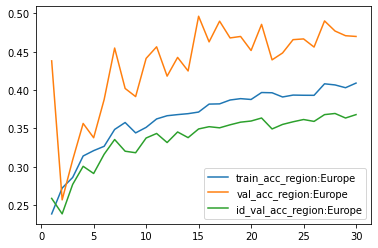

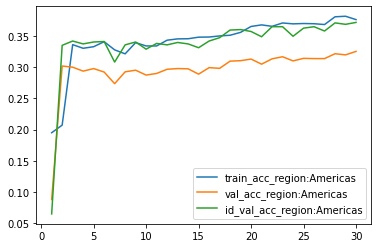

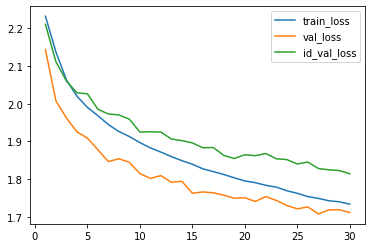

In [7]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, NUM_EPOCHS)